Note: The completed analysis is in the middle of the notebook. I did not remove the rest of the code, because I have used some of the plots from the other sections in the report.

Data prepration and normal distribution

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [50]:
#Let's import the libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
from google.colab import files

uploaded = files.upload()

Saving FoodRetailTurnover.csv to FoodRetailTurnover.csv


In [8]:
df= pd.read_csv("FoodRetailTurnover.csv")
df.head()

Date  Turnover
0  Apr-1982    1162.6
1  May-1982    1150.9
2  Jun-1982    1160.0
3  Jul-1982    1206.4
4  Aug-1982    1152.5

Check data type and missing values

In [ ]:
print(df.dtypes)

Date         object
Turnover    float64
dtype: object


In [ ]:
print(df.isnull().sum())

Date        0
Turnover    0
dtype: int64


Check if the Date is a time series object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      485 non-null    object 
 1   Turnover  485 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB


In [ ]:
df.isna().sum()

Date        0
Turnover    0
dtype: int64

We can see Data is in Object format and Turnover is in float64 format.

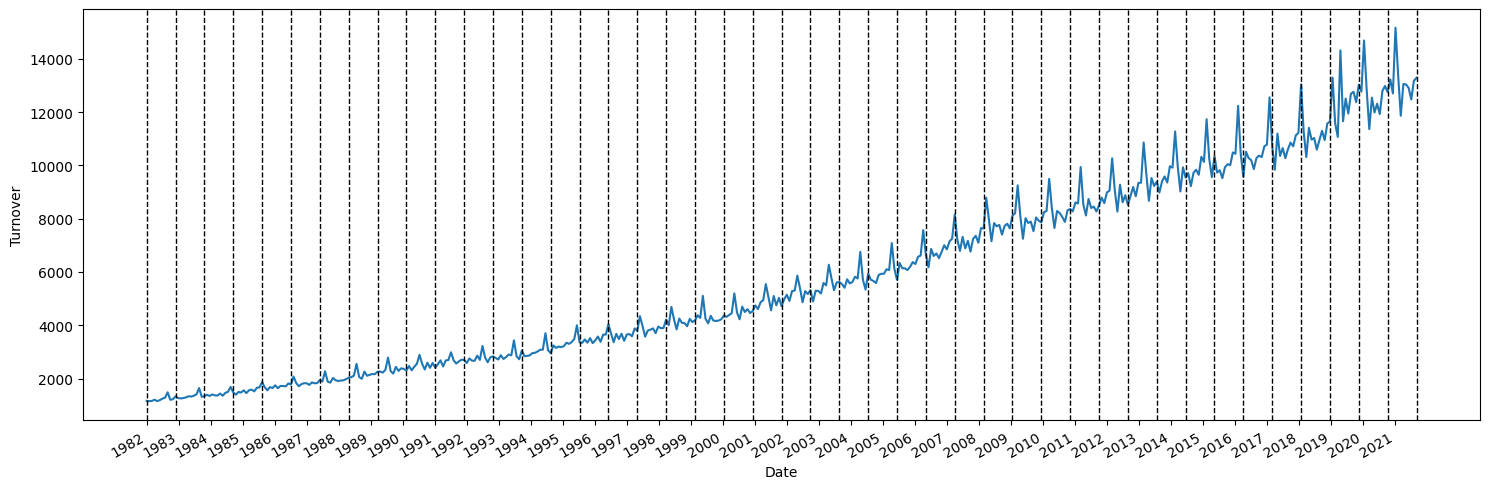

In [ ]:
# show the seasonal cycle

fig, ax = plt.subplots()

ax.plot(df['Date'], df['Turnover'])
for i in np.arange(0, 485, 11):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')

plt.xticks(np.arange(0, 485, 12.2), np.arange(1982, 2022, 1))


fig.set_size_inches(15,5)
fig.autofmt_xdate()
plt.tight_layout()

There is an obvious trend and seasonality, so the data is not stationary as the mean and variance is changing over time.

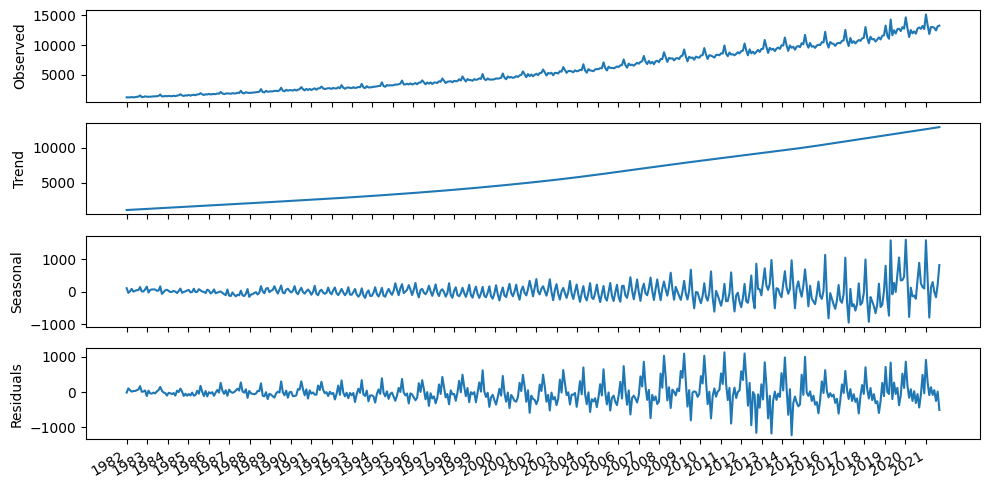

In [ ]:
#another way to clearly see hte seasonality is to divide by the components
decomposition = STL(df['Turnover'], period=80).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 485, 12.2), np.arange(1982, 2022, 1))
fig.set_size_inches(10,5)
fig.autofmt_xdate()
plt.tight_layout()

Convert Date into DateTime format

In [ ]:
df["Date"] = pd.to_datetime (df["Date"])

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df.head()

Date  Turnover
0 1982-04-01    1162.6
1 1982-05-01    1150.9
2 1982-06-01    1160.0
3 1982-07-01    1206.4
4 1982-08-01    1152.5

In [ ]:
# we will make date the index so that we can filter data by year,month, specific range etc...
df= df.set_index("Date")
df.head()

Turnover
Date                
1982-04-01    1162.6
1982-05-01    1150.9
1982-06-01    1160.0
1982-07-01    1206.4
1982-08-01    1152.5

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 485 entries, 1982-04-01 to 2022-08-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Turnover  485 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


In [ ]:
print(df.dtypes)

Turnover    float64
dtype: object


Testing normality

Assumption: Null hypothesis states that the data is normally distributed:

reject null hypothesis if p-value < 0.05 (meaning time series is not normally distributed)
Log and Power Transformation
If distribution is not normal, we can use log-transform and scalers and see which one gives a normal distribution

In [ ]:
from scipy.stats import shapiro

# using shapiro to check normality
stat, p_value = shapiro(df['Turnover'])

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The data is not normally distributed.')
else:
    print('The data appears to be normally distributed.')


Shapiro-Wilk Statistic: 0.9279984831809998
p-value: 1.6600947911260197e-14
The data is not normally distributed.


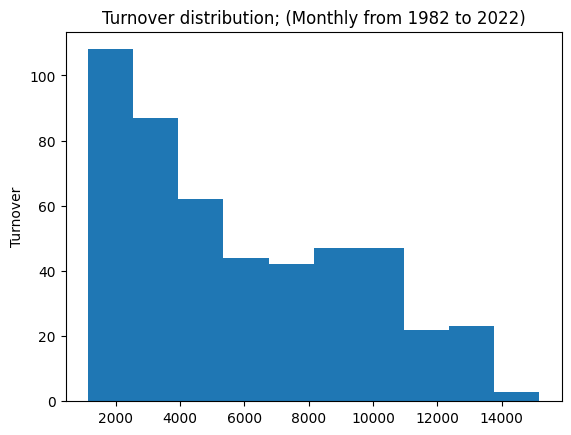

In [ ]:
#let see how the distribution looks like...
# Plot
plt.hist(df["Turnover"])

# Labelling
plt.ylabel("Turnover")
plt.title("Turnover distribution; (Monthly from 1982 to 2022)")

# Display
plt.show()

In [ ]:
#apply box-cox transform
from scipy.stats import boxcox

# in logarithmic or power transform, there is lambda parameter
# we will use the boxcox function with the default parameter value for "lmbda", which is "None"
# "None" value will find the optimal lambda value.
xt, lmbda = boxcox(df["Turnover"])
xts = pd.Series(xt, index=df.index)

Shapiro-Wilk Statistic: 0.9559227228164673
p-value: 7.413952091139819e-11
The transformed data is not normally distributed.


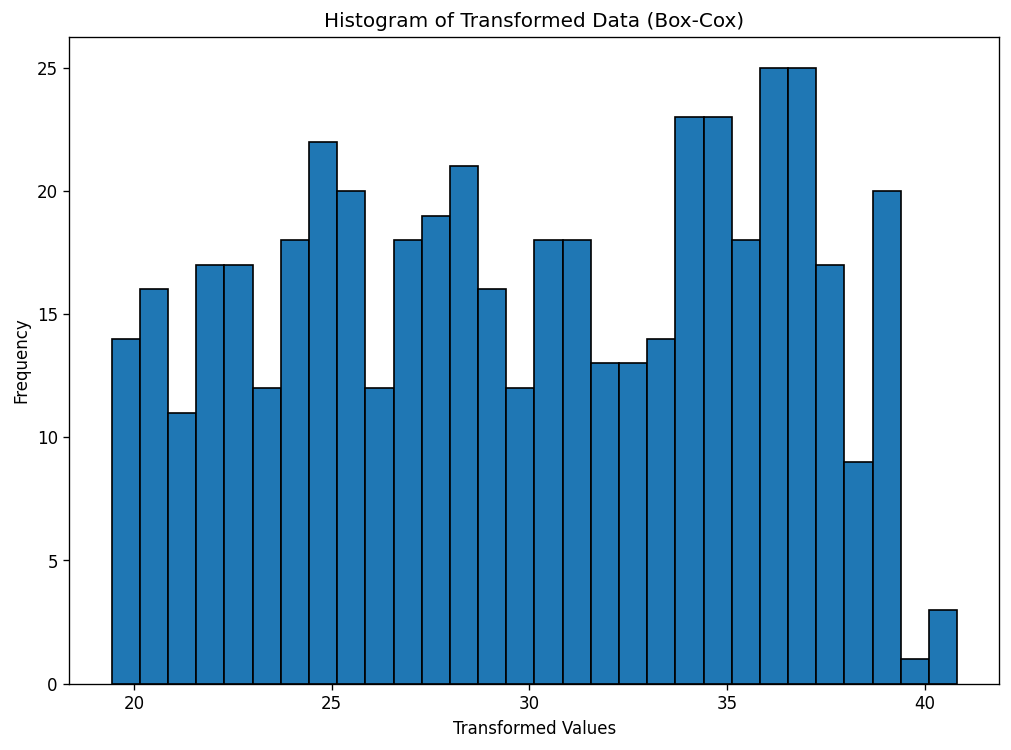

In [ ]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Assuming 'xts' is the transformed data
stat, p_value = shapiro(xts)

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The transformed data is not normally distributed.')
else:
    print('The transformed data appears to be normally distributed.')

# Plot the histogram of the transformed data
plt.hist(xts, bins=30, edgecolor='black')
plt.title('Histogram of Transformed Data (Box-Cox)')
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.show()


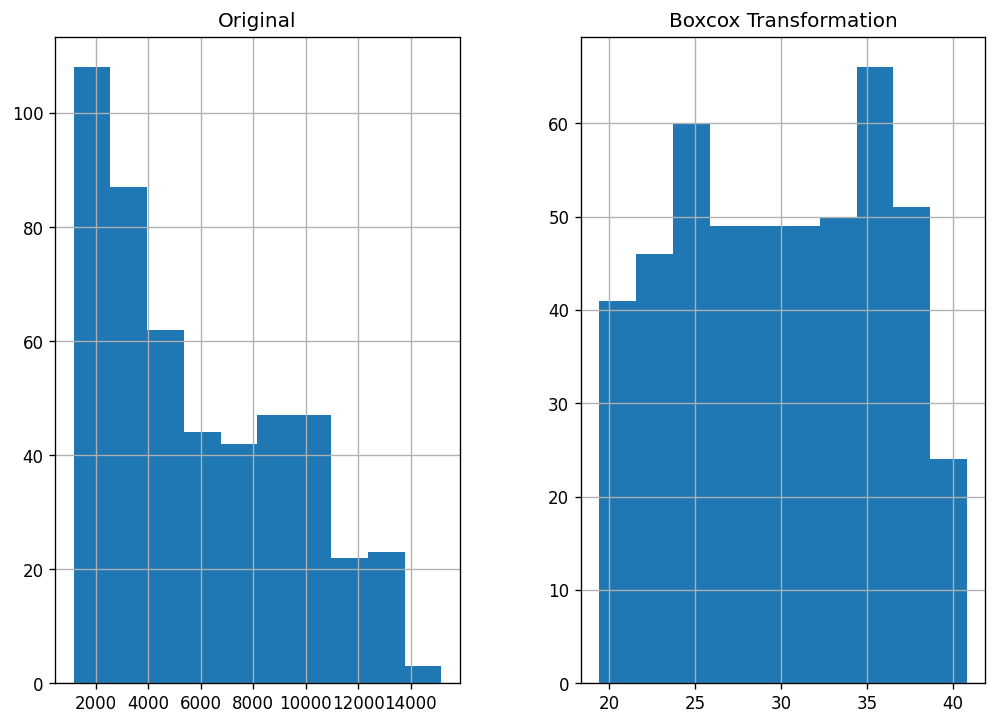

In [ ]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df.hist(ax=ax[0])

xts.hist(ax=ax[1])


# Labelling
ax[0].set_title("Original")
ax[1].set_title("Boxcox Transformation")

plt.show()

Note Boxcox does not guaranteee normality because it actually does not really check for normality; the method checks for the smallest standard deviation.

In the plots above, the boxcox transformation did not really converted the dataseries into a normal distribution.

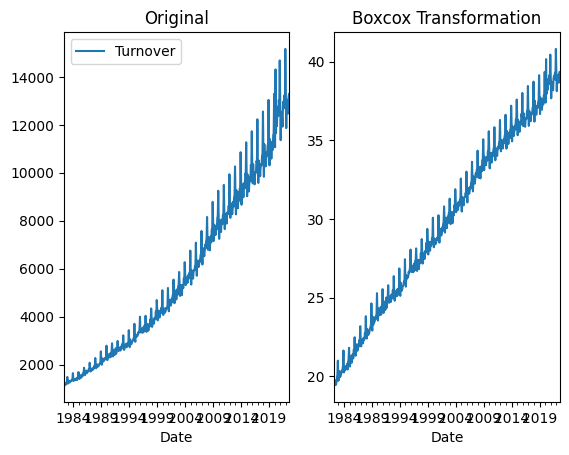

In [ ]:
#let us see how  the datasets look like before and after the transformation
# there will be two plots
fig, ax = plt.subplots(1, 2)

#original plot of data set
df.plot(ax=ax[0])

# plot of the transformed data set
xts.plot(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("Boxcox Transformation")

plt.show()

As you can see from the plots above, the boxcox transformation looks a bit more stable than the original dataseries.

Now, let's try another tranformation method using standardscaler.

In [ ]:
# we apply standard nomarlization to z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

#need to change to array so that we can reshape
df_array = df.to_numpy()

#lets use the standardscaler to transform
scaler = StandardScaler()
df_ss = scaler.fit_transform(df_array.reshape (-1,1))
_, p = normaltest(df_ss)

#removing the value from the data frame so that we can format it
index = 0
pvalue = p[index]
print("significance: %.4f" % pvalue)
if p_value < 0.05:
    print('The standardized data is not normally distributed.')
else:
    print('The standardized data appears to be normally distributed.')

significance: 0.0000
The standardized data is not normally distributed.


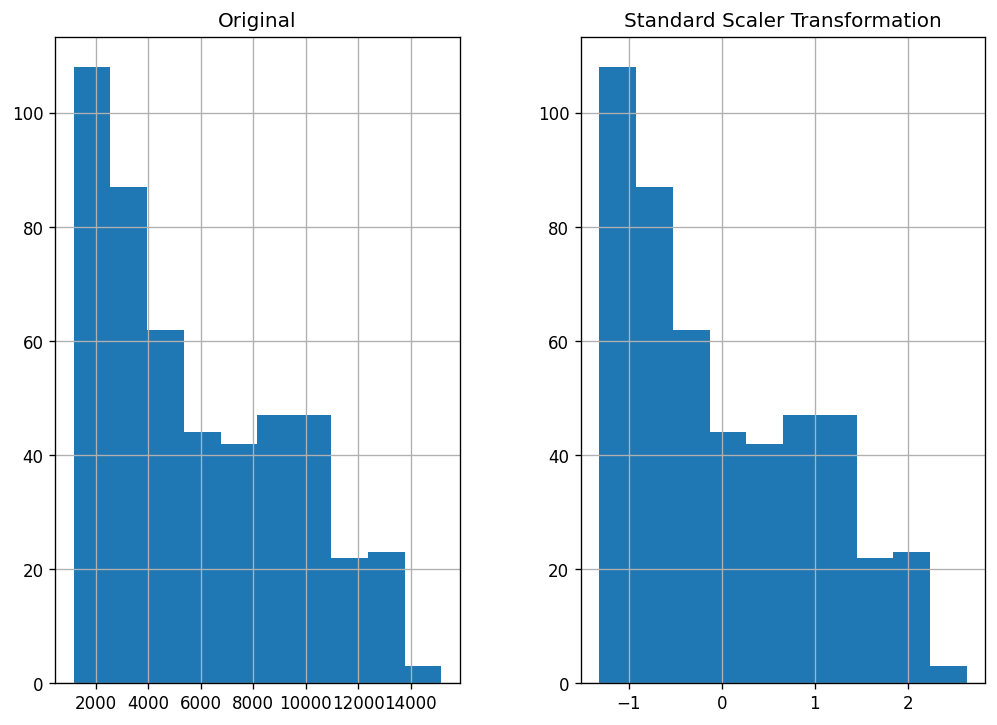

In [ ]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df.hist(ax=ax[0])

#convert the array to dataframe
df_ssdf = pd.DataFrame(df_ss)
df_ssdf.hist(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("Standard Scaler Transformation")

plt.show()

Both the statistical significance and histogram showed us that normal distribution has not been achieved.

The null hypothesis of the statistical test is that the sample comes from a normal distribution. If the significance value (p-value) is lower than a threshold, normally set to 0.05, we reject the null distribution. p-value is 0.0000, which is typically considered statistically significant.

Conclusion

We reject the hypothesis. This means that our data is not normally distributed.

In [ ]:
#let's use log transform

#add more libraries
from scipy.optimize import minimize


log_transformed = np.log(df)
_, p = normaltest(log_transformed)


#removing the value from the data frame so that we can format it
index = 0
pvalue = p[index]
print("significance: %.4f" % pvalue)

if p_value < 0.05:
    print('The standardized data is not normally distributed.')
else:
    print('The standardized data appears to be normally distributed.')

significance: 0.0000
The standardized data is not normally distributed.


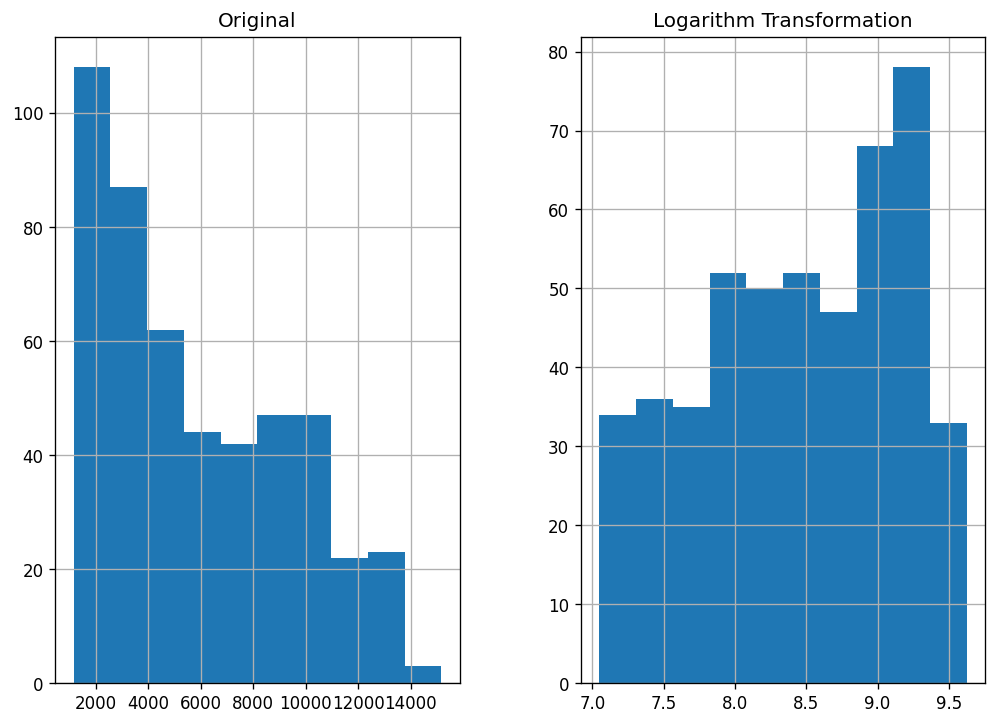

In [ ]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df.hist(ax=ax[0])

log_transformed.hist(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("Logarithm Transformation")

plt.show()

Conclusion

The same result as the boxcox transformation, we are getting a better distribution but not fully normalised.

At thist point, our data is not normally distributed. to make the data normal:
- identify and remove outliers
- Apply different transformation
-




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

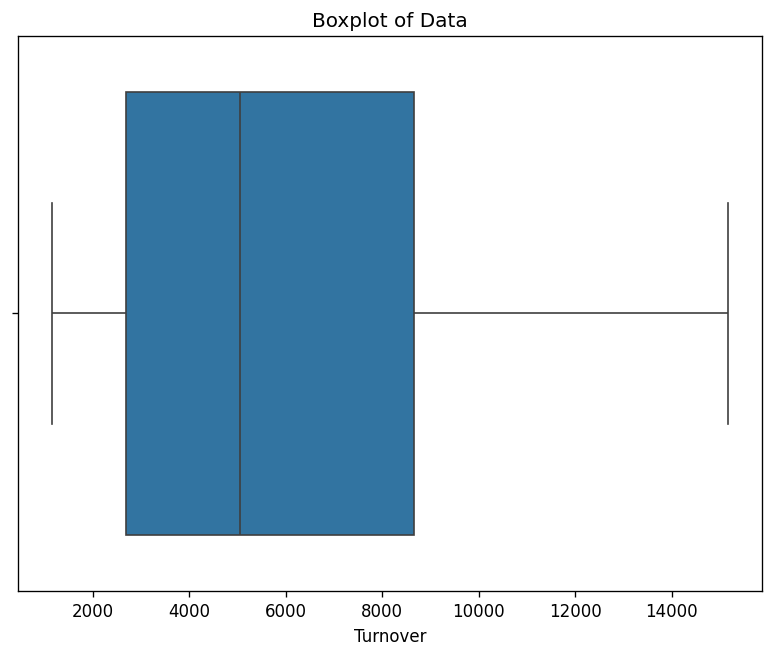

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Turnover'], whis=1.5)
plt.title('Boxplot of Data')
plt.xlabel('Turnover')
plt.show()


In [ ]:
from scipy.stats import zscore

# Identify and remove outliers using z-score
z_scores = zscore(df['Turnover'])
df_no_outliers = df[(z_scores < 3) & (z_scores > -3)]


In [ ]:
# Example: Square root transformation
df_no_outliers['sqrt_transform'] = np.sqrt(df_no_outliers['Turnover'])


In [ ]:
from scipy.stats import shapiro

# using shapiro to check normality
stat, p_value = shapiro(df_no_outliers['Turnover'])

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The data is not normally distributed.')
else:
    print('The data appears to be normally distributed.')

Shapiro-Wilk Statistic: 0.9279984831809998
p-value: 1.6600947911260197e-14
The data is not normally distributed.


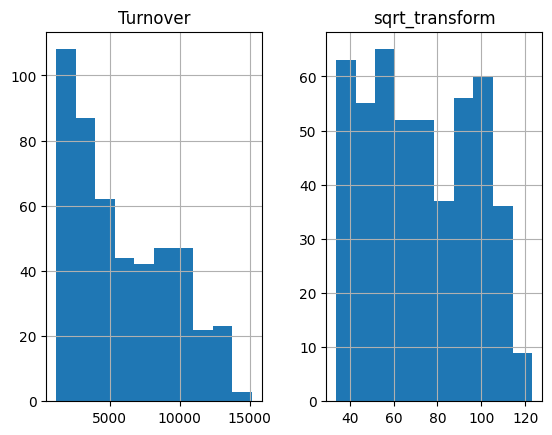

In [ ]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df.hist(ax=ax[0])

df_no_outliers.hist(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("SQRT Transformation")

plt.show()

In [ ]:
df_no_outliers.head()

Turnover  sqrt_transform
Date                                
1982-04-01    1162.6       34.096921
1982-05-01    1150.9       33.924917
1982-06-01    1160.0       34.058773
1982-07-01    1206.4       34.733269
1982-08-01    1152.5       33.948490

After analysing data, this step comes.

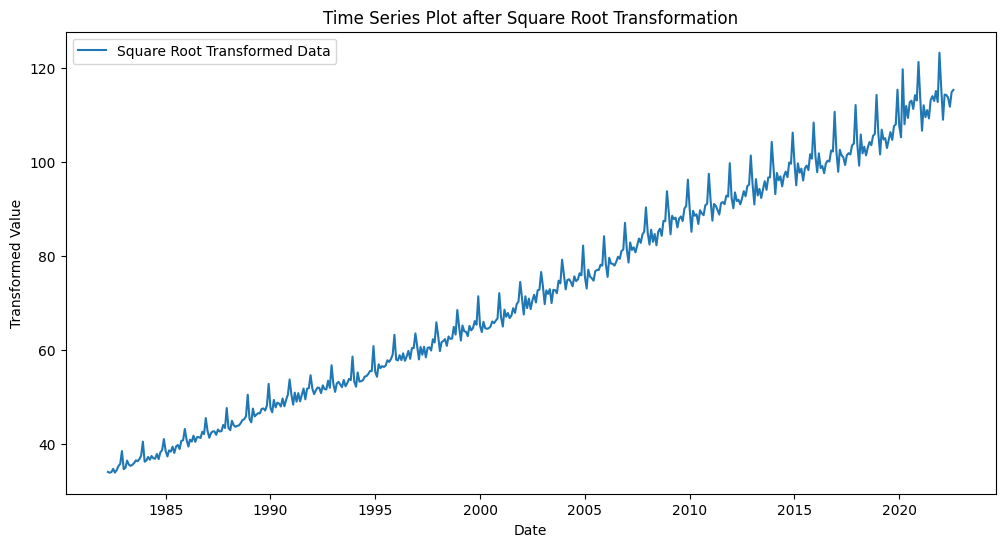

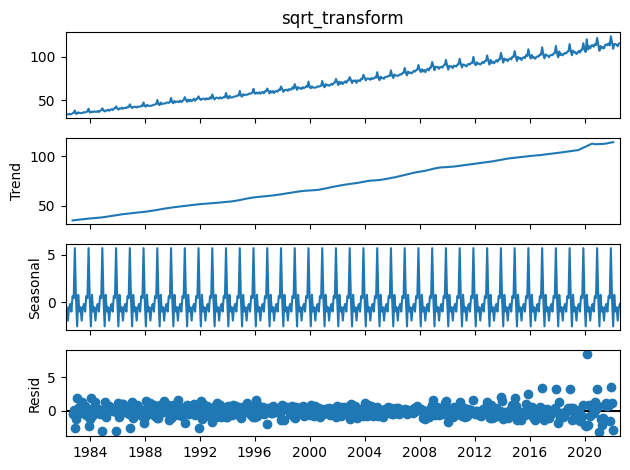

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore


df= pd.read_csv("FoodRetailTurnover.csv")

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['Date'])


# Identify and remove outliers using z-score
z_scores = zscore(df['Turnover'])
df = df[(z_scores < 3) & (z_scores > -3)]

# Apply square root transformation
df['sqrt_transform'] = df['Turnover'].apply(lambda x: x**0.5)

# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot the time series after square root transformation
plt.figure(figsize=(12, 6))
plt.plot(df['sqrt_transform'], label='Square Root Transformed Data')
plt.title('Time Series Plot after Square Root Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.show()

# Time series decomposition
the_seasonality = 12  # Set your seasonality (e.g., 12 for monthly data)
result = seasonal_decompose(df['sqrt_transform'], model='additive', period=the_seasonality)
result.plot()
plt.show()


In [ ]:
df.head()

Date  Turnover  sqrt_transform
date                                          
1982-04-01  Apr-1982    1162.6       34.096921
1982-05-01  May-1982    1150.9       33.924917
1982-06-01  Jun-1982    1160.0       34.058773
1982-07-01  Jul-1982    1206.4       34.733269
1982-08-01  Aug-1982    1152.5       33.948490

In [ ]:
# Create a new DataFrame with 'date' and 'sqrt_transform'
tDf = pd.DataFrame({
    'transformedTurnover': df['sqrt_transform']
})

# Display the new dataset
print(tDf)

            transformedTurnover
date                           
1982-04-01            34.096921
1982-05-01            33.924917
1982-06-01            34.058773
1982-07-01            34.733269
1982-08-01            33.948490
...                         ...
2022-04-01           114.164355
2022-05-01           113.594014
2022-06-01           111.667363
2022-07-01           114.767156
2022-08-01           115.250163

[485 rows x 1 columns]


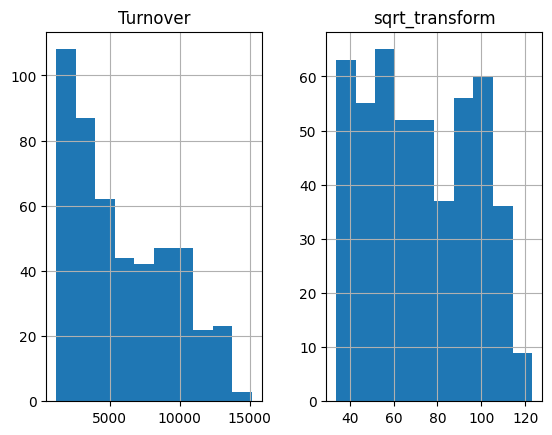

In [ ]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df.hist(ax=ax[0])

tDf.hist(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("SQRT Transformation")

plt.show()

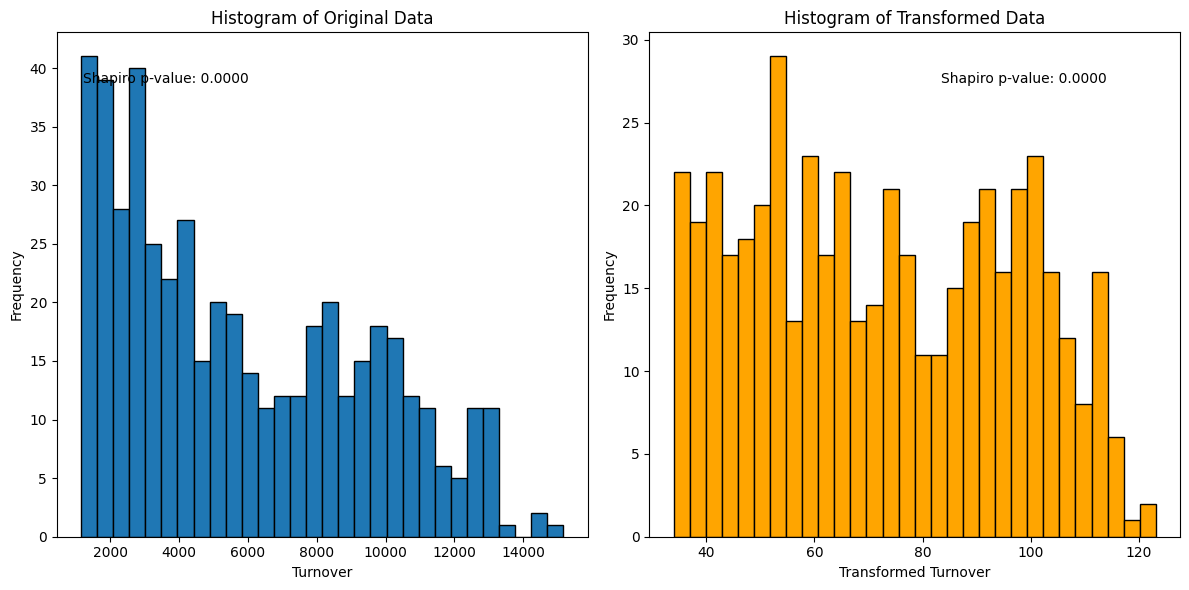

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Plot histogram for the original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Turnover'], bins=30, edgecolor='black')
plt.title('Histogram of Original Data')
plt.xlabel('Turnover')
plt.ylabel('Frequency')

# Shapiro-Wilk test for normality on the original data
stat, p_value_original = shapiro(df['Turnover'])
plt.text(0.05, 0.9, f'Shapiro p-value: {p_value_original:.4f}', transform=plt.gca().transAxes)

# Plot histogram for the transformed data
plt.subplot(1, 2, 2)
plt.hist(tDf['transformedTurnover'], bins=30, edgecolor='black', color='orange')
plt.title('Histogram of Transformed Data')
plt.xlabel('Transformed Turnover')
plt.ylabel('Frequency')

# Shapiro-Wilk test for normality on the transformed data
stat, p_value_transformed = shapiro(tDf['transformedTurnover'])
plt.text(0.55, 0.9, f'Shapiro p-value: {p_value_transformed:.4f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [ ]:
tDf.head()

transformedTurnover
date                           
1982-04-01            34.096921
1982-05-01            33.924917
1982-06-01            34.058773
1982-07-01            34.733269
1982-08-01            33.948490

In [ ]:
df.head()

Date  Turnover  sqrt_transform
date                                          
1982-04-01  Apr-1982    1162.6       34.096921
1982-05-01  May-1982    1150.9       33.924917
1982-06-01  Jun-1982    1160.0       34.058773
1982-07-01  Jul-1982    1206.4       34.733269
1982-08-01  Aug-1982    1152.5       33.948490

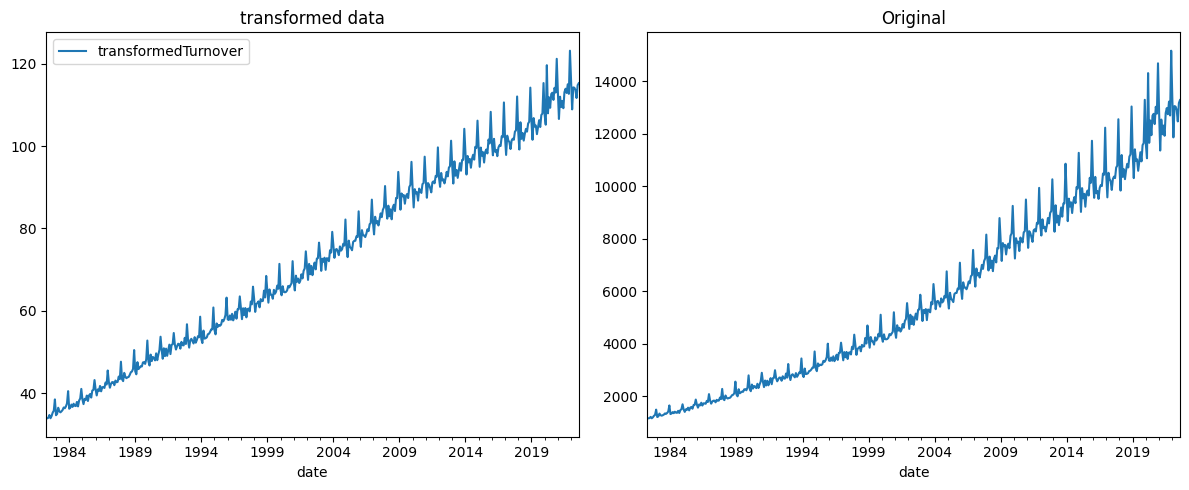

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first DataFrame
tDf.plot(ax=axs[0])
axs[0].set_title('transformed data')

# Plot the second DataFrame
df['Turnover'].plot(kind="line", ax=axs[1])
axs[1].set_title('Original')

plt.tight_layout()
plt.show()


Decomposing Time Series Data into Components

Seasonal Decompose

In [ ]:
#import libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL

#by default statsmodel are small so we set .rcParams for the visuals to make them large enough
plt.rcParams["figure.figsize"] = (10,4)

<Axes: xlabel='date'>

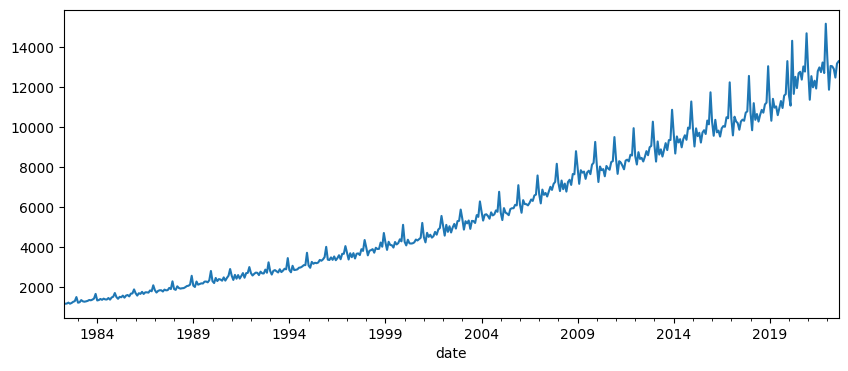

In [ ]:
#let's plot the time series to understand whether the seasonality shows multiplicative or additive behavior
df['Turnover'].plot()
#df_no_outliers.plot()

The Turnover is showing trend and but we are not sure about the season variations. Let's see if we use additive and multiplicative what will happen.

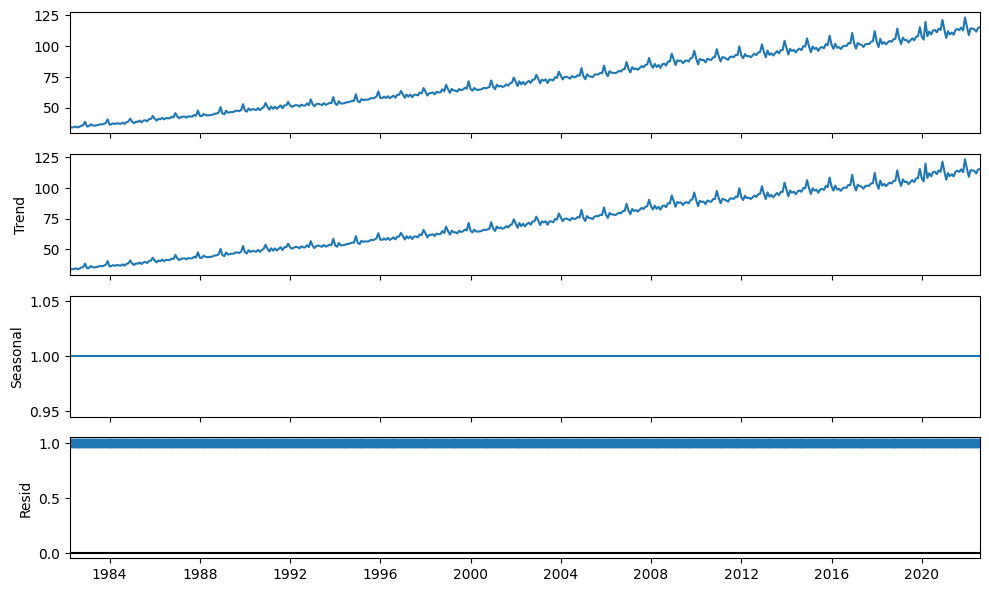

In [ ]:
# decompose using seasonal_decompose() function
#Because the time series was contrived and was provided as an array of numbers
# we must specify the frequency of the observations (the period=1 argument)
#If a Pandas Series object is provided, this argument is not required.
df_decomposed = seasonal_decompose(tDf, model= 'multiplicative', period=1)

#plot them and let us make the figure size a bit bigger
plt.rcParams["figure.figsize"] = (10,6)
df_decomposed.plot()
plt.show()

The plot has four parts:

This is the original observed data that we are decomposing.
The trend component shows an upward direction. The trend indicates whether there is positive (increasing or upward), negative (decreasing or downward), or constant (no trend or horizontal) long-term movement.
The seasonal component shows the seasonality effect and it looks like there is seasonality.
The residual (noise) component shows the random variation in the data after applying the model. In this case, an additive model was used.
Let's try a more advanced technique to get the seasonality.

Using STL
STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while loess is a method for estimating nonlinear relationships.

For expalantions of parameters of STL, go to this site: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html

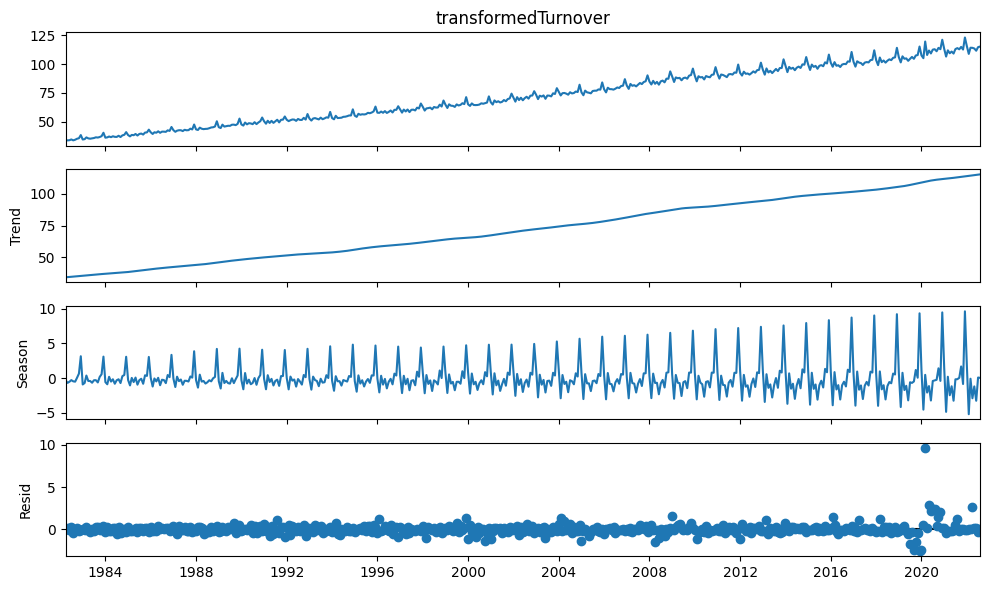

In [ ]:
#using STL
#we define the period to define the frequency since our data series frequency is not clearly indicated
df_stl = STL(tDf.transformedTurnover, period=12, robust=True).fit()
df_stl.plot(); plt.show()

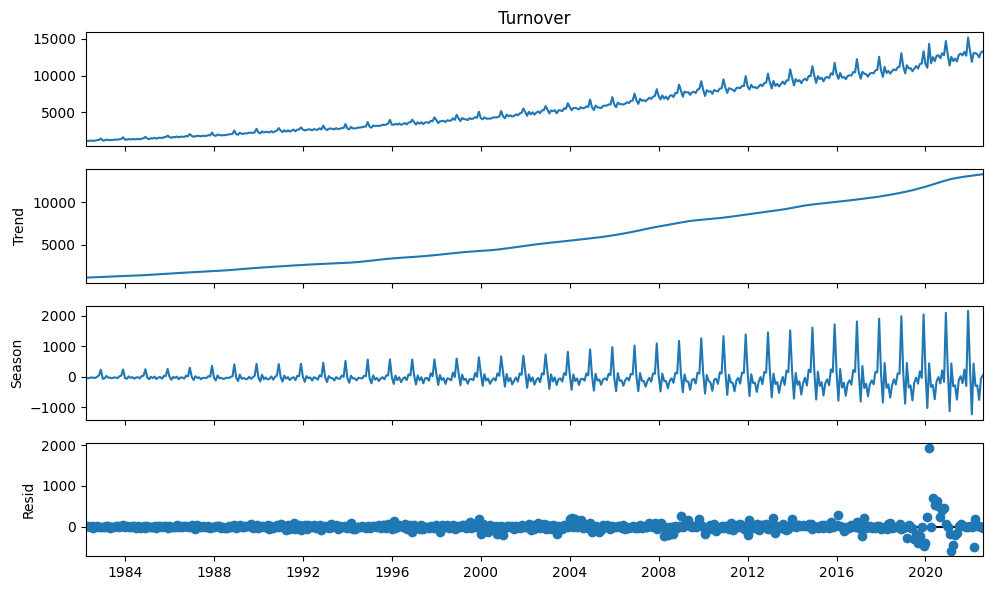

In [ ]:
#using STL
#we define the period to define the frequency since our data series frequency is not clearly indicated
df_stl = STL(df.Turnover, period=12, robust=True).fit()
df_stl.plot(); plt.show()

The plot has four parts:

This is the original observed data that we are decomposing.
The trend component shows an upward direction. The same as what we've seen in season_decompose.
The seasonal component shows the seasonality effect and it is more obvious here in this plot. It shows the repeating patterns of highs and lows.
The residual (noise) component shows the random variation in the data after applying the model.
Part 4 Other Time Series Data Preprocessing Activities
We will look at extracting, years, months and days, annotating holidays, date, paydays and seasons for imputation.

In [ ]:
#df= pd.read_csv("FoodRetailTurnover.csv")
#df.head()

In [ ]:
#df["Date"] = pd.to_datetime(df["Date"])
#df.head()

Date  Turnover
0 1982-04-01    1162.6
1 1982-05-01    1150.9
2 1982-06-01    1160.0
3 1982-07-01    1206.4
4 1982-08-01    1152.5

Split to train/test

In [ ]:
# split 60-40
train = df[:-4]
test = df[-4:]

In [ ]:
test.head()

Date  Turnover  sqrt_transform
date                                          
2022-05-01  May-2022   12903.6      113.594014
2022-06-01  Jun-2022   12469.6      111.667363
2022-07-01  Jul-2022   13171.5      114.767156
2022-08-01  Aug-2022   13282.6      115.250163

Forecasting using Historical Mean
We will implement the baseline. We will first use the arithmetic mean of the entire train set.

In [ ]:
#compute for the mean from 1982-2022-8
historical_mean = np.mean(train.Turnover)
historical_mean

5759.856964656965

We will naively forecast this value for 2022-9.

In [ ]:
#we create a new column: pred, which contains the historical mean
pred_hist_mean = pd.DataFrame()
pred_hist_mean['Date'] = test.Date
pred_hist_mean['Turnover'] = test.Turnover
pred_hist_mean['pred'] = historical_mean

pred_hist_mean

Date  Turnover         pred
date                                       
2022-05-01  May-2022   12903.6  5759.856965
2022-06-01  Jun-2022   12469.6  5759.856965
2022-07-01  Jul-2022   13171.5  5759.856965
2022-08-01  Aug-2022   13282.6  5759.856965

Step 6 Use MAPE to calculate error
Mean Absolute Percentage Error (MAPE) is a measure of prediction accuracy for forecasting methods that is easy to interpret and independent of the scale of our data. This means that whether we are working with two-digit values or six-digit values, the MAPE will always be expressed as a percentage. MAPE returns the percentage of how much the forecast values deviate from the observed or actual values on average, whether the prediction was higher or lower than the observed values.

We’ll define a mape function that takes in two vectors: y_true for the actual values observed in the test set and y_pred for the forecast values. In this case, because numpy allows us to work with arrays, we will not need a loop to sum all the values. We can simply subtract the y_pred array from the y_true array and divide by y_true to get the percentage error. Then we can take the absolute value. fter that, we take the mean of the result, which will take care of summing up each value in the vector and dividing by the number of predictions.

For details for the formula, you check it here: https://www.statisticshowto.com/mean-absolute-percentage-error-mape/

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#compute the MAPE of our baseline model
mape_hist_mean = mape(test.Turnover, pred_hist_mean.pred)
mape_hist_mean

55.51939672848998

What does this mean?
This means that our baseline deviates by 55.52% on average from the observed turnover 2022.

Let's visualise to understand MAPE

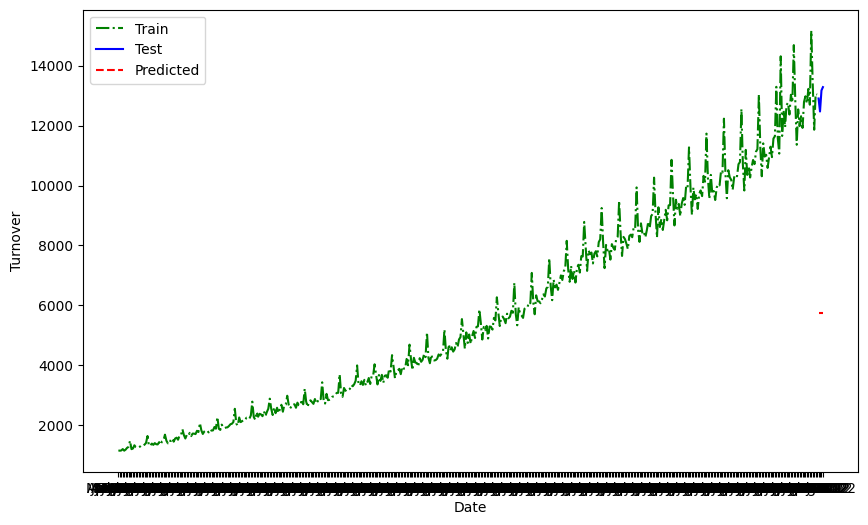

In [ ]:
fig, ax = plt.subplots()

ax.plot(train.Date, train.Turnover, 'g-.', label='Train')
ax.plot(test.Date, test.Turnover, 'b-', label='Test')
ax.plot(pred_hist_mean.Date, pred_hist_mean.pred, 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')

ax.legend(loc=2)

You can see the small red dot there(predicted value) and the blue color (actual value)

STEP 7: Forecast using previous year's mean
From the previous baseline is that earlier values do not seem to be predictive of future values in the long term because of the positive trend component in our dataset.We will use the mean of the last year in our training set to forecast the following year.

In [ ]:
#compute last year's mean: we need to change our training set
last_year_mean = np.mean(train.Turnover[-12:])
last_year_mean

12929.491666666667

In [ ]:
#create the new column which contains last year's mean
pred_last_year_mean = pd.DataFrame()
pred_last_year_mean['Date'] = test.Date
pred_last_year_mean['Turnover'] = test.Turnover
pred_last_year_mean['pred'] = last_year_mean

pred_last_year_mean

Date  Turnover          pred
date                                        
2022-05-01  May-2022   12903.6  12929.491667
2022-06-01  Jun-2022   12469.6  12929.491667
2022-07-01  Jul-2022   13171.5  12929.491667
2022-08-01  Aug-2022   13282.6  12929.491667

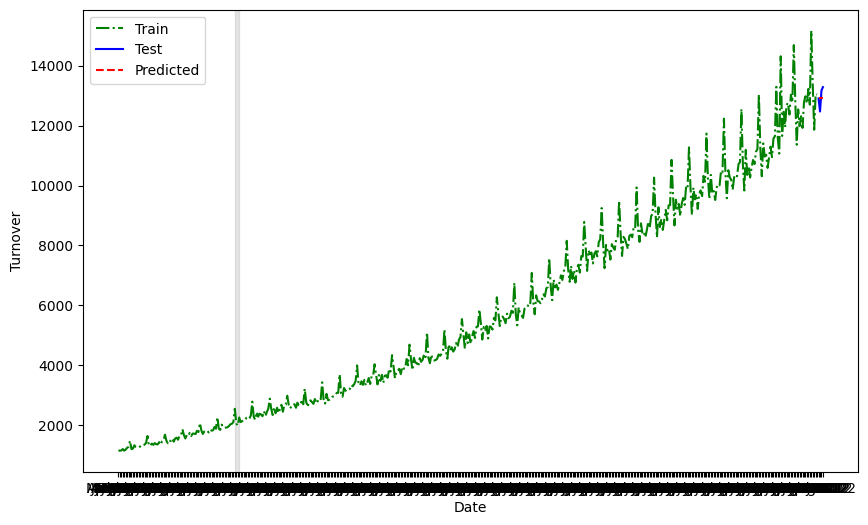

In [ ]:
#let's plot again to visualise the predicted versus the training set
ig, ax = plt.subplots()

ax.plot(train.Date, train.Turnover, 'g-.', label='Train')
ax.plot(test.Date, test.Turnover, 'b-', label='Test')
ax.plot(pred_last_year_mean.Date, pred_last_year_mean.pred, 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

In [ ]:
#compute the MAPE of the new model
mape_hist_mean = mape(test.Turnover, pred_last_year_mean.pred)
mape_hist_mean

2.0961371785866114

What does this mean?
We decreased the MAPE from 55.52% to 2.35%. We can see that in this baseline model that the future values likely depend on past values tha re not too far back.

Step 8: Forecast using the lat known value
The premise is that using the last known value of the training set as a baseline model will give us even better forecast.

In [ ]:
#get the last known value
last = train.Turnover.iloc[-1]
last

13033.5

In [ ]:
# append a new column called pred to hold the last known value
pred_last = pd.DataFrame()
pred_last['Date'] = test.Date
pred_last['Turnover'] = test.Turnover
pred_last['pred'] = last

pred_last

Date  Turnover     pred
date                                   
2022-05-01  May-2022   12903.6  13033.5
2022-06-01  Jun-2022   12469.6  13033.5
2022-07-01  Jul-2022   13171.5  13033.5
2022-08-01  Aug-2022   13282.6  13033.5

In [ ]:
#using the same MAPE function that we defined earlier, we can evaluate the performance of this new baseline model
mape_last = mape(test.Turnover, pred_last.pred)
mape_last

2.1129990738570106

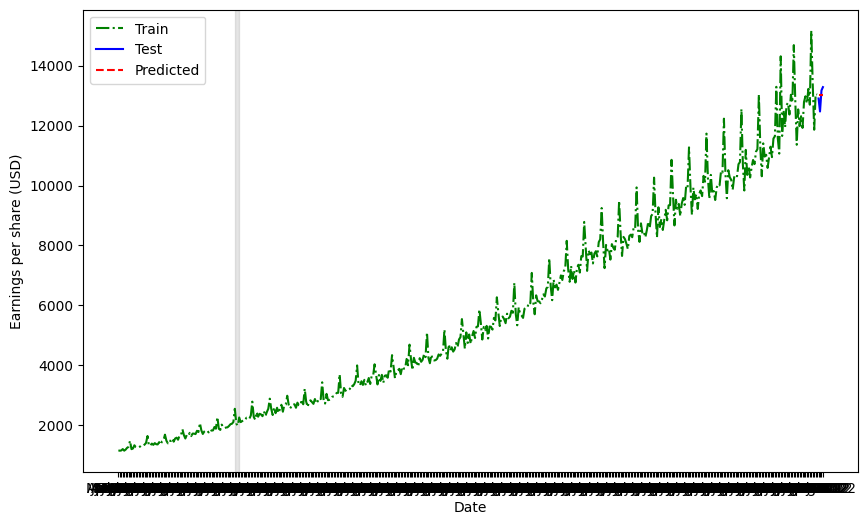

In [ ]:
#let us visualise
fig, ax = plt.subplots()

ax.plot(train.Date, train.Turnover, 'g-.', label='Train')
ax.plot(test.Date, test.Turnover, 'b-', label='Test')
ax.plot(pred_last.Date, pred_last.pred, 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

STEP 9 Naive Seasonal Forecast
Using the last known value does not take the seasonality into account, so we need to use another naive forecasting technique to see if we can produce a better baseline.

In [ ]:
# get the last value of train sets which we know corresponds to the last month of 2022shows the last four months
pred_naive_seasonal = pd.DataFrame()
pred_naive_seasonal=test
pred_naive_seasonal['pred'] = train.Turnover[-4:].values
pred_naive_seasonal

Date  Turnover  sqrt_transform     pred
date                                                   
2022-05-01  May-2022   12903.6      113.594014  13380.8
2022-06-01  Jun-2022   12469.6      111.667363  11860.5
2022-07-01  Jul-2022   13171.5      114.767156  13052.6
2022-08-01  Aug-2022   13282.6      115.250163  13033.5

In [ ]:
#calculate prediction error using MAPE
mape_naive_seasonal = mape(test.Turnover, pred_naive_seasonal.pred)
mape_naive_seasonal

2.8402411843900794

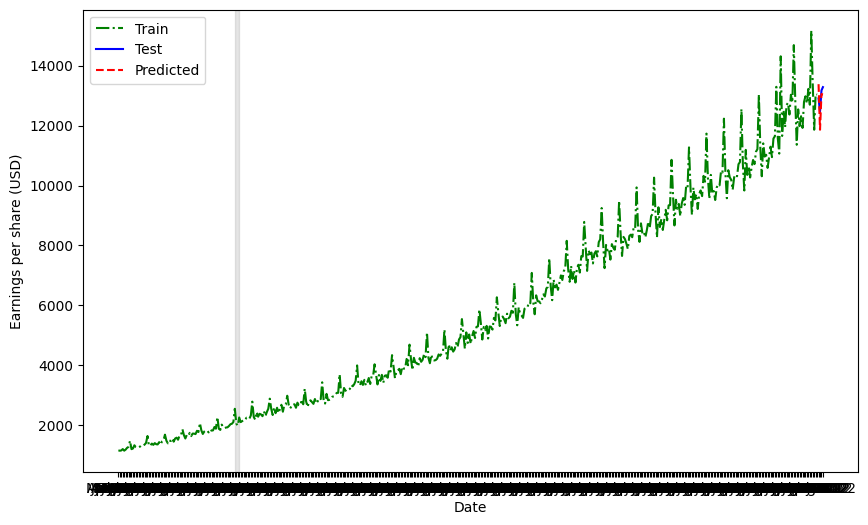

In [ ]:
#let's visualise
fig, ax = plt.subplots()

ax.plot(train.Date, train.Turnover, 'g-.', label='Train')
ax.plot(test.Date, test.Turnover, 'b-', label='Test')
ax.plot(pred_naive_seasonal.Date, pred_naive_seasonal.pred, 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

Pre-processinh steps

In [ ]:
df.Date.describe()

count          485
unique         485
top       Apr-1982
freq             1
Name: Date, dtype: object

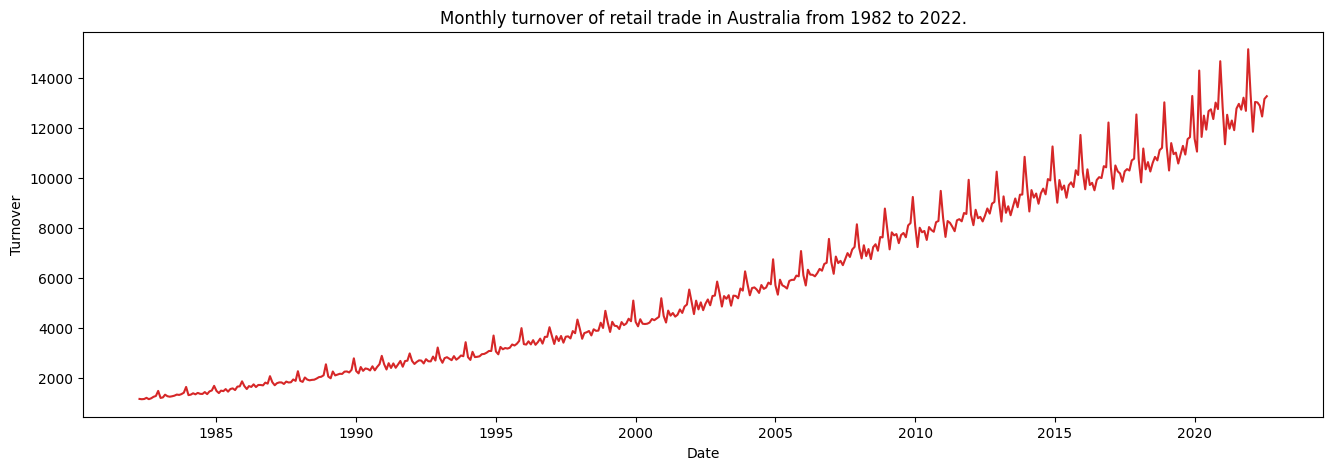

In [ ]:
# Time series data source: fpp pacakge in R.
import matplotlib.pyplot as plt
df = pd.read_csv('FoodRetailTurnover.csv', parse_dates=['Date'], index_col='Date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Turnover', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.Turnover, title='Monthly turnover of retail trade in Australia from 1982 to 2022.')

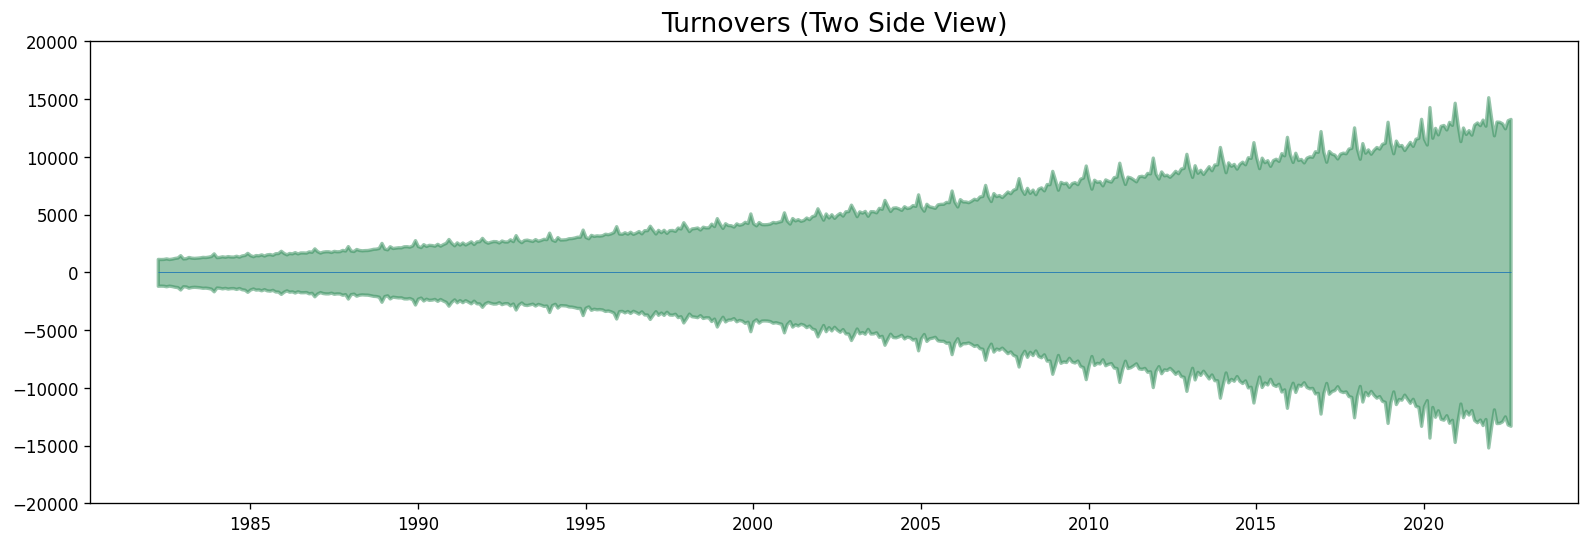

In [ ]:
# Import data
df = pd.read_csv('FoodRetailTurnover.csv', parse_dates=['Date'])
x = df['Date'].values
y1 = df['Turnover'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-20000, 20000)
plt.title('Turnovers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.Date), xmax=np.max(df.Date), linewidth=.5)
plt.show()

In [ ]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})


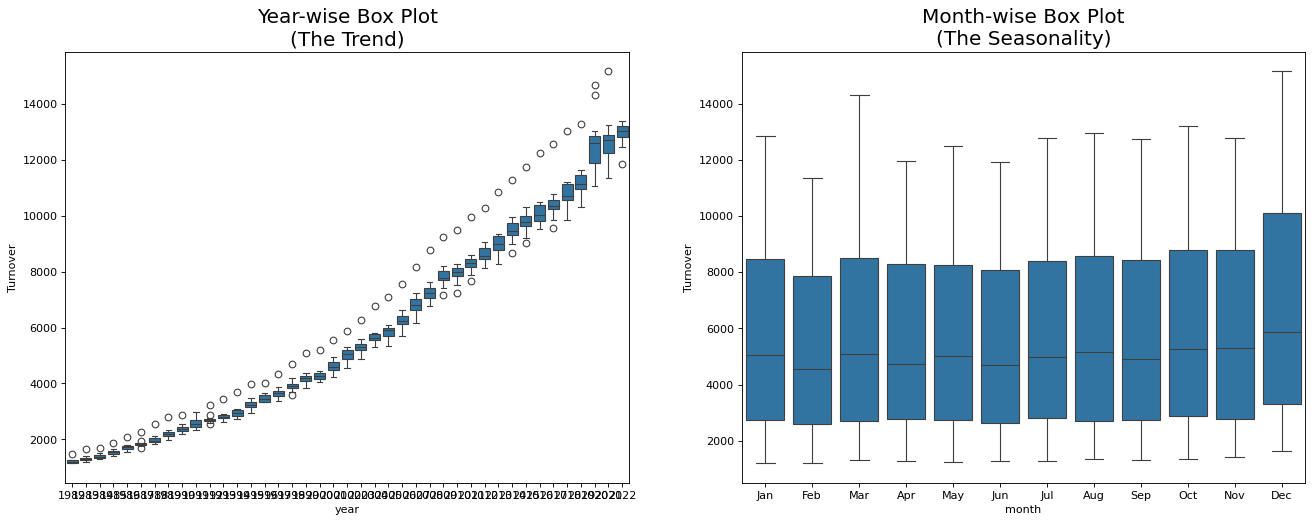

In [ ]:
# Import Data
df = pd.read_csv('FoodRetailTurnover.csv', parse_dates=['Date'], index_col='Date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Turnover', data=df, ax=axes[0])

sns.boxplot(x='month', y='Turnover', data=df.loc[~df.year.isin([1982, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()


Patterns in a time series
Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

Stationary and Non-Stationary Time Series

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

#let's filter all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read the data
df = pd.read_csv('FoodRetailTurnover.csv')
#
df.head()

Date  Turnover
0  Apr-1982    1162.6
1  May-1982    1150.9
2  Jun-1982    1160.0
3  Jul-1982    1206.4
4  Aug-1982    1152.5

In [ ]:
tDf.head()

transformedTurnover
date                           
1982-04-01            34.096921
1982-05-01            33.924917
1982-06-01            34.058773
1982-07-01            34.733269
1982-08-01            33.948490

In [ ]:
#check if the year is in datetime format
tDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 485 entries, 1982-04-01 to 2022-08-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transformedTurnover  485 non-null    float64
dtypes: float64(1)
memory usage: 7.6 KB


In [ ]:
#change the year to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# setting index
df = df.set_index('Date')
df.head()

Turnover
Date                
1982-04-01    1162.6
1982-05-01    1150.9
1982-06-01    1160.0
1982-07-01    1206.4
1982-08-01    1152.5

In [ ]:
#df.info()

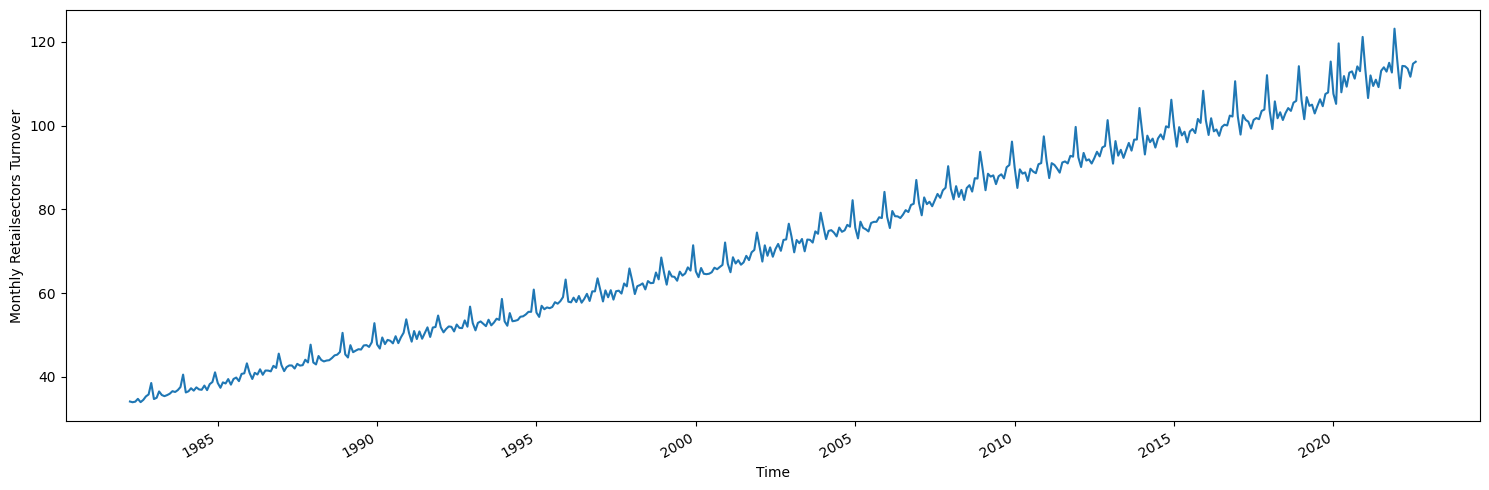

In [ ]:
#plot the data
fig, ax = plt.subplots()


ax.plot(tDf)

# label the x  and y axis
ax.set_xlabel('Time')
ax.set_ylabel('Monthly Retailsectors Turnover')

fig.set_figheight(5)
fig.set_figwidth(15)
#indent the lable to fit
fig.autofmt_xdate()
plt.tight_layout()


What do you observe in this graph?

Is it stationary process?
Does it show a trend?
Does it show seasonality?

Step 2 Test for Stationarity

In [ ]:
ADF_result = adfuller(df['Turnover'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 3.7513074217909343
p-value: 1.0


In [ ]:
ADF_result = adfuller(tDf['transformedTurnover'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 1.2785919328501825
p-value: 0.9964863390905532


The ADF (Augmented Dickey-Fuller) test is a statistical test used to determine whether a time series is stationary or not. The ADF statistic measures the strength of the trend in the data, with more negative values indicating a stronger trend. The p-value is the probability of observing a test statistic as extreme as, or more extreme than, the observed test statistic, assuming the null hypothesis is true.

In this case, the ADF statistic is 3.7513074217909343 and the p-value is 1.0. Since the p-value is greater than the significance level of 0.05, we fail to reject the null hypothesis that the time series is non-stationary. This means that there is evidence of a trend in the data and therefore the data is not stationary.

It is important to note that the ADF test is not perfect and can be affected by the presence of outliers, missing data, and other factors. Therefore, it is important to interpret the results of the ADF test in the context of other information about the data.

Note: A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, do not change over time. In other words, a stationary time series does not exhibit any trends or seasonality.

Step 3 Plot Autocorrelation

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting. These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/#:~:text=Autocorrelation%20and%20partial%20autocorrelation%20plots,observations%20at%20prior%20time%20steps.

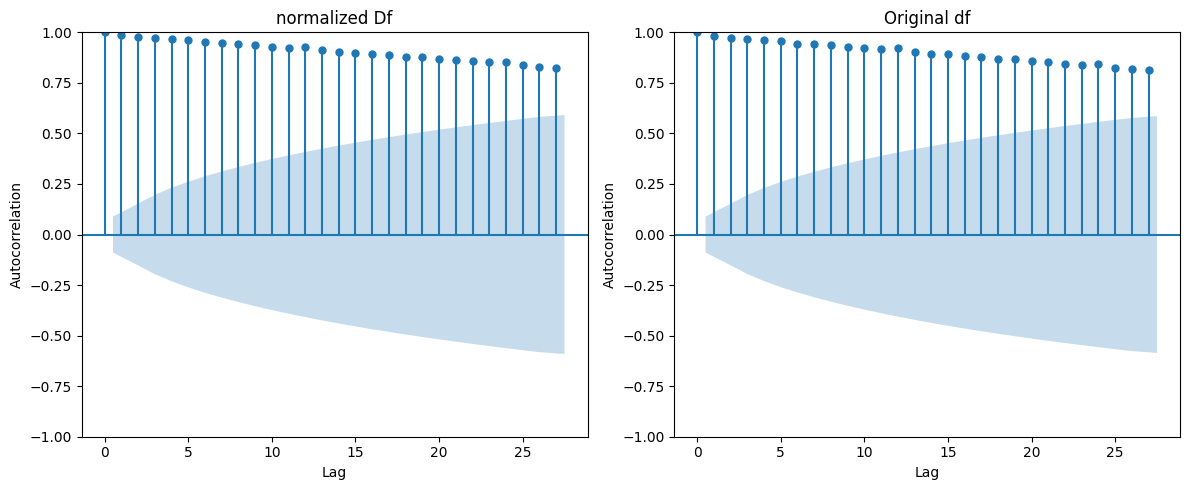

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF for the first DataFrame
acf_values_tDf = plot_acf(tDf, ax=axs[0])
axs[0].set_title('normalized Df')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')

# Plot the ACF for the second DataFrame
acf_values_df = plot_acf(df, ax=axs[1])
axs[1].set_title('Original df')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()


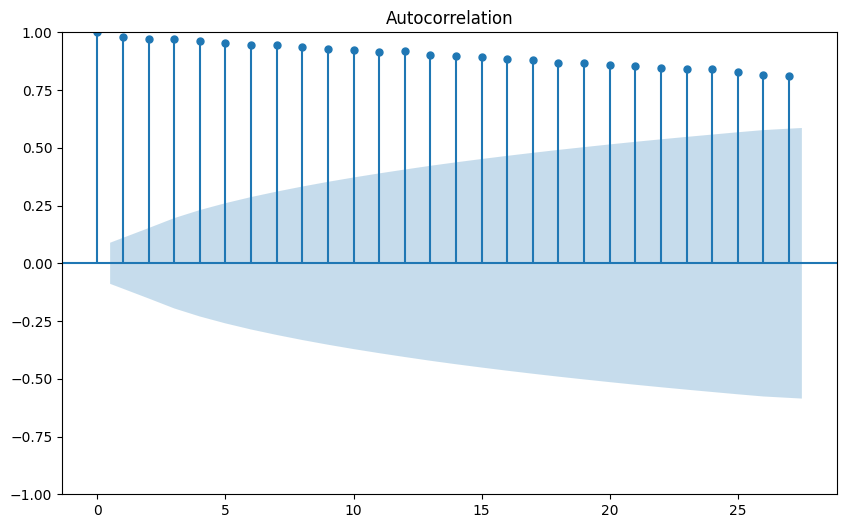

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df)
pyplot.show()

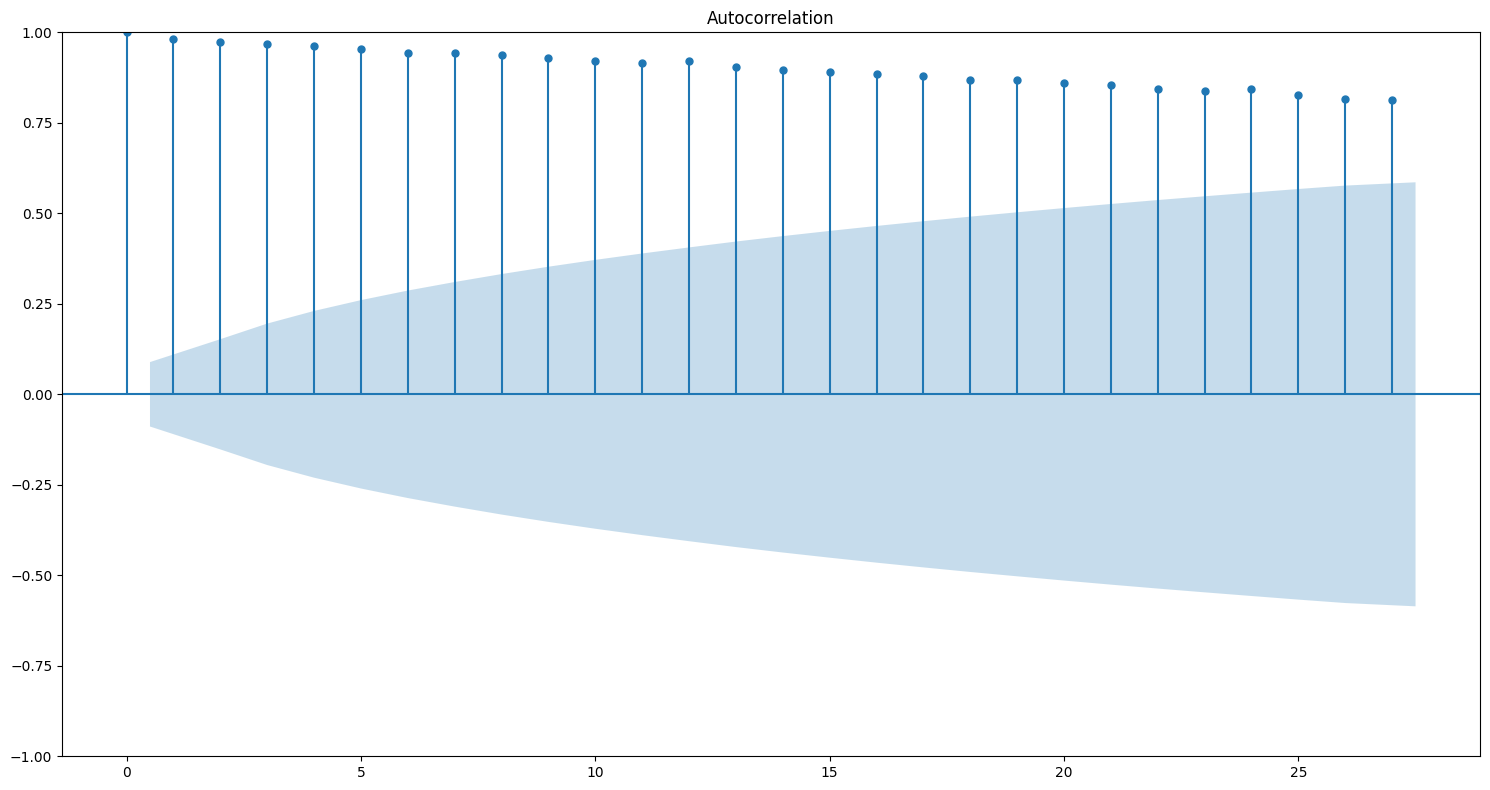

In [ ]:
# the number of lags determine the range of values on the x-axis , we will use the default lag

fig = plot_acf(df ['Turnover']);
# changing it's width and height
fig.set_size_inches(15,8)
plt.tight_layout()

Step 5 Partial ACF (PACF)

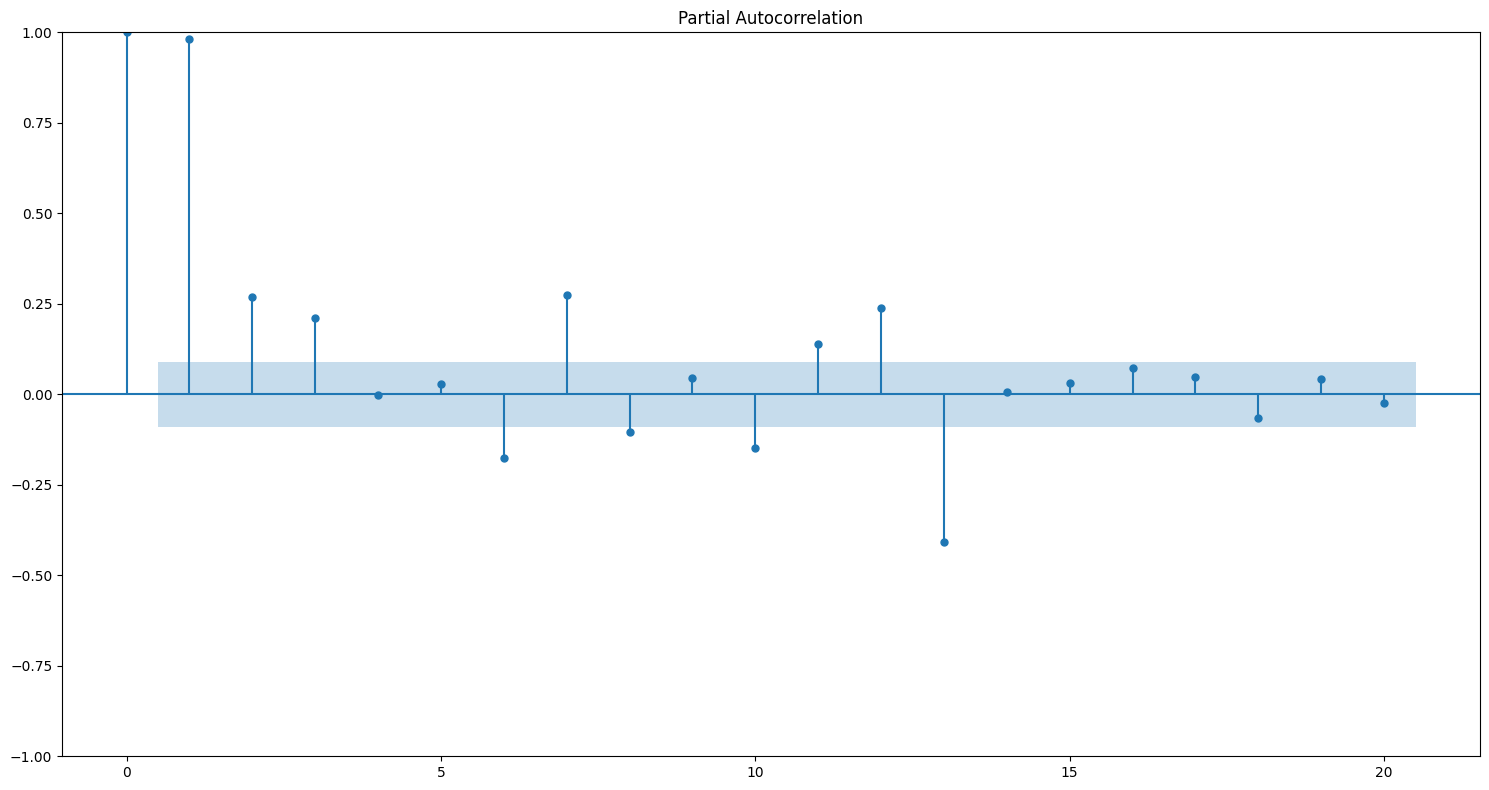

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(df['Turnover'], lags=20)
fig.set_size_inches(15,8)


plt.tight_layout()

plt.savefig('fpacf', dpi=300)

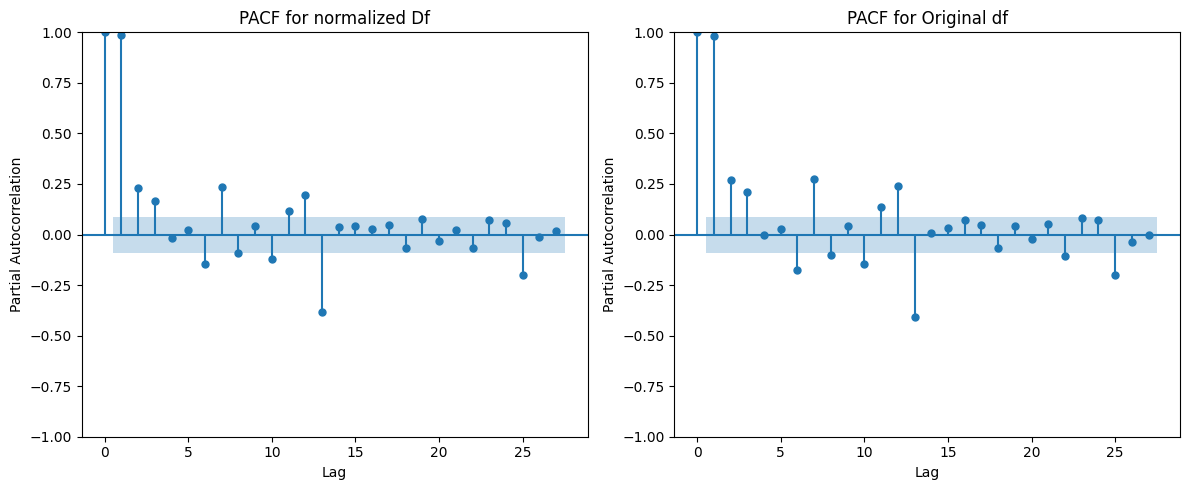

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the PACF for the first DataFrame
pacf_values_tDf = plot_pacf(tDf, ax=axs[0])
axs[0].set_title('PACF for normalized Df')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Partial Autocorrelation')

# Plot the PACF for the second DataFrame
pacf_values_df = plot_pacf(df, ax=axs[1])
axs[1].set_title('PACF for Original df')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


Make the data stationary

In [ ]:
#transform data
fdiff = np.diff(df['Turnover'], n=1)

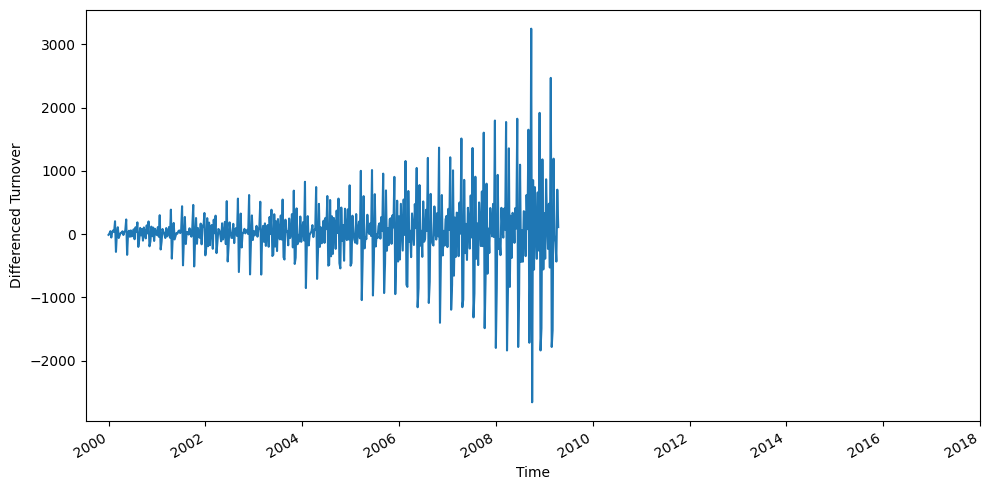

In [ ]:
#plot transformed data
fig, ax = plt.subplots()

ax.plot(fdiff)
ax.set_xlabel('Time')
ax.set_ylabel('Differenced Turnover')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.set_figheight(5)
fig.set_figwidth(10)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('transformedTurnover', dpi=300)

In [ ]:
#check for ADF
ADF_result = adfuller(fdiff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.504597906638449
p-value: 2.03521974749833e-06


We can see that the data is now stationary. So we can now check for autocorrelation...
nterpretation:

In this case, the ADF statistic is -5.504597906638449, which is a relatively large negative value. This suggests that the time series is likely stationary.

p-value:

The p-value associated with the ADF statistic is 2.03521974749833e-06, which is very small. This means that there is strong evidence to reject the null hypothesis that the time series is non-stationary.

Conclusion:

Based on the ADF statistic and p-value, we can conclude that the time series is likely stationary. This means that the mean, variance, and autocorrelation of the series are constant over time, making it suitable for further analysis using time series techniques.

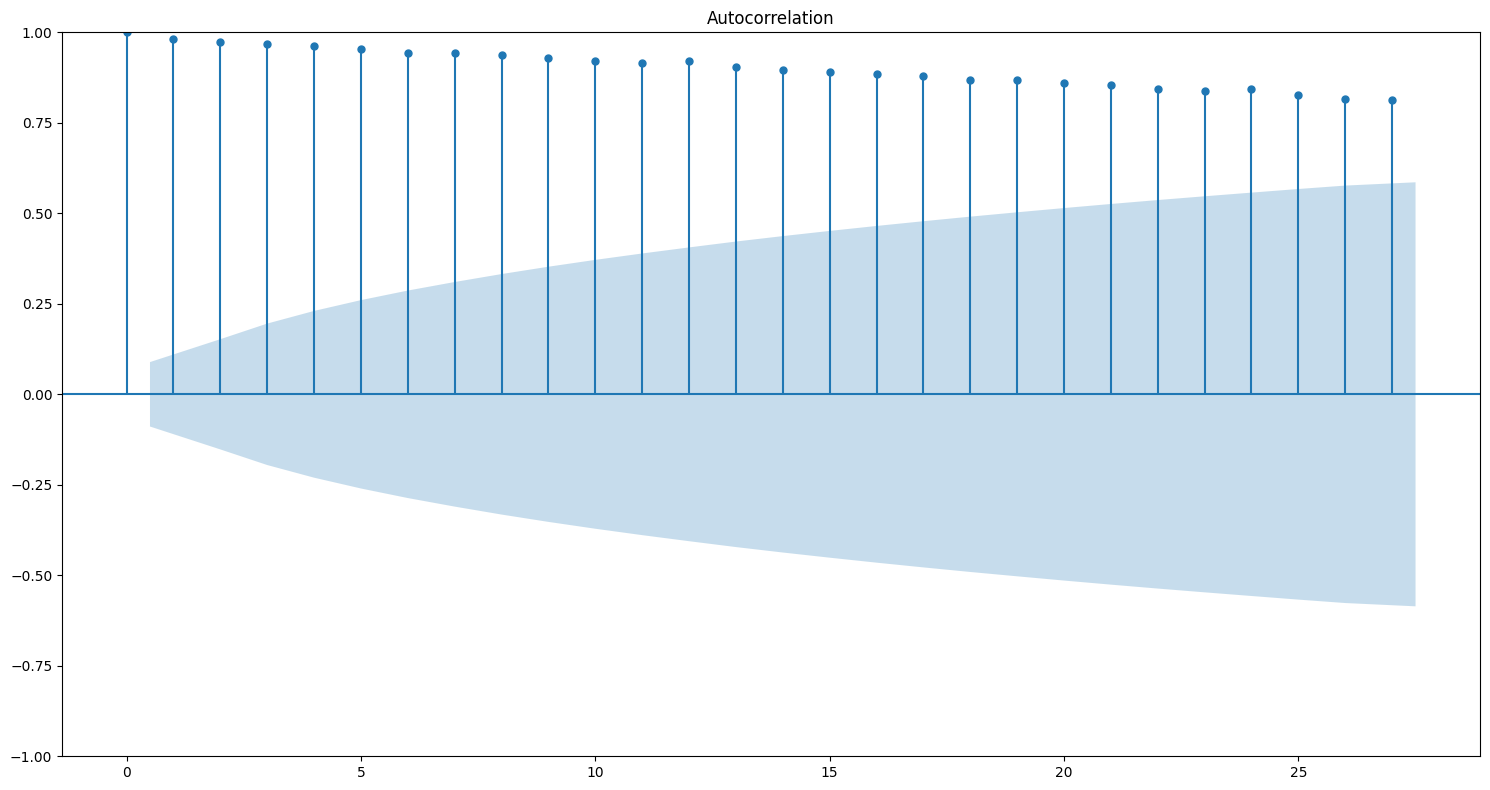

In [ ]:
# the number of lags determine the range of values on the x-axis , we will use the default lag
fig = plot_acf(df['Turnover']);
# changing it's width and height
fig.set_size_inches(15,8)
plt.tight_layout()
plt.savefig('Turnoverautocorrelation', dpi=300)

Autocorrelated so we check for Partial autocorrelation using PACF.

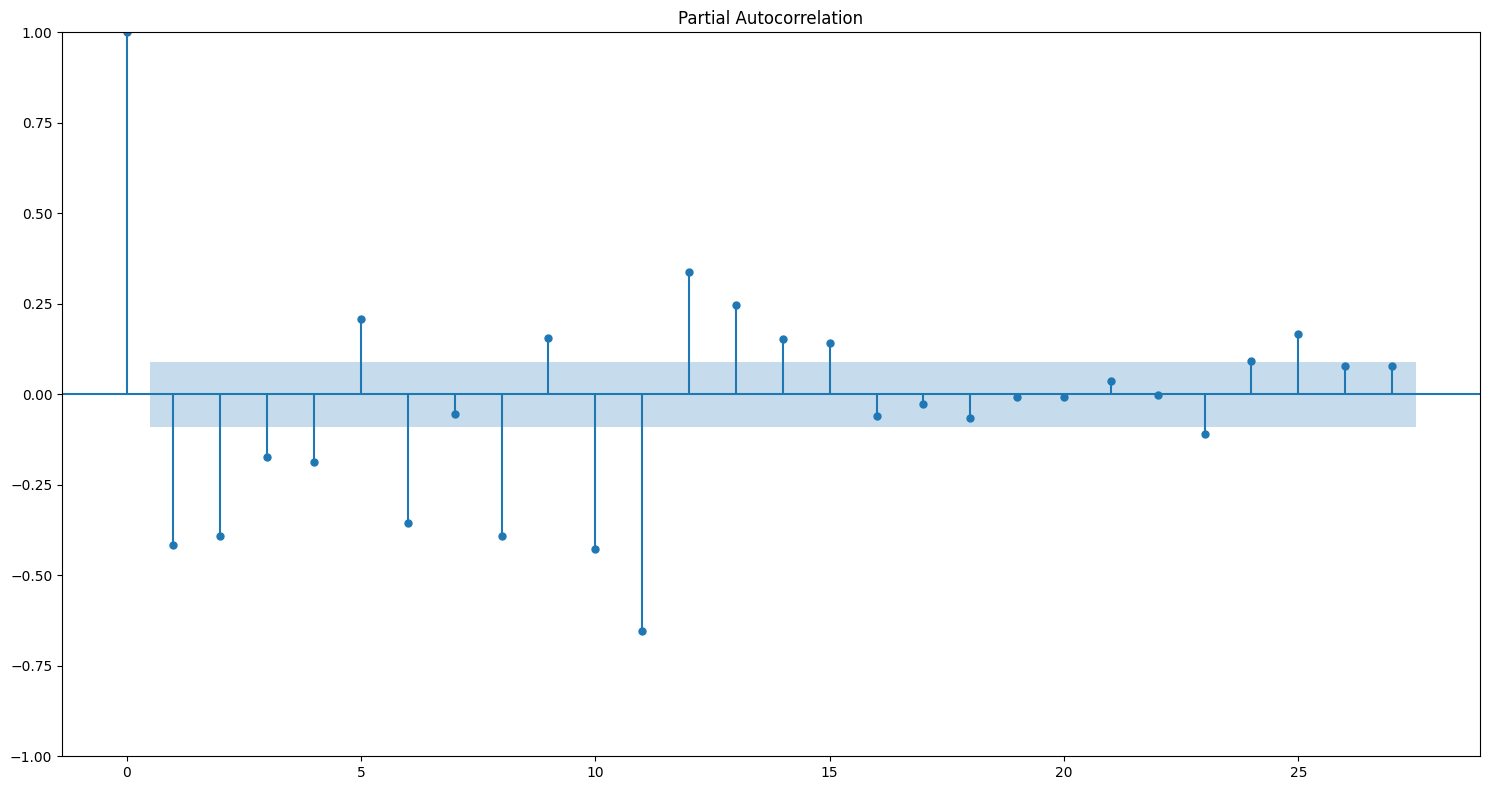

In [ ]:
#let's plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(fdiff)
fig.set_size_inches(15,8)


plt.tight_layout()

plt.savefig('fpacf', dpi=300)

In [ ]:
#let's do 80-32 train-test data
diff = pd.DataFrame({'fdiff': fdiff})
train = diff[:-12]
test = diff[-12:]

print(len(train))
print(len(test))

472
12


In [ ]:
#let's define a rolling forecast

def rolling_forecast(df2: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df2[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df2[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df2[:i], order=(3,0,0), enforce_stationarity=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [ ]:
#train the models and use the rolling forecast function
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

#updated test dataframe
test.head()

fdiff  pred_mean  pred_last_value      pred_AR
472  -233.3  25.030720            188.9  -461.200766
473   480.2  24.484567           -233.3   -71.671051
474  -528.0  25.445992            480.2  -222.126031
475  2468.3  24.280842           -528.0   146.254717
476 -1783.5  29.415336           2468.3 -1403.946559

In [ ]:
#calculate the error
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['fdiff'], test['pred_mean'])
mse_last = mean_squared_error(test['fdiff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['fdiff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

1191866.680314819 3283073.3000000003 761868.0700322231


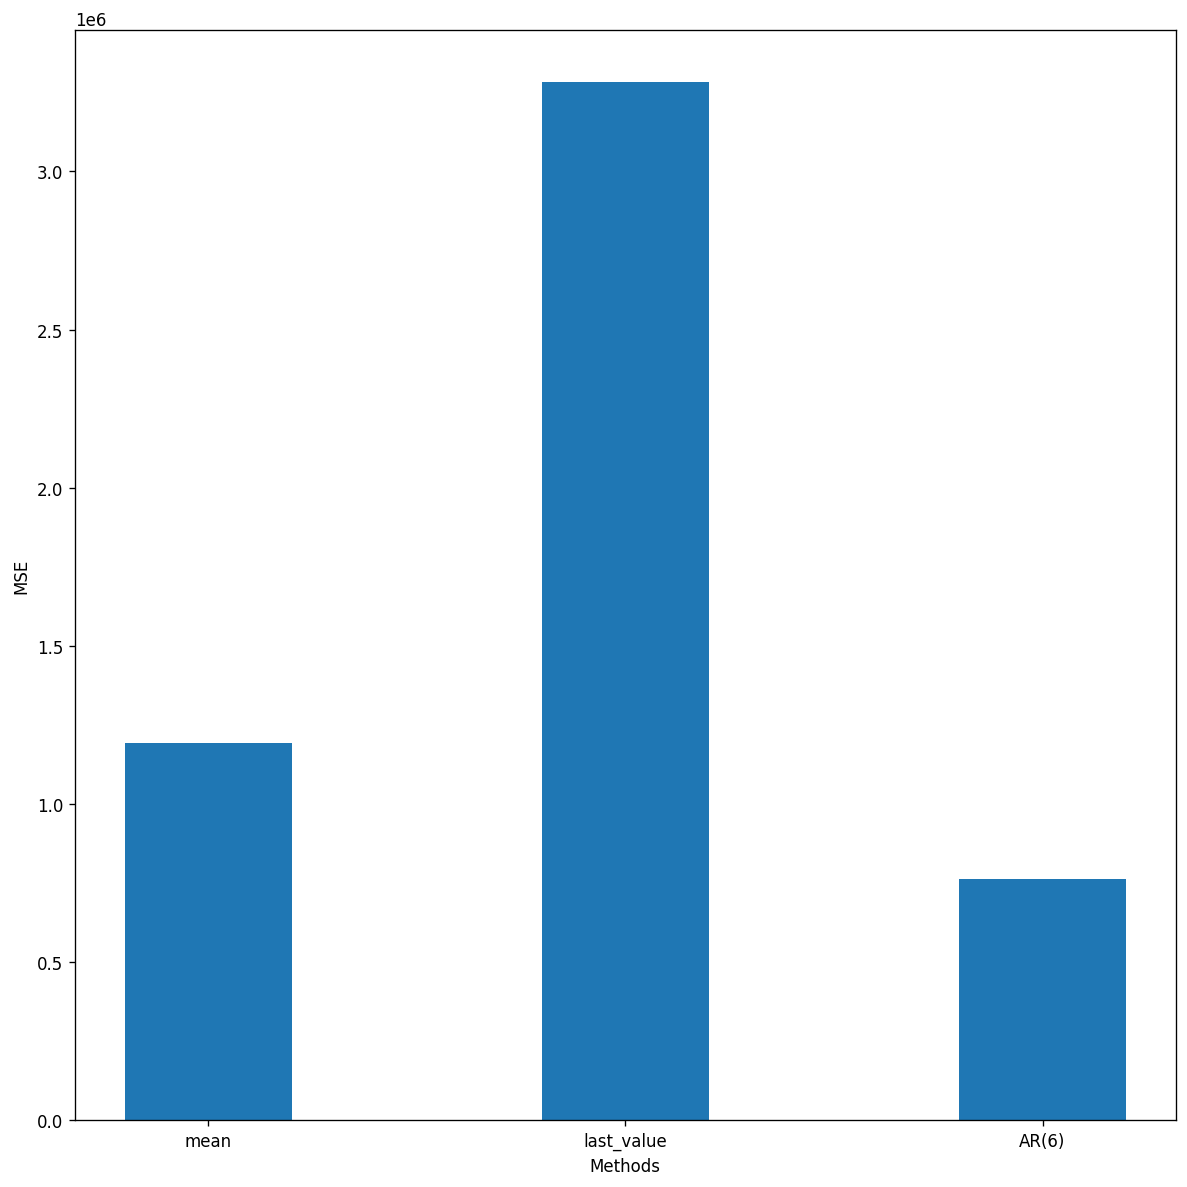

In [ ]:
#plot the mean squared error
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(6)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

plt.tight_layout()
plt.savefig('MSE', dpi=300)

AR has less error compared to the baseline models.

In [ ]:
#convert the predicted value into a series
df['pred_Turnover'] = pd.Series(dtype='float64')
#add the cumulative sume of predictions to the first value of our test set(i.e., last value of train set +1)
df['pred_Turnover'][473:] = df['Turnover'].iloc[473] + test['pred_AR'].cumsum()

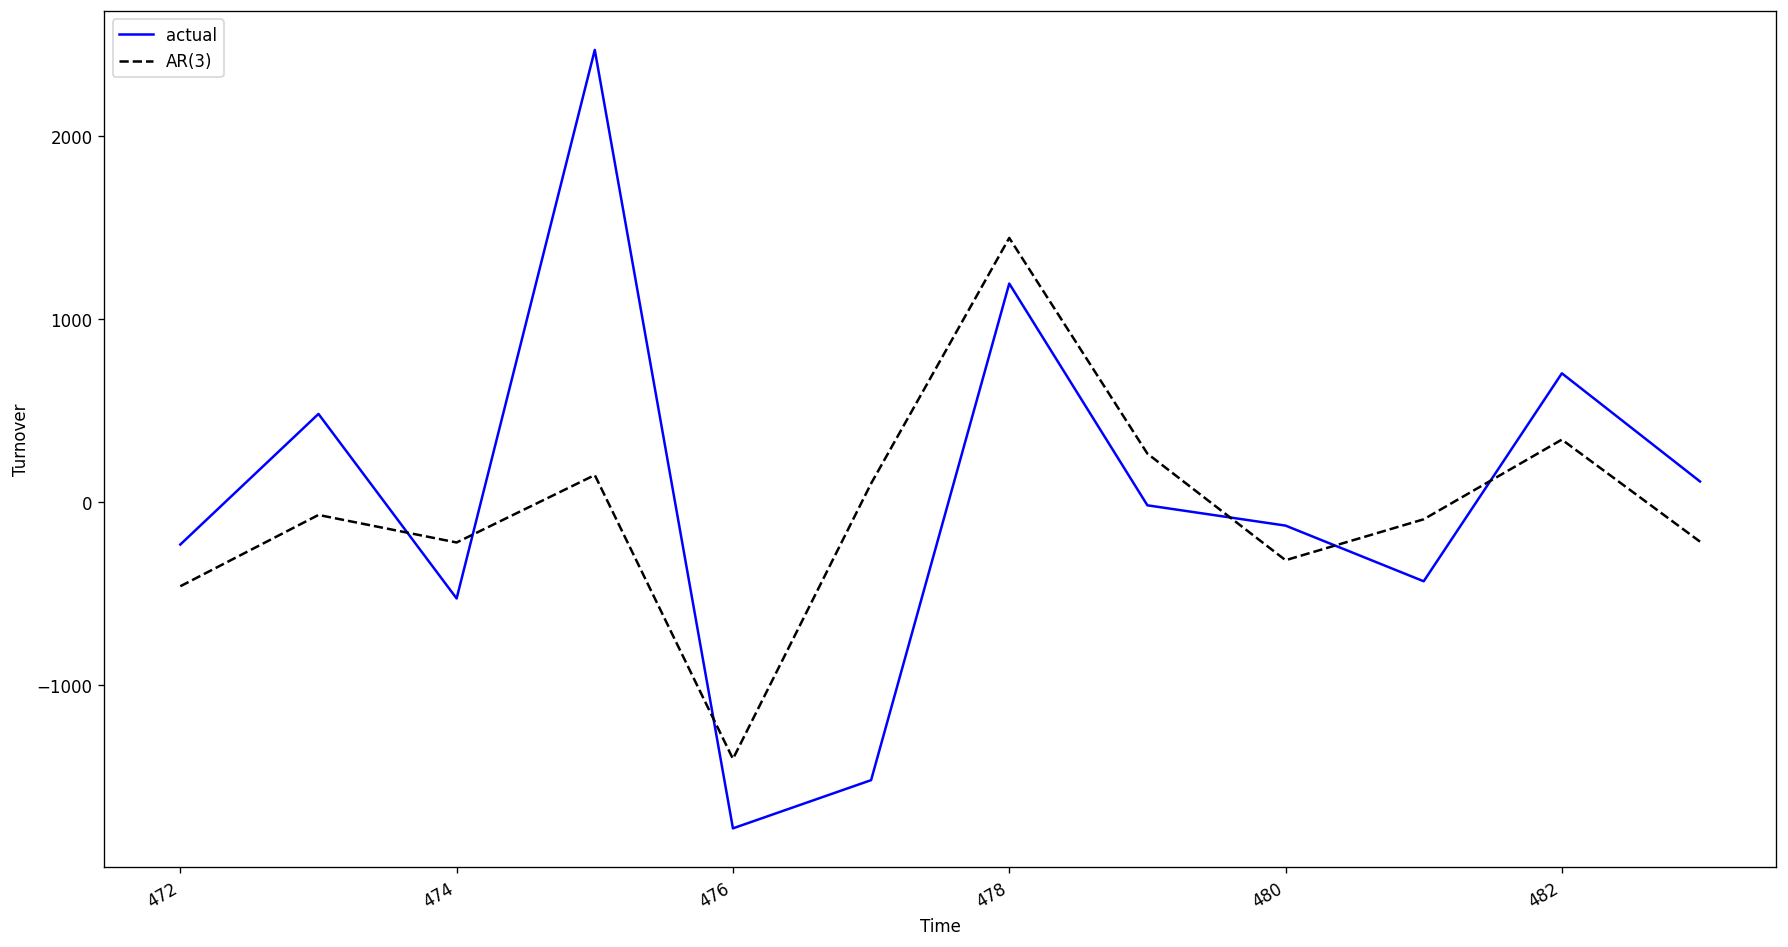

In [ ]:
#plot our adjusted prediction

fig, ax = plt.subplots()


ax.plot(test['fdiff'], 'b-', label='actual')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Turnover')


fig.set_size_inches(15,8)
fig.autofmt_xdate()
plt.tight_layout()

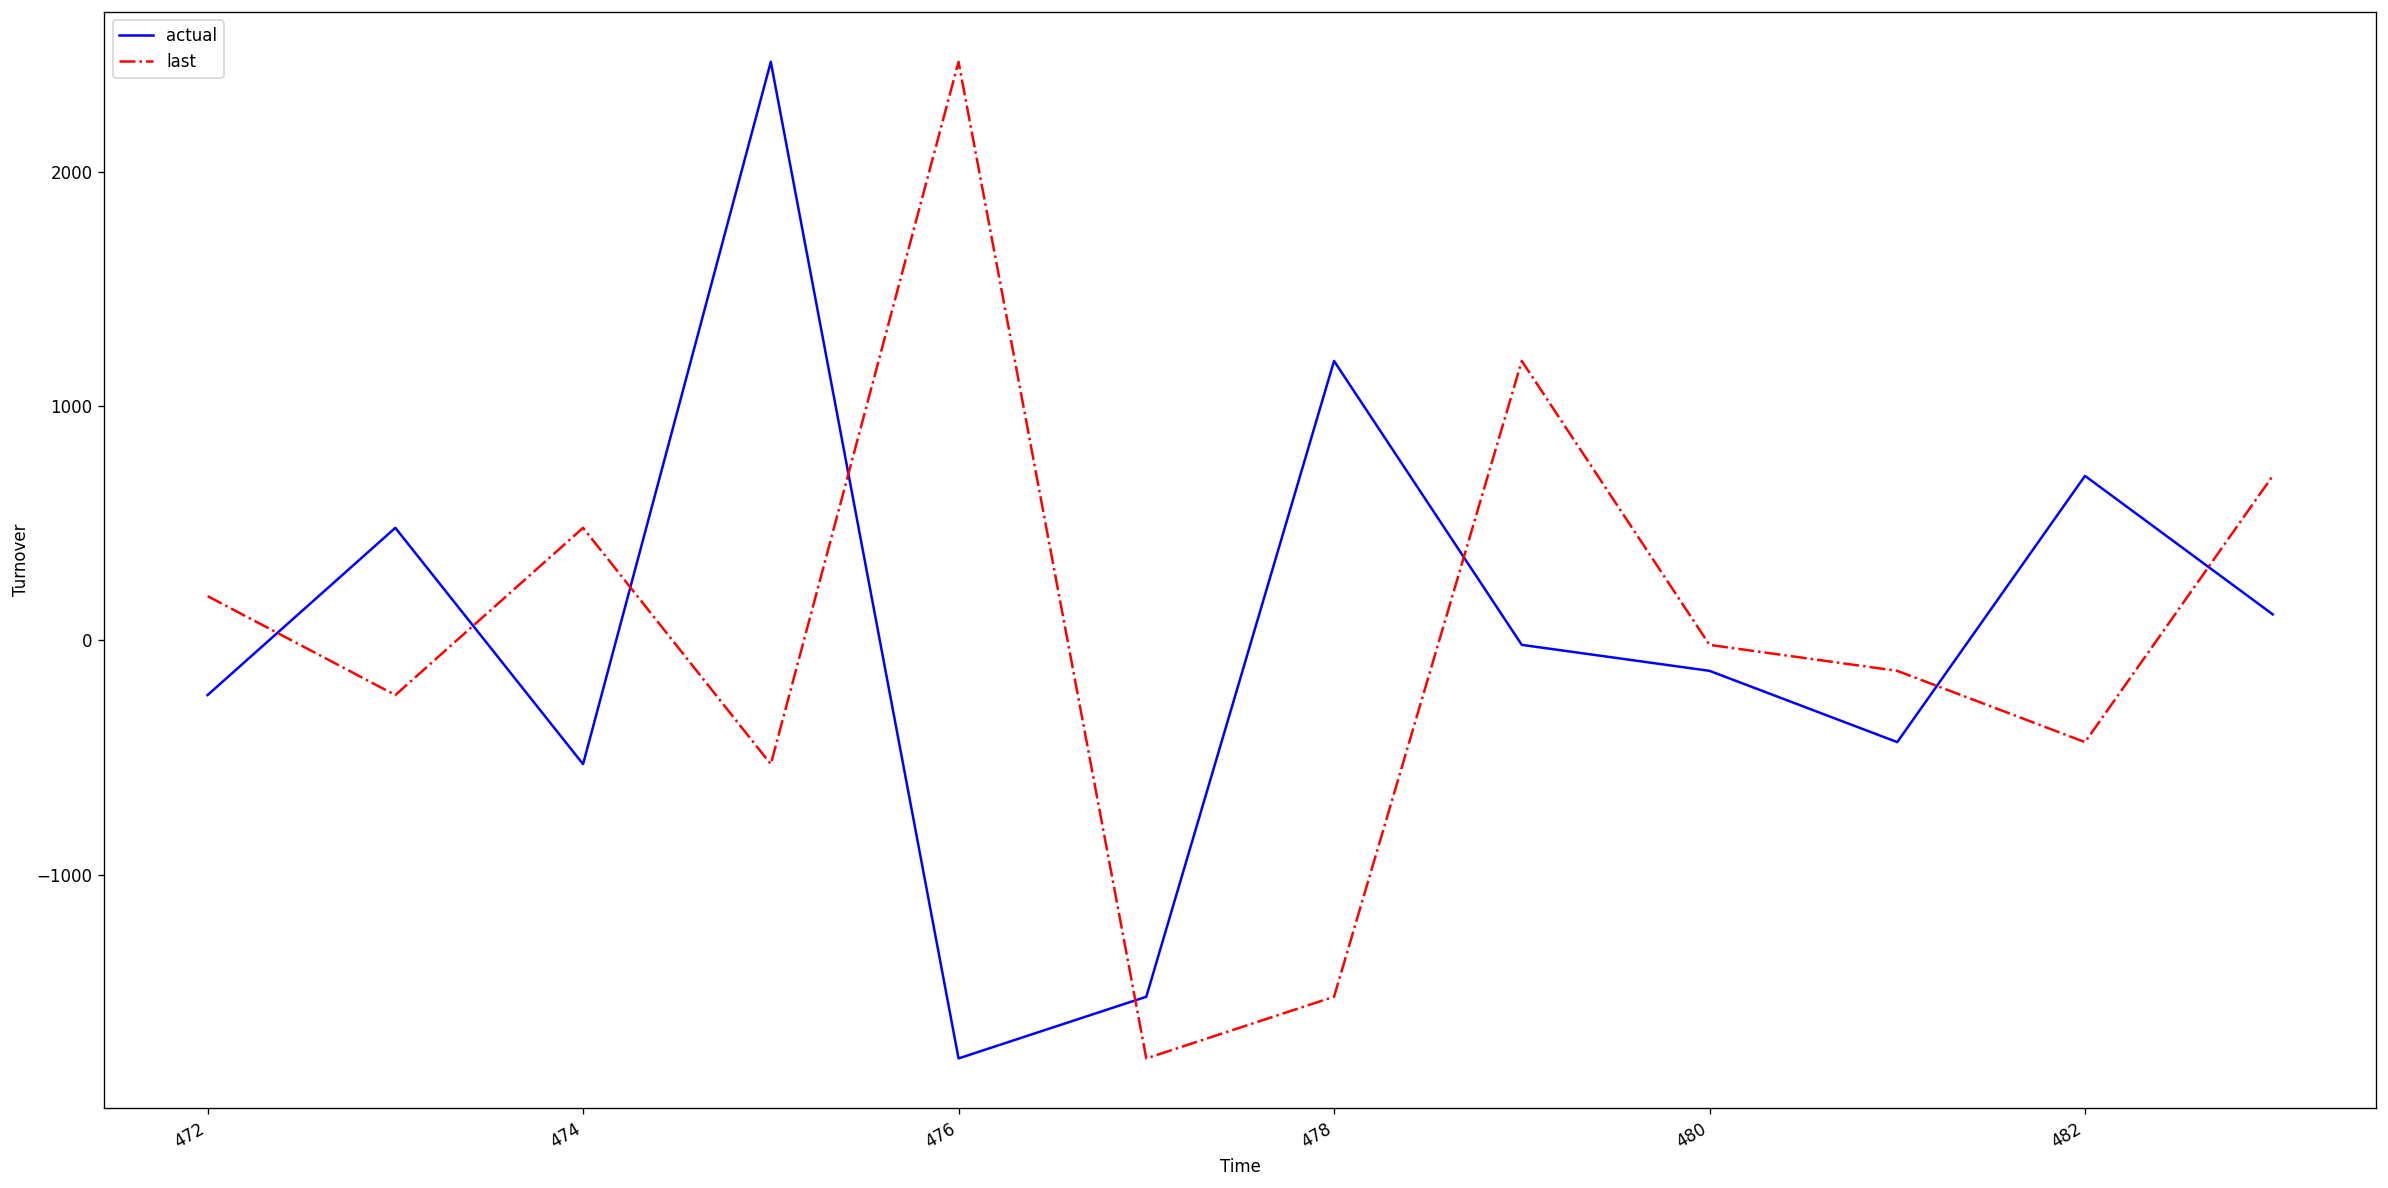

In [ ]:
#compare prediction

fig, ax = plt.subplots()


ax.plot(test['fdiff'], 'b-', label='actual')
ax.plot(test['pred_last_value'], 'r-.', label='last')


ax.legend(loc=2)

fig.set_size_inches(20,10)

ax.set_xlabel('Time')
ax.set_ylabel('Turnover')


fig.autofmt_xdate()
plt.tight_layout()

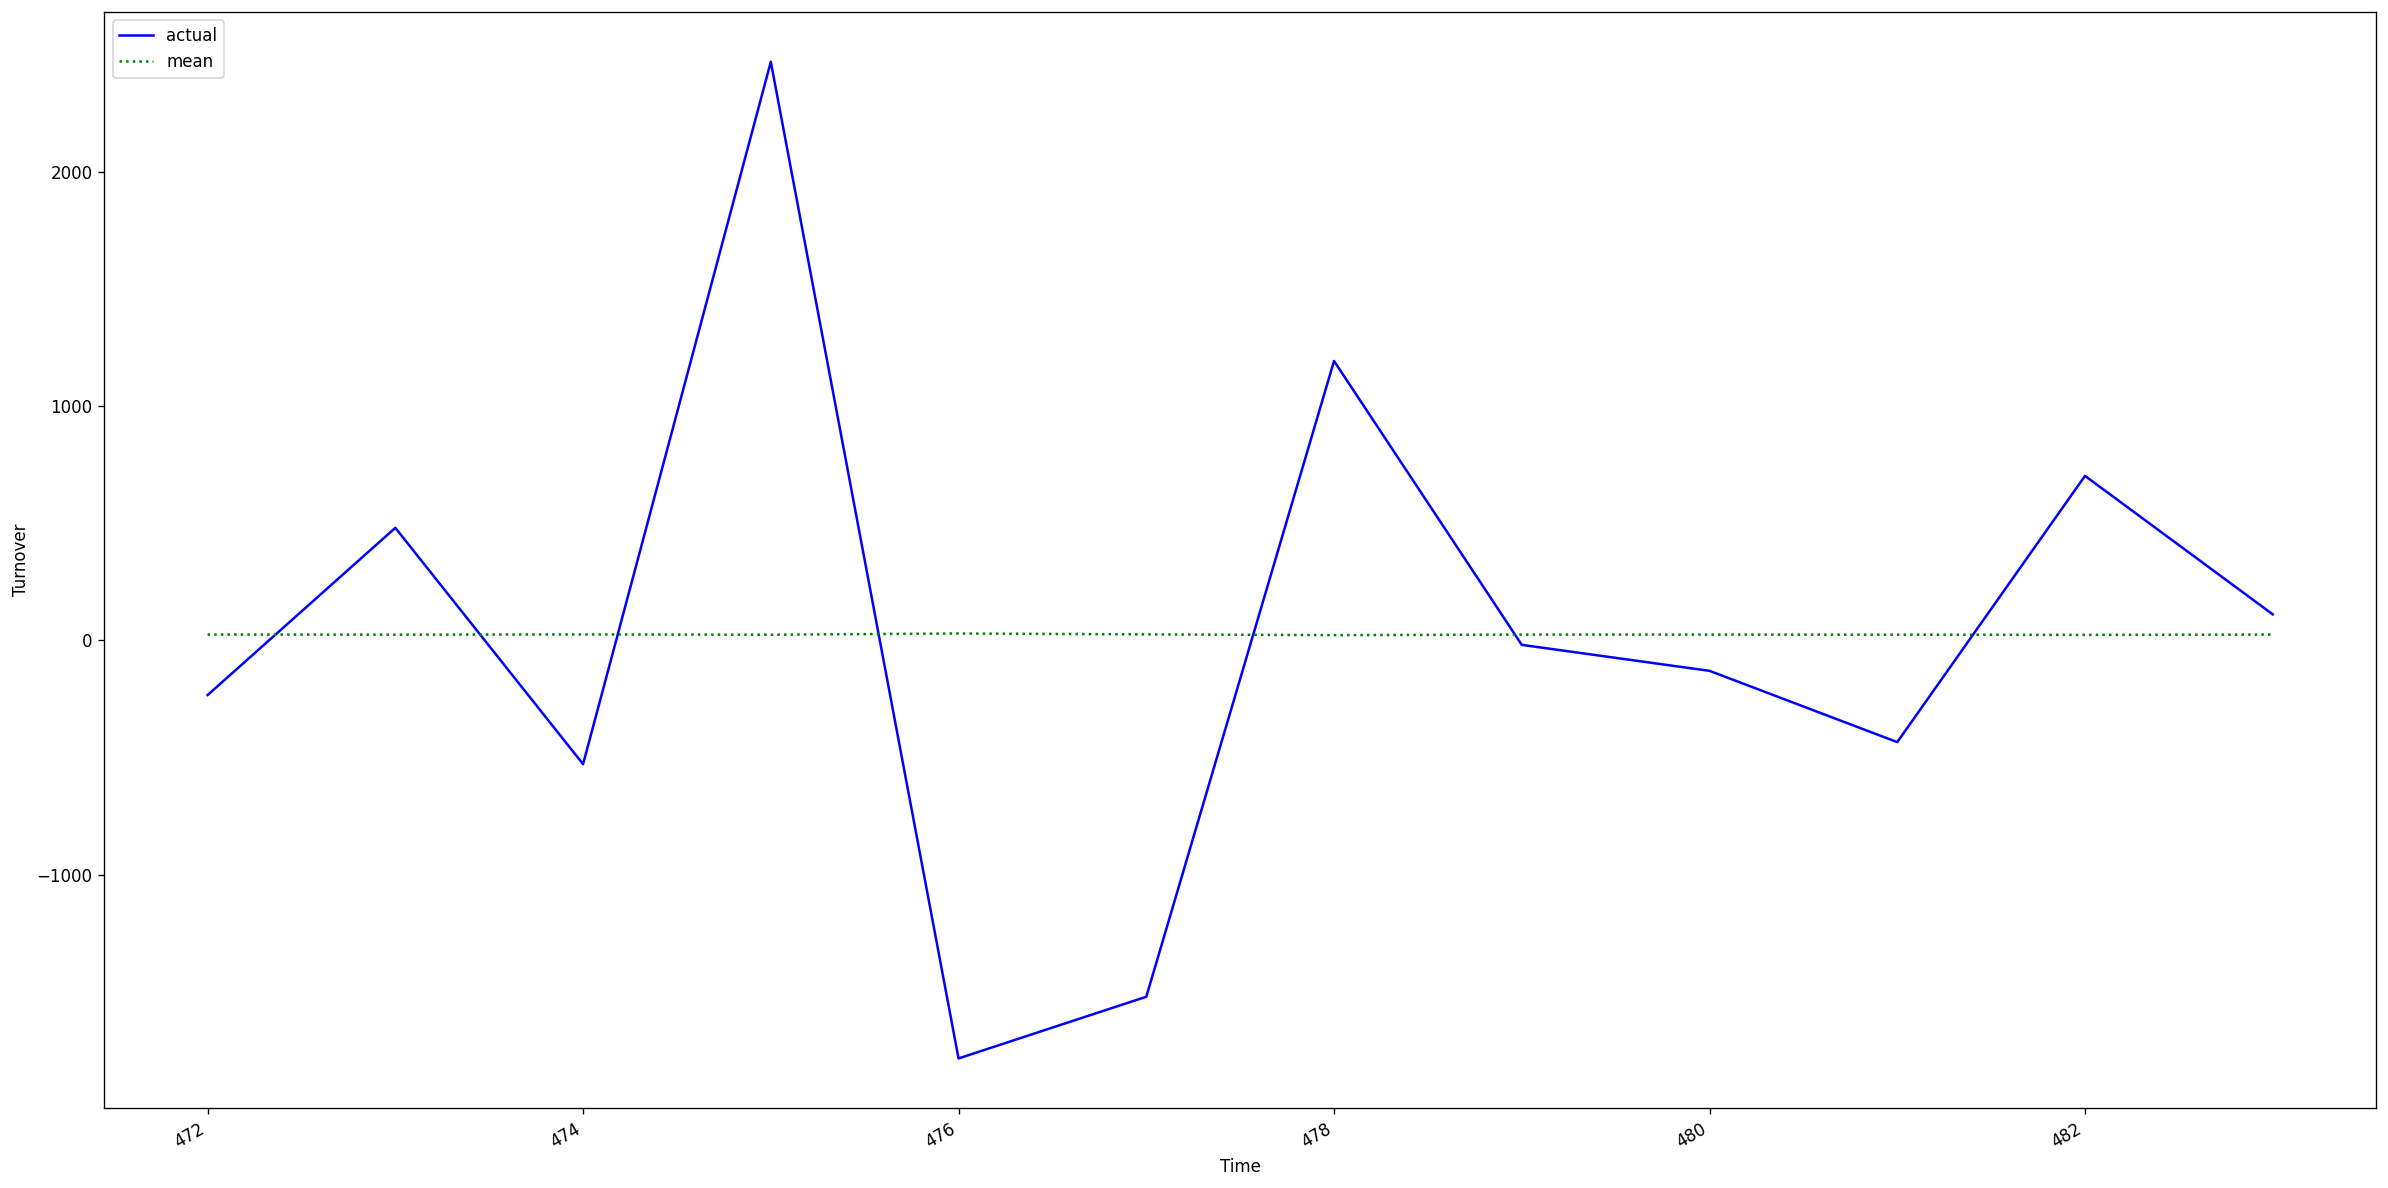

In [ ]:
#compare prediction
fig, ax = plt.subplots()


ax.plot(test['fdiff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')

ax.legend(loc=2)

fig.set_size_inches(20,10)

ax.set_xlabel('Time')
ax.set_ylabel('Turnover')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
#calculate error
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['Turnover'][473:], df['pred_Turnover'][473:])

print(mae_AR_undiff)

1079.4245541110029


The mean absolute error (MAE) of the pred_Turnover column compared to the Turnover column, starting from index 433, is 3069.8455.

This means that, on average, the pred_Turnover column is off by 3069.8455 units from the actual Turnover column.

In other words, if you use the pred_Turnover column to predict the actual Turnover value, you can expect to be off by an average of 3069.8455 units.

This error value can be used to assess the accuracy of the model that generated the pred_Turnover column.

The error value can be used to assess the accuracy of the model by comparing it to other error values or to a benchmark.

1. Comparing to other error values:

You can compare the MAE value of 3069.8455 to the MAE values of other models that have been used to predict the same data. If the MAE value of 3069.8455 is lower than the MAE values of other models, then it suggests that the model that generated the pred_Turnover column is more accurate.

2. Comparing to a benchmark:

You can also compare the MAE value of 3069.8455 to a benchmark, such as the average difference between the actual values in the Turnover column. If the MAE value of 3069.8455 is lower than the benchmark, then it suggests that the model that generated the pred_Turnover column is accurate.

3. Interpretation in context:

The interpretation of the error value also depends on the context of the problem. For example, if the Turnover values are typically very large, then an MAE of 3069.8455 might be considered to be small. However, if the Turnover values are typically small, then an MAE of 3069.8455 might be considered to be large.

Overall, the MAE value of 3069.8455 can be used to assess the accuracy of the model that generated the pred_Turnover column by comparing it to other error values or to a benchmark. The interpretation of the error value should also take into account the context of the problem.

If the turnover value is typically 1162.6, then an MAE of 3069.8455 would be considered to be large. This is because the error value is more than twice the size of the typical turnover value.

In other words, if you use the pred_Turnover column to predict the actual Turnover value, you can expect to be off by an average of more than twice the typical turnover value.

This suggests that the model that generated the pred_Turnover column is not very accurate. You may want to consider using a different model or improving the current model.

In [ ]:
percentage_error = (MAE / turnover_value) * 100

In [ ]:
percentage_error = (1070.56 / 1162.6) * 100
percentage_error

92.08326165491141

Therefore, an MAE of 1070.56 would be considered to be very high in relation to a typical turnover value of 1162.6, as the percentage error is 92.13%. This means that the model's predictions are, on average, 92.13% off from the actual values.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('FoodRetailTurnover.csv', parse_dates=['Date'])

# ADF Test
result = adfuller(df.Turnover.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.Turnover.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.7513074217909343
p-value: 1.0
Critial Values:
   1%, -3.4444609168389615
Critial Values:
   5%, -2.8677622536920317
Critial Values:
   10%, -2.5700842229549266

KPSS Statistic: 3.739330
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


the data is not stationary.
ADF Test:
The ADF statistic (3.7513074217909343) is greater than the critical values at all significance levels (1%, 5%, and 10%).
This means we fail to reject the null hypothesis that the data is non-stationary.
KPSS Test:
The KPSS statistic (3.739330) is greater than the critical values at all significance levels (1%, 2.5%, 5%, and 10%).
This means we reject the null hypothesis that the data is stationary.
Therefore, based on both tests, we can conclude that the data is non-stationary.

Change the values in the code and experiment, and see how the results change.

Reflect on the principles of responsible AI: did you process the data to remove bias? what can you say about the transparency of the algorithm?

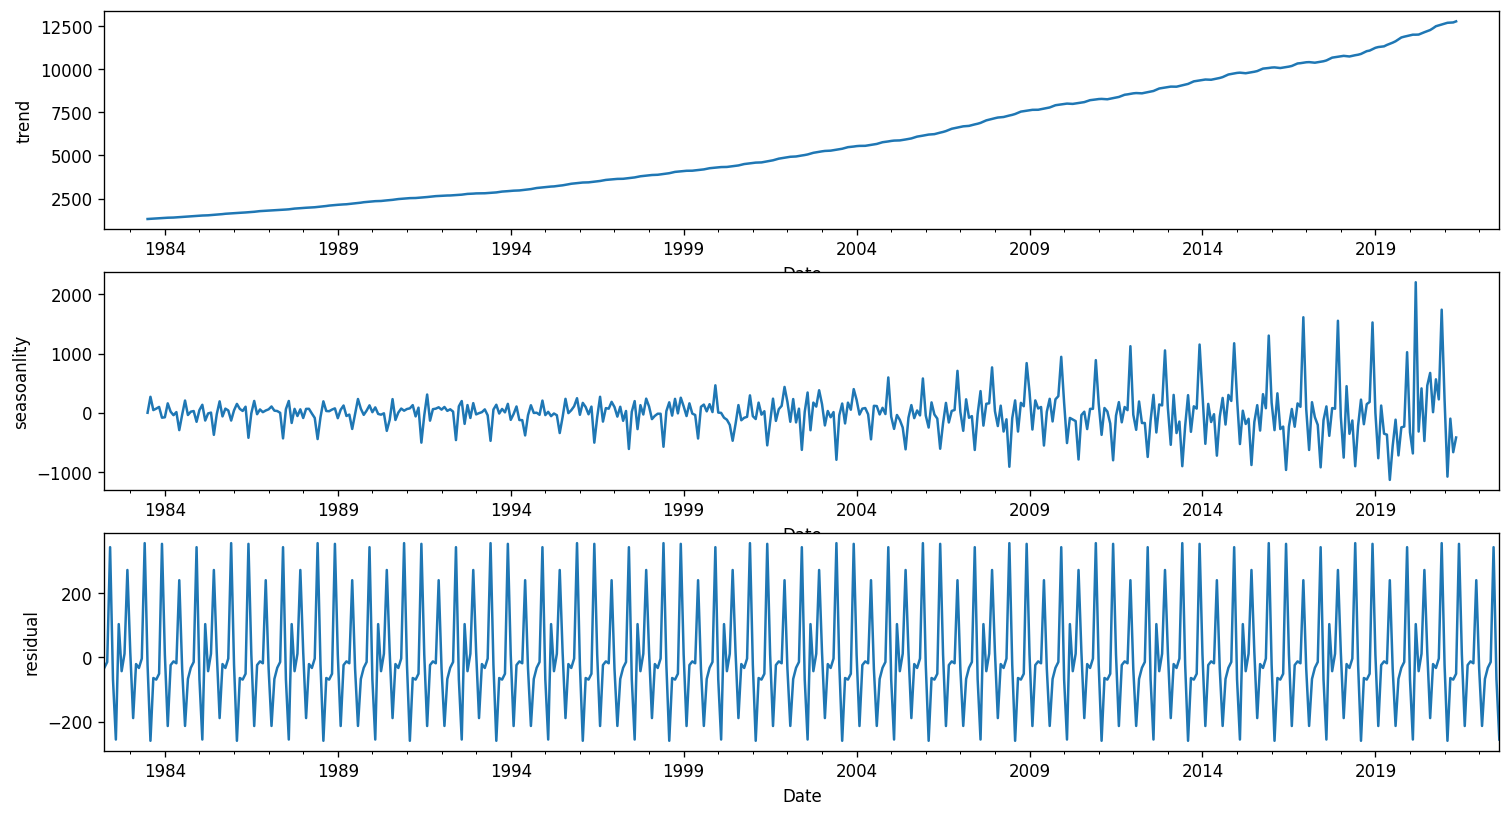

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

Auto regression for Transformed data

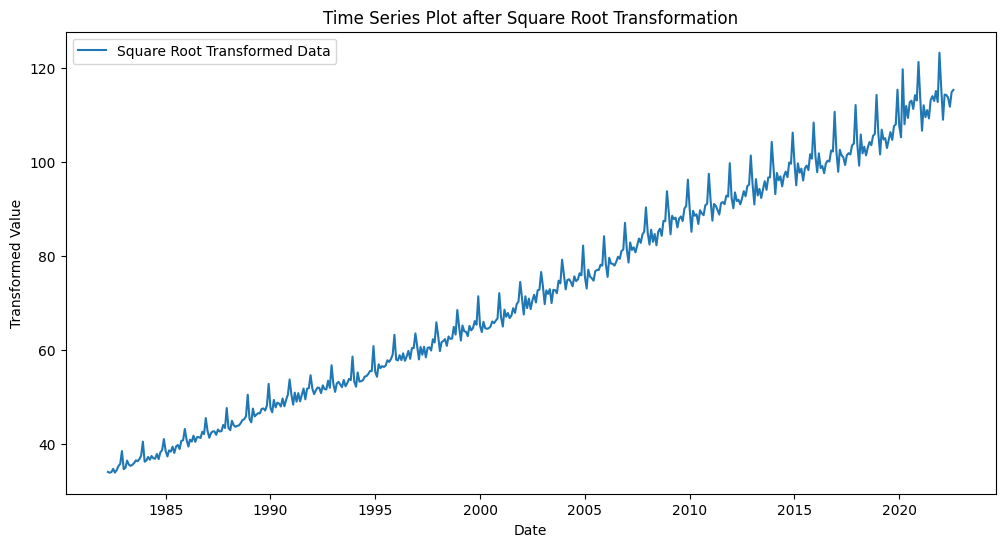

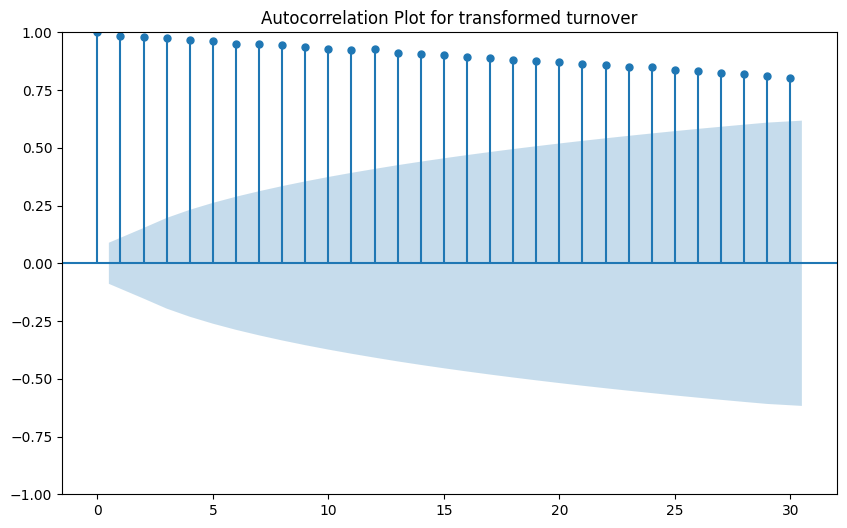

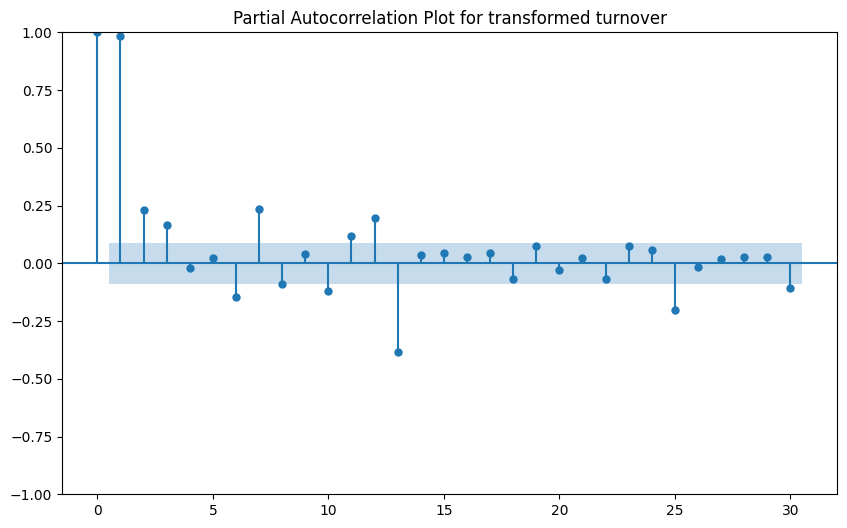

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Best AR Order based on AIC: 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     transformedTurnover   No. Observations:                  485
Model:                 ARIMA(10, 0, 0)   Log Likelihood               -1053.756
Date:                 Sun, 04 Feb 2024   AIC                           2131.511
Time:                         03:56:24   BIC                           2181.721
Sample:                     04-01-1982   HQIC                          2151.239
                          - 08-01-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.5191     38.911      1.864      0.062      -3.745     148.783
ar.L1          0.5309      0.043     12.407      0.000       0.447       0.615
ar.L2         -0.0876      0.043     -2.016 

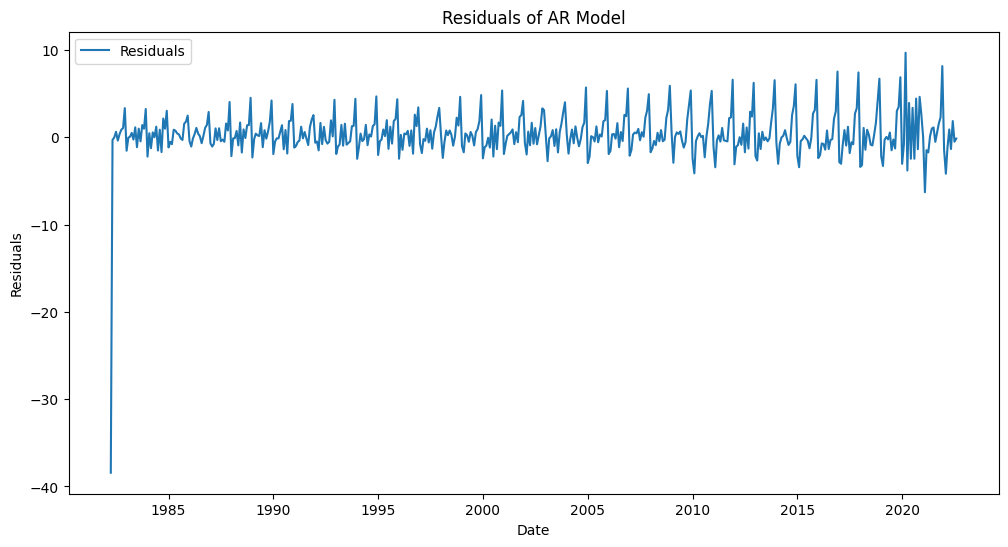

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import acf, pacf, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tDf['transformedTurnover'], label='Square Root Transformed Data')
plt.title('Time Series Plot after Square Root Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.show()

# Autocorrelation and Partial Autocorrelation Plots
plot_acf(tDf['transformedTurnover'], lags=30, title='Autocorrelation Plot for transformed turnover')
plot_pacf(tDf['transformedTurnover'], lags=30, title='Partial Autocorrelation Plot for transformed turnover')
plt.show()

# Determine the order of AR model using AIC
order_selection = []
for p in range(1, 11):
    model = ARIMA(tDf['transformedTurnover'], order=(p, 0, 0))
    results = model.fit()
    order_selection.append((p, results.aic))

# Find the order with the lowest AIC
best_order = min(order_selection, key=lambda x: x[1])
print(f"Best AR Order based on AIC: {best_order[0]}")

# Fit the AR model with the best order
ar_model = ARIMA(tDf['transformedTurnover'], order=(best_order[0], 0, 0))
ar_results = ar_model.fit()

# Print summary of the AR model
print(ar_results.summary())

# Plot the residuals
residuals = ar_results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of AR Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

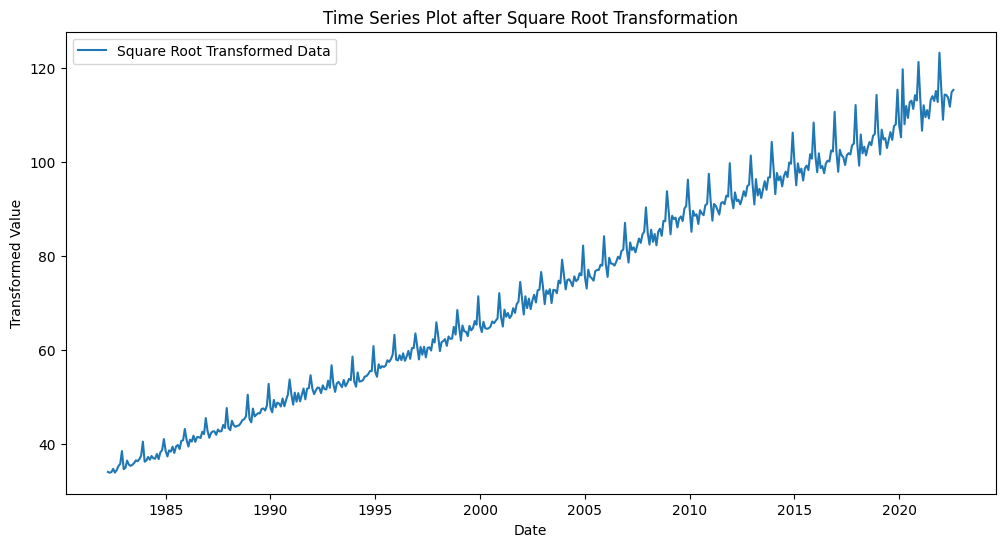

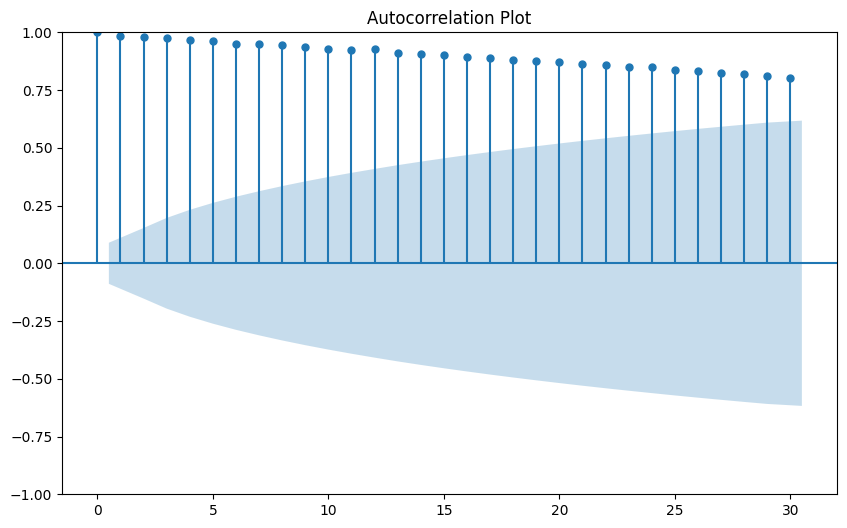

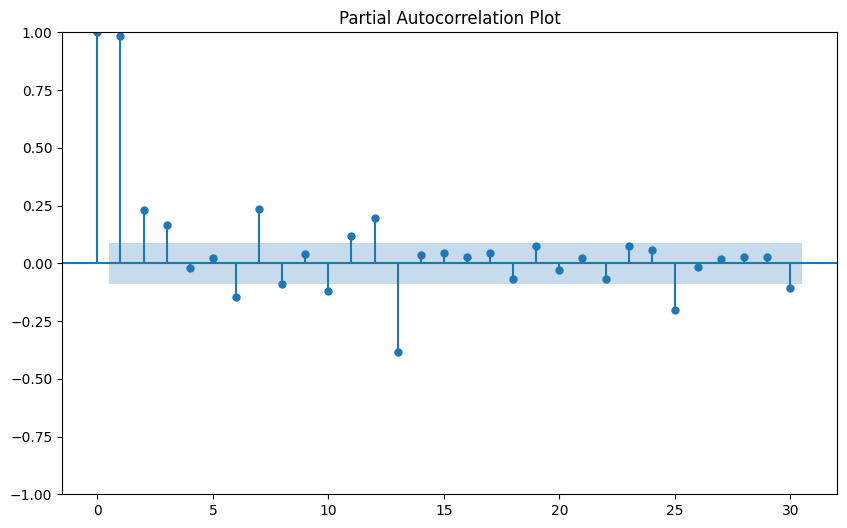

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     transformedTurnover   No. Observations:                  485
Model:               SARIMAX(10, 0, 0)   Log Likelihood               -1066.683
Date:                 Sun, 04 Feb 2024   AIC                           2155.365
Time:                         04:05:06   BIC                           2201.391
Sample:                     04-01-1982   HQIC                          2173.449
                          - 08-01-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4988      0.045     11.163      0.000       0.411       0.586
ar.L2         -0.0221      0.041     -0.545      0.586      -0.102       0.057
ar.L3          0.4557      0.056      8.141 

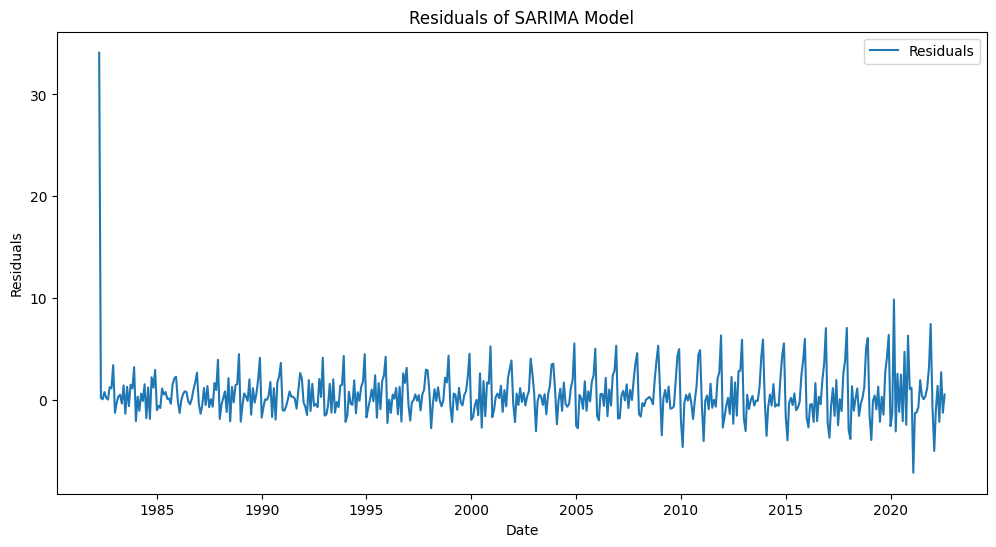

In [ ]:
# Explicitly set the frequency
tDf.index.freq = 'MS'  # Assuming monthly frequency, adjust as needed

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(tDf['transformedTurnover'], label='Square Root Transformed Data')
plt.title('Time Series Plot after Square Root Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.show()

# Autocorrelation and Partial Autocorrelation Plots
plot_acf(tDf['transformedTurnover'], lags=30, title='Autocorrelation Plot')
plot_pacf(tDf['transformedTurnover'], lags=30, title='Partial Autocorrelation Plot')
plt.show()

# Fit SARIMA model
order = (10, 0, 0)  # Adjust order as needed
model = SARIMAX(tDf['transformedTurnover'], order=order)
results = model.fit()

# Print summary of the SARIMA model
print(results.summary())

# Plot the residuals
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(tDf)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 1.2785919328501825
p-value: 0.9964863390905532


the p-value is much higher than 0.05, specifically 0.996. This suggests that you do not have enough evidence to reject the null hypothesis of non-stationarity. Therefore, based on the ADF test, your time series may not be stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss

result = kpss(tDf)
print('KPSS Statistic:', result[0])
print('p-value:', result[1])


KPSS Statistic: 3.832587720827761
p-value: 0.01


<ipython-input-123-542d25a50d00>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(tDf)


the p-value is 0.01, which is less than 0.05. Therefore, you reject the null hypothesis of stationarity, indicating that the time series may not be stationary according to the KPSS test.

In [ ]:
tDf.head()

transformedTurnover
date                           
1982-04-01            34.096921
1982-05-01            33.924917
1982-06-01            34.058773
1982-07-01            34.733269
1982-08-01            33.948490

In [ ]:
tDf.tail()

transformedTurnover
date                           
2022-04-01           114.164355
2022-05-01           113.594014
2022-06-01           111.667363
2022-07-01           114.767156
2022-08-01           115.250163

Make it stationary ********************

In [ ]:
#transform data
fdiff = np.diff(tDf['transformedTurnover'], n=1)   #Ok

In [ ]:
# ADF Test   Ok
adf_result = adfuller(fdiff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -6.411979532646146
p-value: 1.8810202569746408e-08


 based on the ADF test, ther differenced time series (fdiff) is stationary.

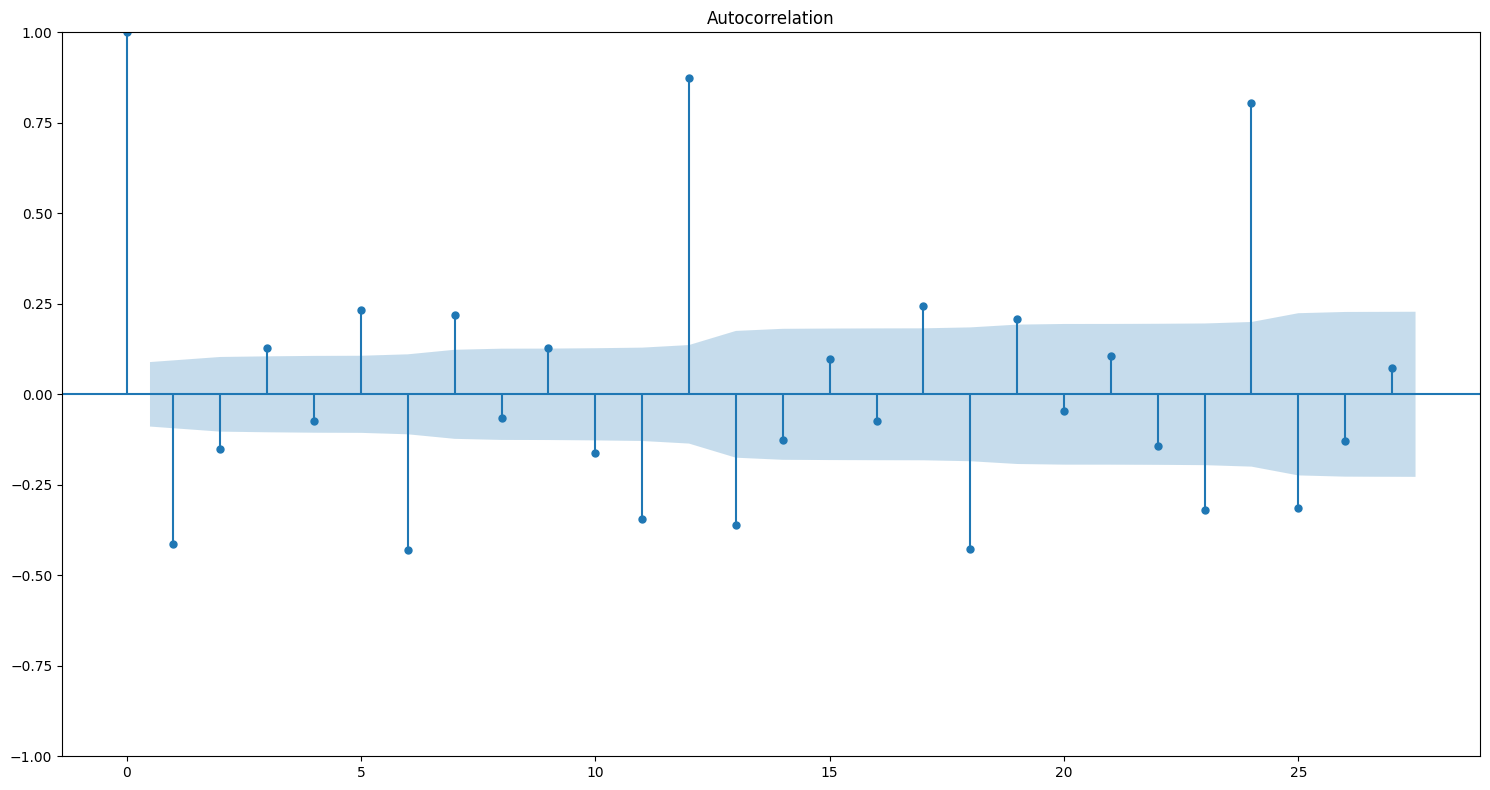

In [ ]:
# the number of lags determine the range of values on the x-axis , we will use the default lag
fig = plot_acf(fdiff);
# changing it's width and height
fig.set_size_inches(15,8)
plt.tight_layout()


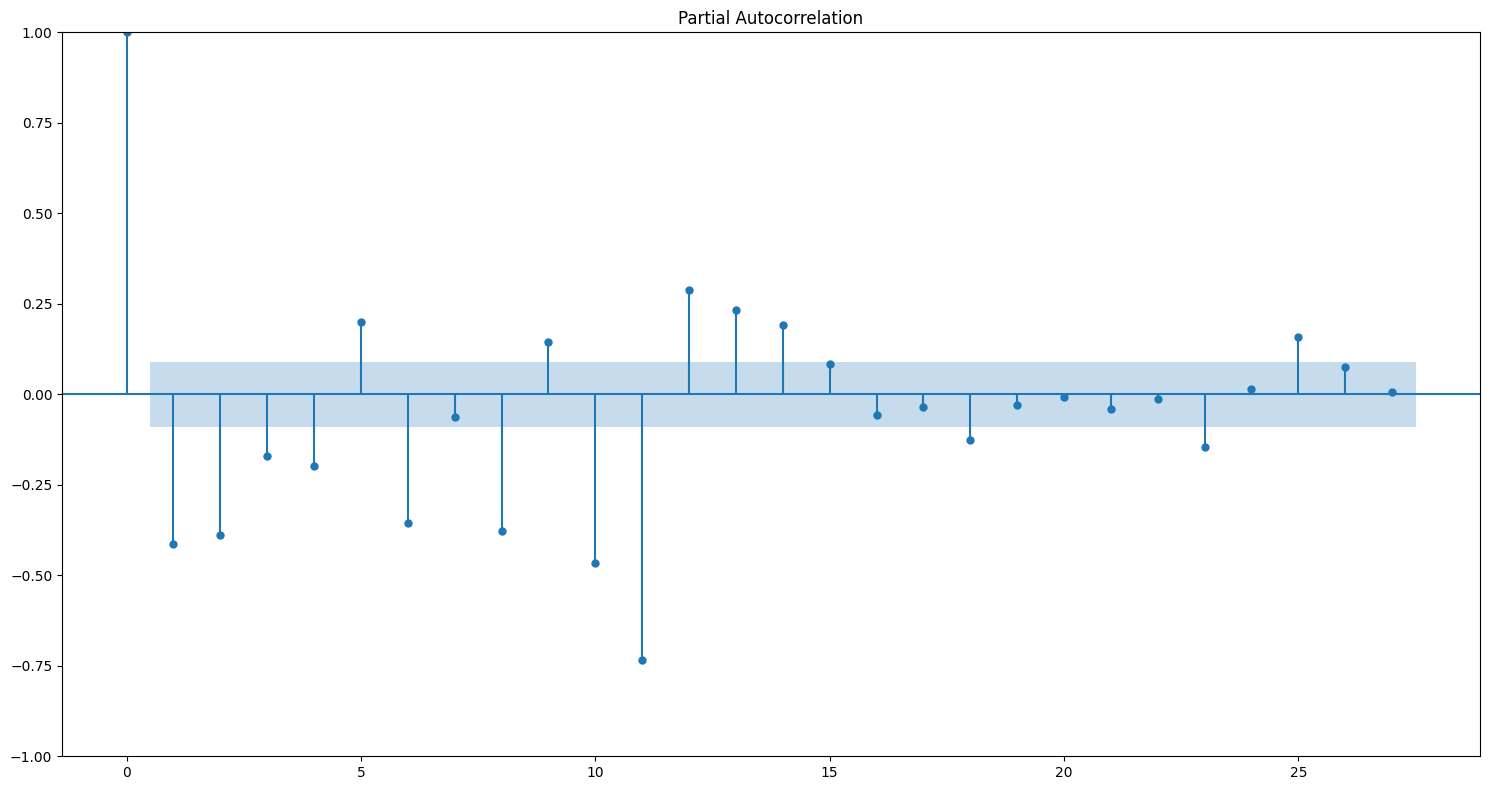

In [ ]:
#let's plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(fdiff)
fig.set_size_inches(15,8)


plt.tight_layout()

plt.savefig('fpacf', dpi=300)

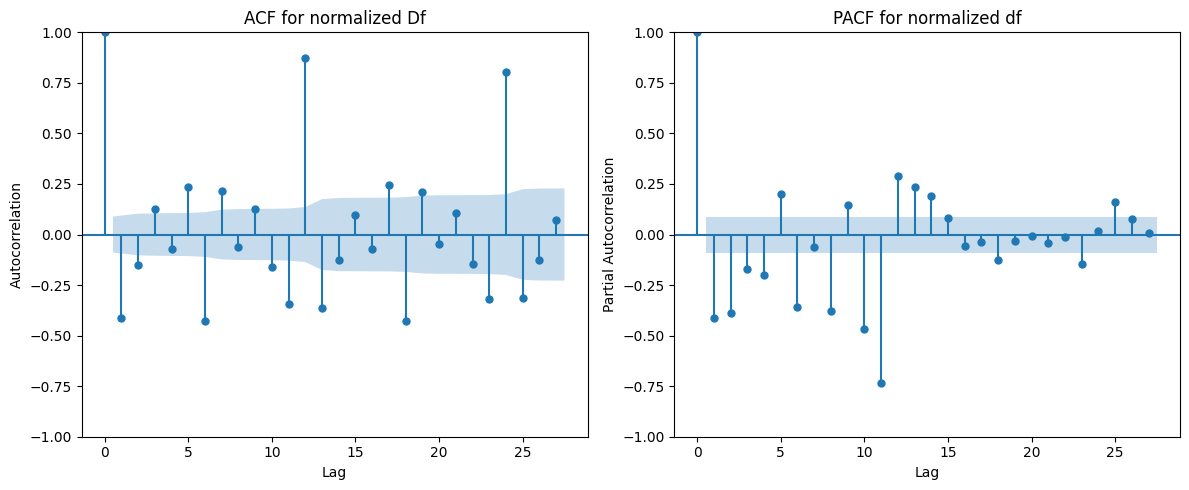

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the ACF for the first DataFrame
pacf_values_tDf = plot_acf(fdiff, ax=axs[0])
axs[0].set_title('ACF for normalized Df')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')

# Plot the PACF for the second DataFrame
pacf_values_df = plot_pacf(fdiff, ax=axs[1])
axs[1].set_title('PACF for normalized df')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


Train the ARIMA Model:

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


**#################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################Begin Here################################################**

***The main and completed solution begins from here.***
- Analyse actual data
- Analyse normalised data
- Analysed transformed data using diffrences
- Analyse transformed data using box-cox

In [ ]:
df= pd.read_csv("FoodRetailTurnover.csv")
df.head()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      485 non-null    object 
 1   Turnover  485 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB


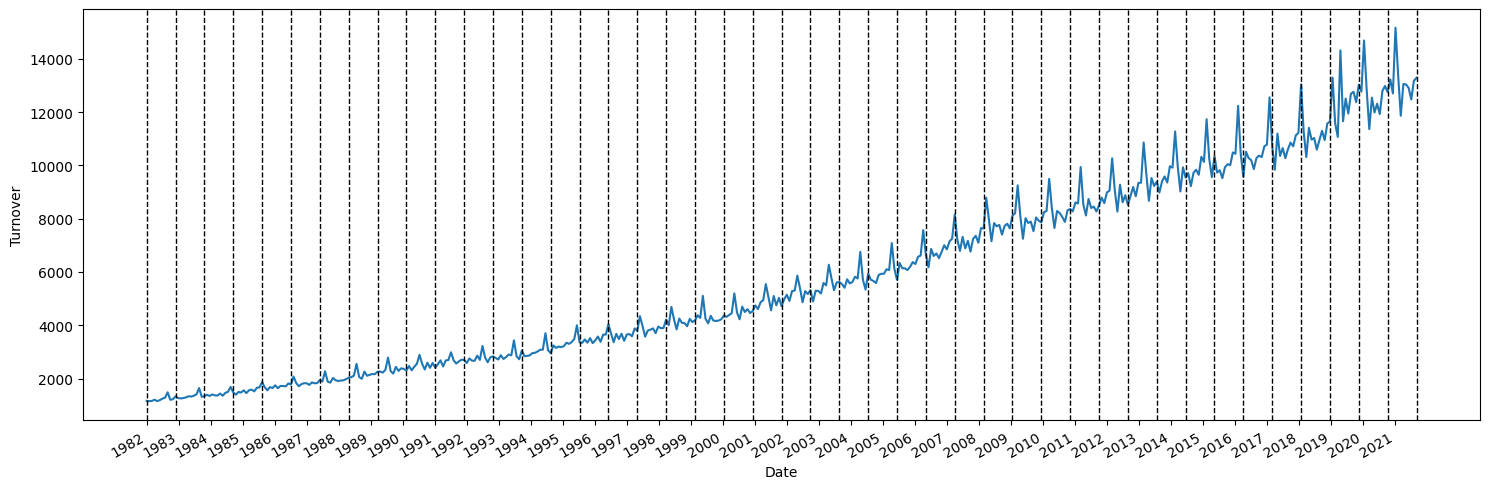

In [10]:
# show the seasonal cycle

fig, ax = plt.subplots()

ax.plot(df['Date'], df['Turnover'])
for i in np.arange(0, 485, 11):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Turnover')

plt.xticks(np.arange(0, 485, 12.2), np.arange(1982, 2022, 1))


fig.set_size_inches(15,5)
fig.autofmt_xdate()
plt.tight_layout()

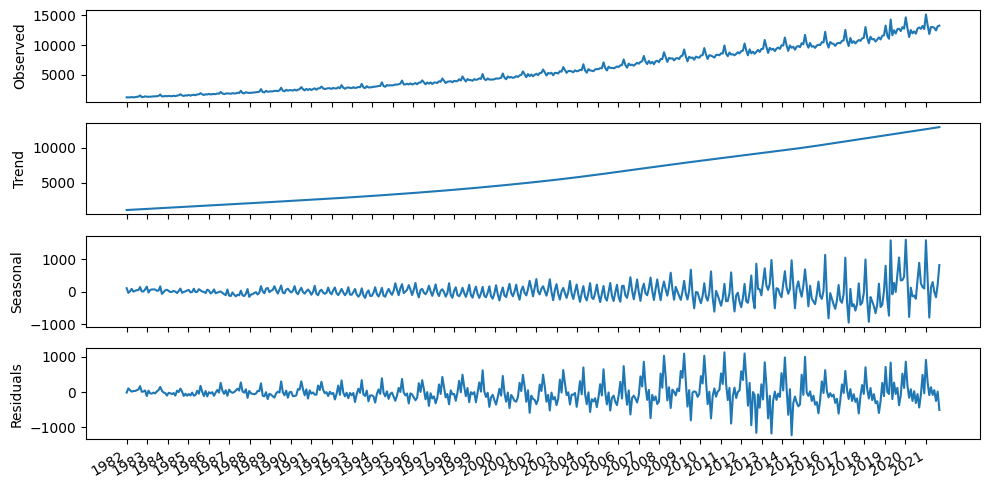

In [11]:
#another way to clearly see hte seasonality is to divide by the components
decomposition = STL(df['Turnover'], period=80).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 485, 12.2), np.arange(1982, 2022, 1))
fig.set_size_inches(10,5)
fig.autofmt_xdate()
plt.tight_layout()

In [12]:
df['date'] = pd.to_datetime(df['Date'])
df.head()

Date  Turnover       date
0  Apr-1982    1162.6 1982-04-01
1  May-1982    1150.9 1982-05-01
2  Jun-1982    1160.0 1982-06-01
3  Jul-1982    1206.4 1982-07-01
4  Aug-1982    1152.5 1982-08-01

In [13]:
df = df.set_index(['date'])
df.head()

Date  Turnover
date                          
1982-04-01  Apr-1982    1162.6
1982-05-01  May-1982    1150.9
1982-06-01  Jun-1982    1160.0
1982-07-01  Jul-1982    1206.4
1982-08-01  Aug-1982    1152.5

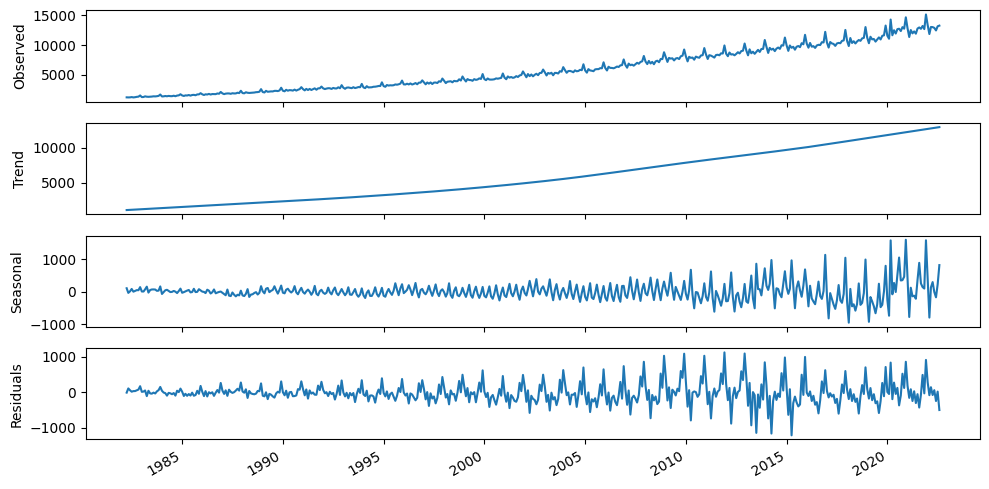

In [14]:
#another way to clearly see hte seasonality is to divide by the components
decomposition = STL(df['Turnover'], period=80).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.set_size_inches(10,5)
fig.autofmt_xdate()
plt.tight_layout()

In [15]:
from scipy.stats import shapiro

# using shapiro to check normality
stat, p_value = shapiro(df['Turnover'])

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The data is not normally distributed.')
else:
    print('The data appears to be normally distributed.')

Shapiro-Wilk Statistic: 0.9279984831809998
p-value: 1.6600947911260197e-14
The data is not normally distributed.


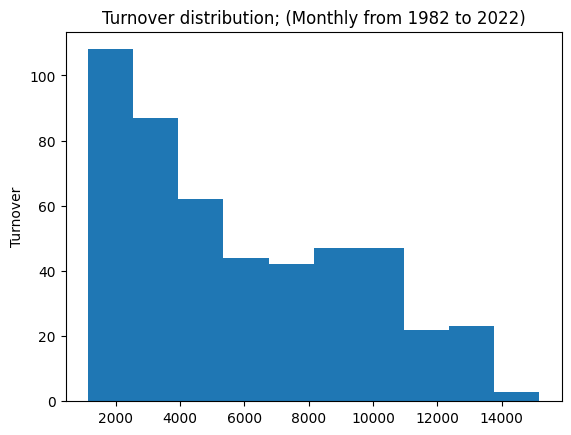

In [16]:
#let see how the distribution looks like...
# Plot
plt.hist(df["Turnover"])

# Labelling
plt.ylabel("Turnover")
plt.title("Turnover distribution; (Monthly from 1982 to 2022)")

# Display
plt.show()

In [17]:
import pandas as pd
from scipy.stats import boxcox

# Assuming 'df' is your existing DataFrame with a column named "Turnover"
# Add the transformed data as a new column named 'transformedTurnover'
df['transformedTurnover'], lmbda = boxcox(df["Turnover"])
df.head()

Date  Turnover  transformedTurnover
date                                               
1982-04-01  Apr-1982    1162.6            19.497484
1982-05-01  May-1982    1150.9            19.437828
1982-06-01  Jun-1982    1160.0            19.484266
1982-07-01  Jul-1982    1206.4            19.716902
1982-08-01  Aug-1982    1152.5            19.446013

Shapiro-Wilk Statistic: 0.9559227228164673
p-value: 7.413952091139819e-11
The transformed data is not normally distributed.


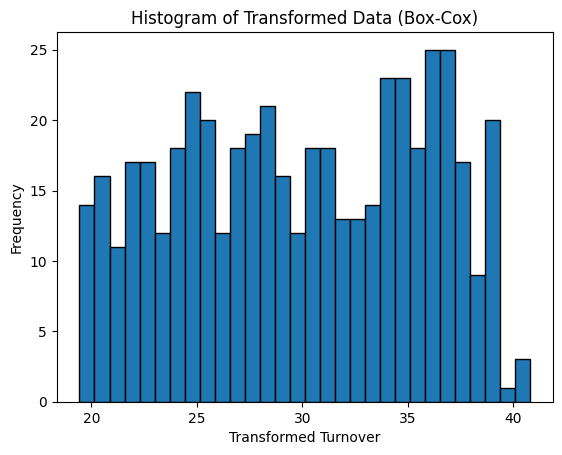

In [18]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Assuming 'transformedTurnover' is the transformed data
stat, p_value = shapiro(df['transformedTurnover'])

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The transformed data is not normally distributed.')
else:
    print('The transformed data appears to be normally distributed.')

# Plot the histogram of the transformed data
plt.hist(df['transformedTurnover'], bins=30, edgecolor='black')
plt.title('Histogram of Transformed Data (Box-Cox)')
plt.xlabel('Transformed Turnover')
plt.ylabel('Frequency')
plt.show()

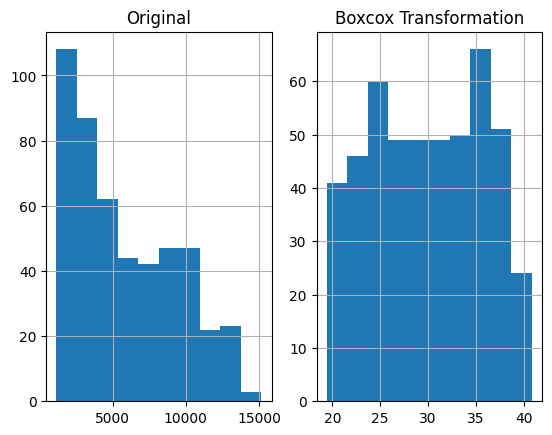

In [19]:
#plot histogram
fig, ax = plt.subplots(1, 2)

df['Turnover'].hist(ax=ax[0])

df['transformedTurnover'].hist(ax=ax[1])


# Labelling
ax[0].set_title("Original")
ax[1].set_title("Boxcox Transformation")

plt.show()

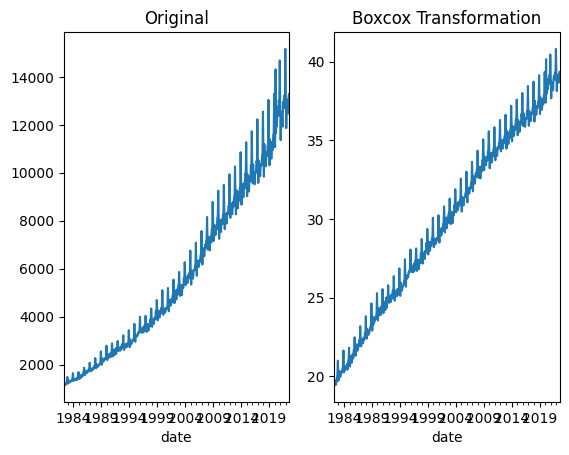

In [20]:
#let us see how  the datasets look like before and after the transformation
# there will be two plots
fig, ax = plt.subplots(1, 2)

#original plot of data set
df['Turnover'].plot(ax=ax[0])

# plot of the transformed data set
df['transformedTurnover'].plot(ax=ax[1])

# Labelling
ax[0].set_title("Original")
ax[1].set_title("Boxcox Transformation")

plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

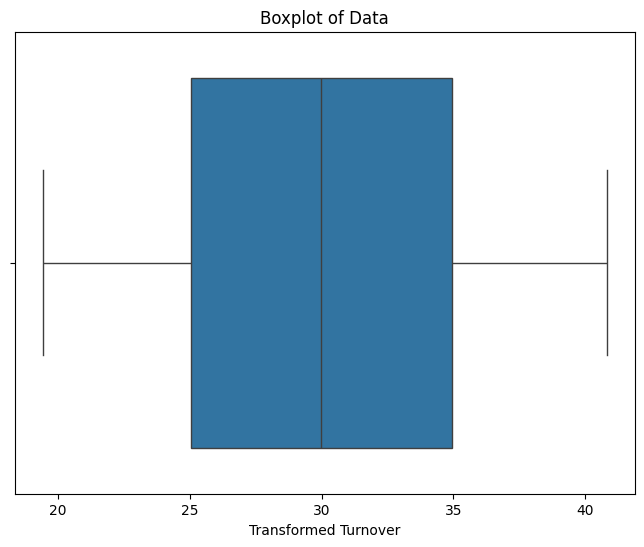

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['transformedTurnover'], whis=1.5)
plt.title('Boxplot of Data')
plt.xlabel('Transformed Turnover')
plt.show()

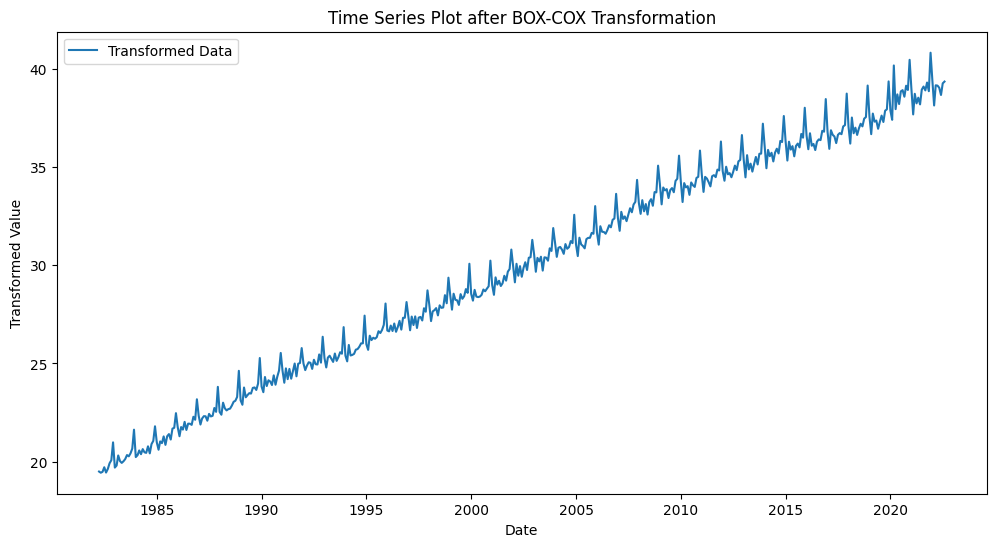

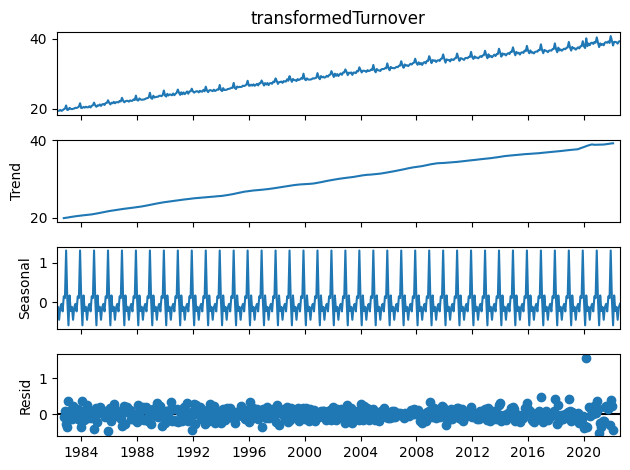

In [23]:
# Plot the time series after Boxcox transformation
plt.figure(figsize=(12, 6))
plt.plot(df['transformedTurnover'], label='Transformed Data')
plt.title('Time Series Plot after BOX-COX Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.show()

# Time series decomposition
the_seasonality = 12  # Set your seasonality (e.g., 12 for monthly data)
result = seasonal_decompose(df['transformedTurnover'], model='additive', period=the_seasonality)
result.plot()
plt.show()

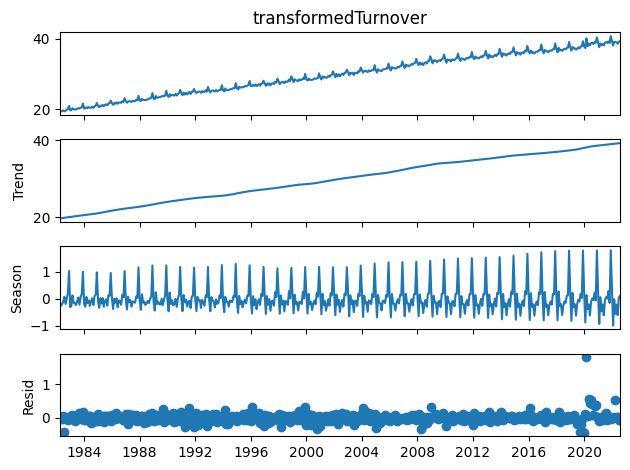

In [24]:
#using STL
#we define the period to define the frequency since our data series frequency is not clearly indicated
df_stl = STL(df.transformedTurnover, period=12, robust=True).fit()
df_stl.plot(); plt.show()

In [25]:
df.head()

Date  Turnover  transformedTurnover
date                                               
1982-04-01  Apr-1982    1162.6            19.497484
1982-05-01  May-1982    1150.9            19.437828
1982-06-01  Jun-1982    1160.0            19.484266
1982-07-01  Jul-1982    1206.4            19.716902
1982-08-01  Aug-1982    1152.5            19.446013

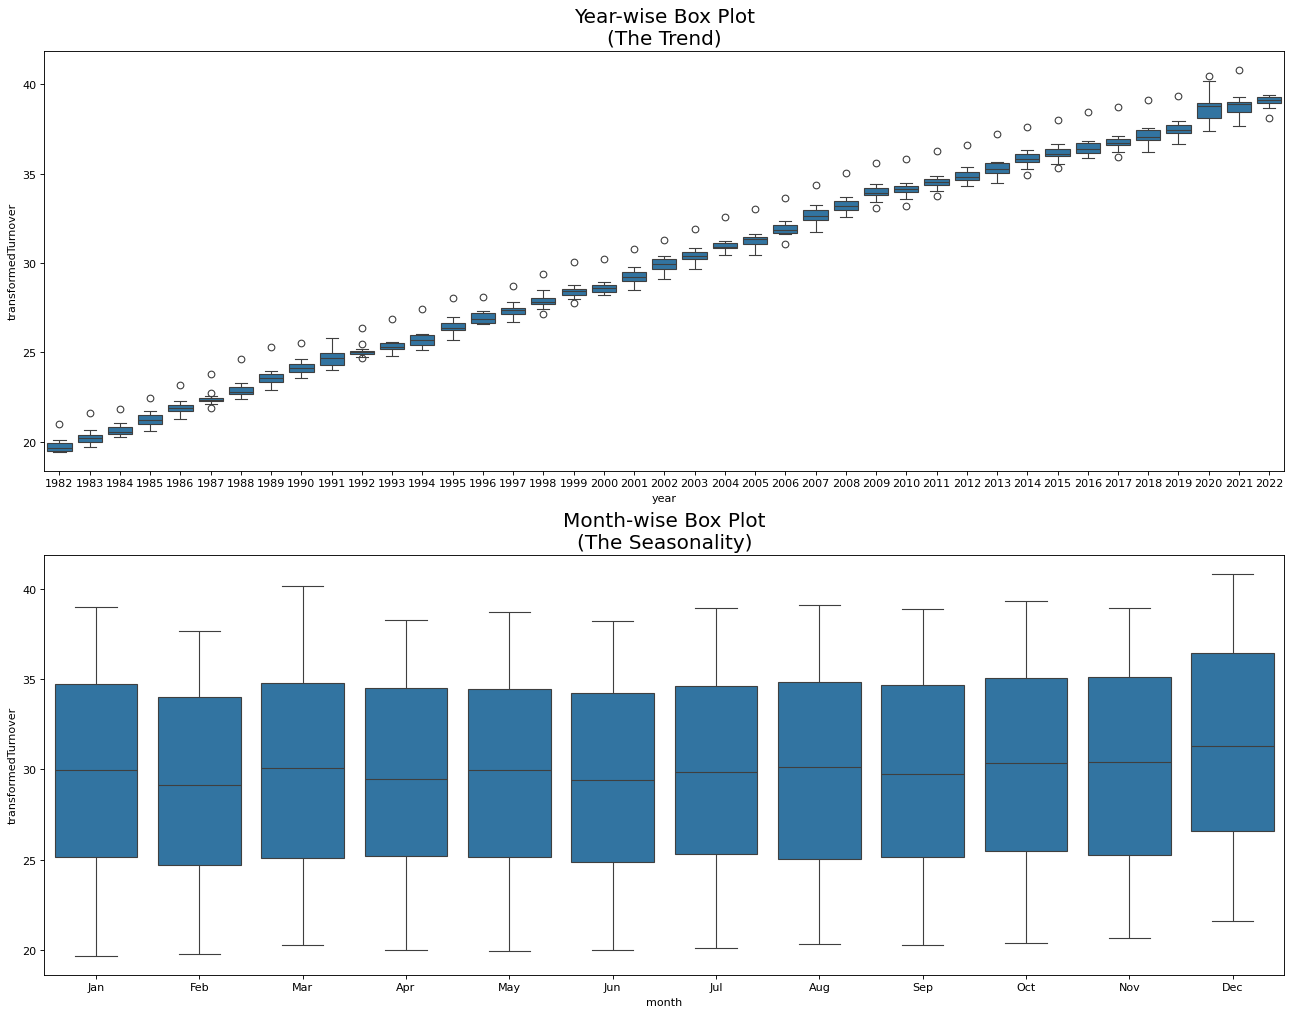

In [26]:
# Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(2, 1, figsize=(20,15), dpi= 80)
sns.boxplot(x='year', y='transformedTurnover', data=df, ax=axes[0])

sns.boxplot(x='month', y='transformedTurnover', data=df.loc[~df.year.isin([1982, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

#let's filter all warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
ADF_result = adfuller(df['Turnover'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 3.7513074217909343
p-value: 1.0


In [29]:
ADF_result = adfuller(df['transformedTurnover'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1834712197464274
p-value: 0.6806652572019836


In [30]:
df.head()

Date  Turnover  transformedTurnover  year month
date                                                            
1982-04-01 1982-04-01    1162.6            19.497484  1982   Apr
1982-05-01 1982-05-01    1150.9            19.437828  1982   May
1982-06-01 1982-06-01    1160.0            19.484266  1982   Jun
1982-07-01 1982-07-01    1206.4            19.716902  1982   Jul
1982-08-01 1982-08-01    1152.5            19.446013  1982   Aug

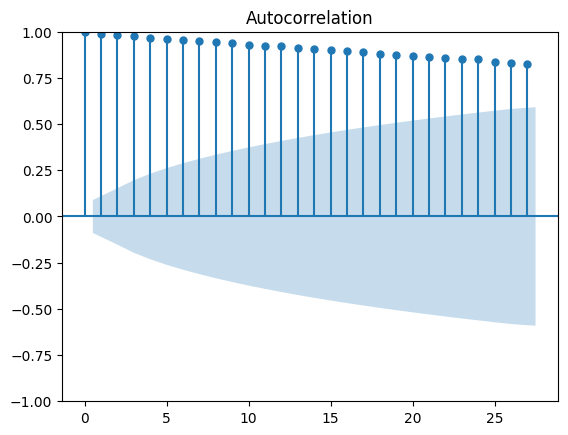

In [31]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['transformedTurnover'])
pyplot.show()

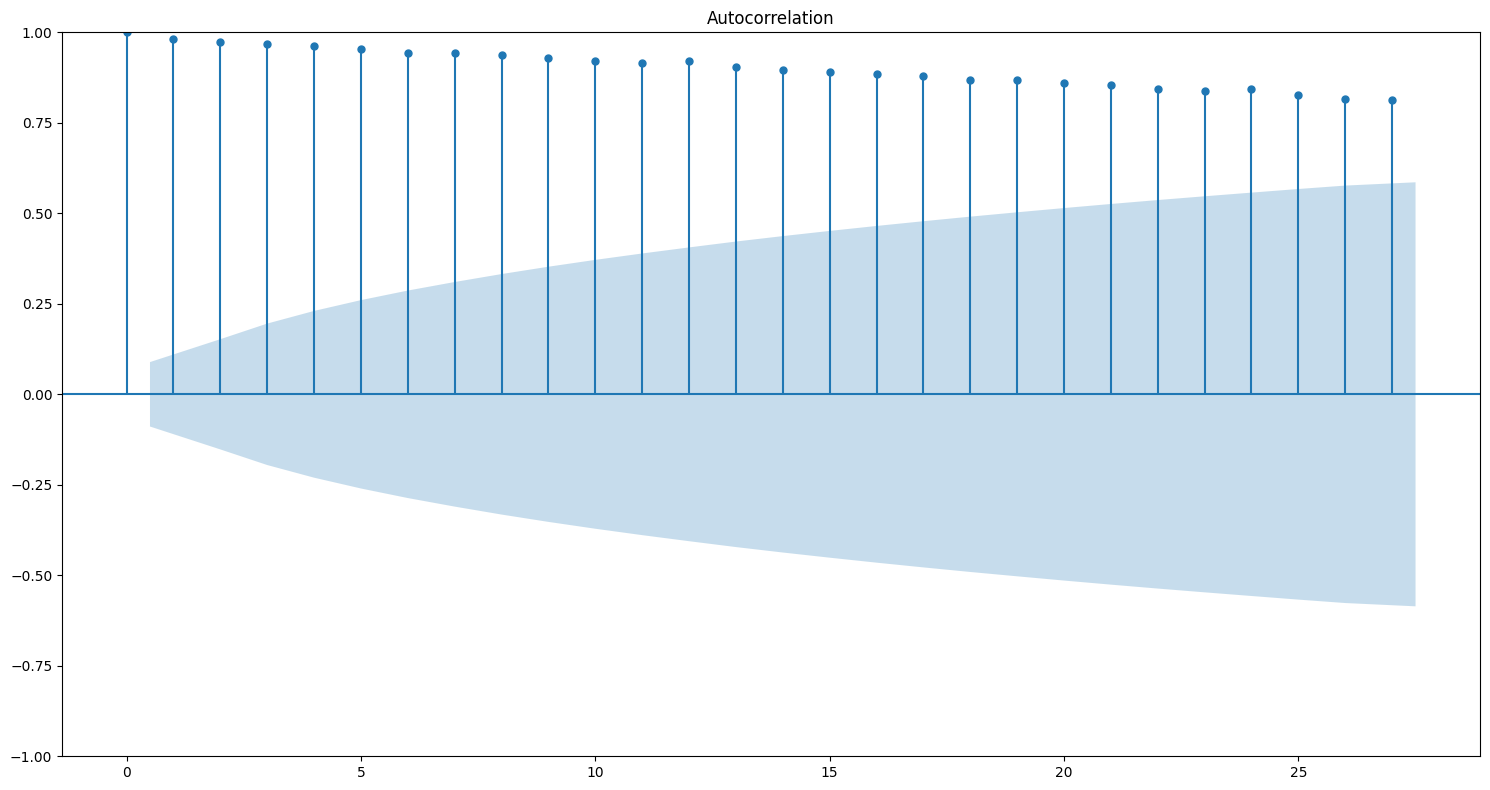

In [32]:
# the number of lags determine the range of values on the x-axis , we will use the default lag

fig = plot_acf(df ['Turnover']);
# changing it's width and height
fig.set_size_inches(15,8)
plt.tight_layout()

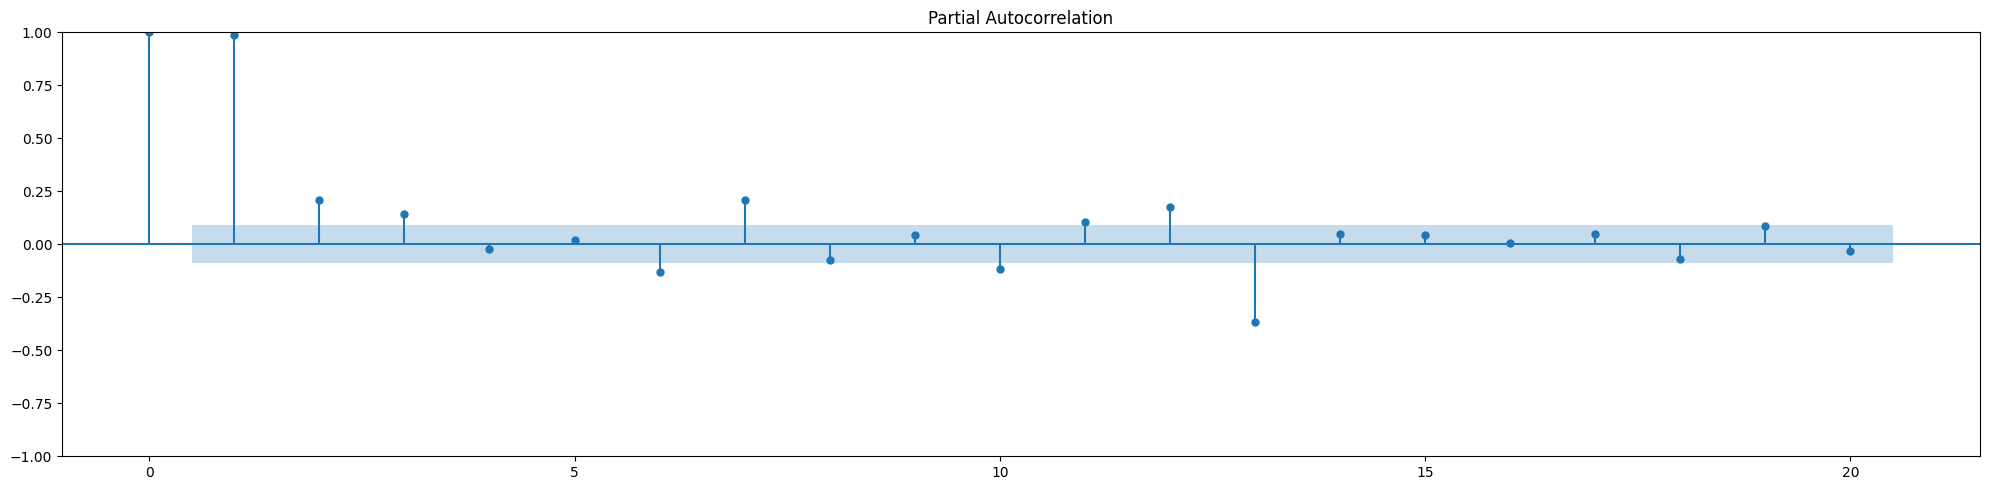

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(df['transformedTurnover'], lags=20)
fig.set_size_inches(20,5)


plt.tight_layout()

plt.savefig('fpacf', dpi=300)

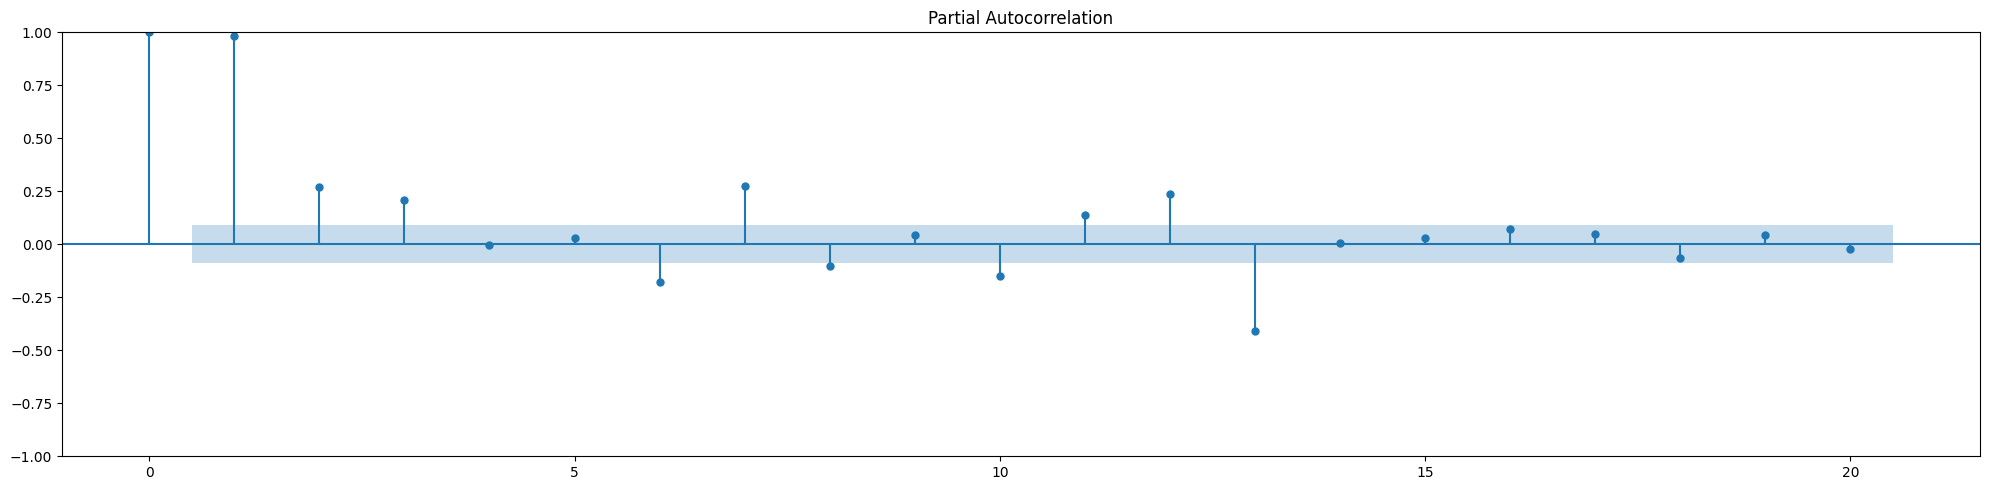

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(df['Turnover'], lags=20)
fig.set_size_inches(20,5)


plt.tight_layout()

plt.savefig('fpacf', dpi=300)

In [35]:
#transform data
fdiff = np.diff(df['transformedTurnover'], n=1)

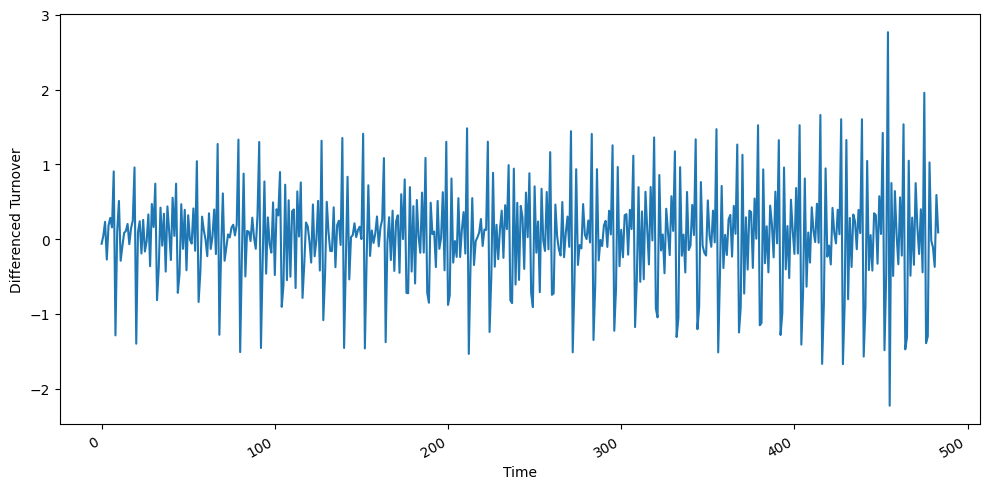

In [36]:
#plot transformed data
fig, ax = plt.subplots()

ax.plot(fdiff)
ax.set_xlabel('Time')
ax.set_ylabel('Differenced Turnover')

#plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.set_figheight(5)
fig.set_figwidth(10)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('transformedTurnover', dpi=300)

In [37]:
#check for ADF
ADF_result = adfuller(fdiff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.224476050217652
p-value: 5.128332837210837e-08


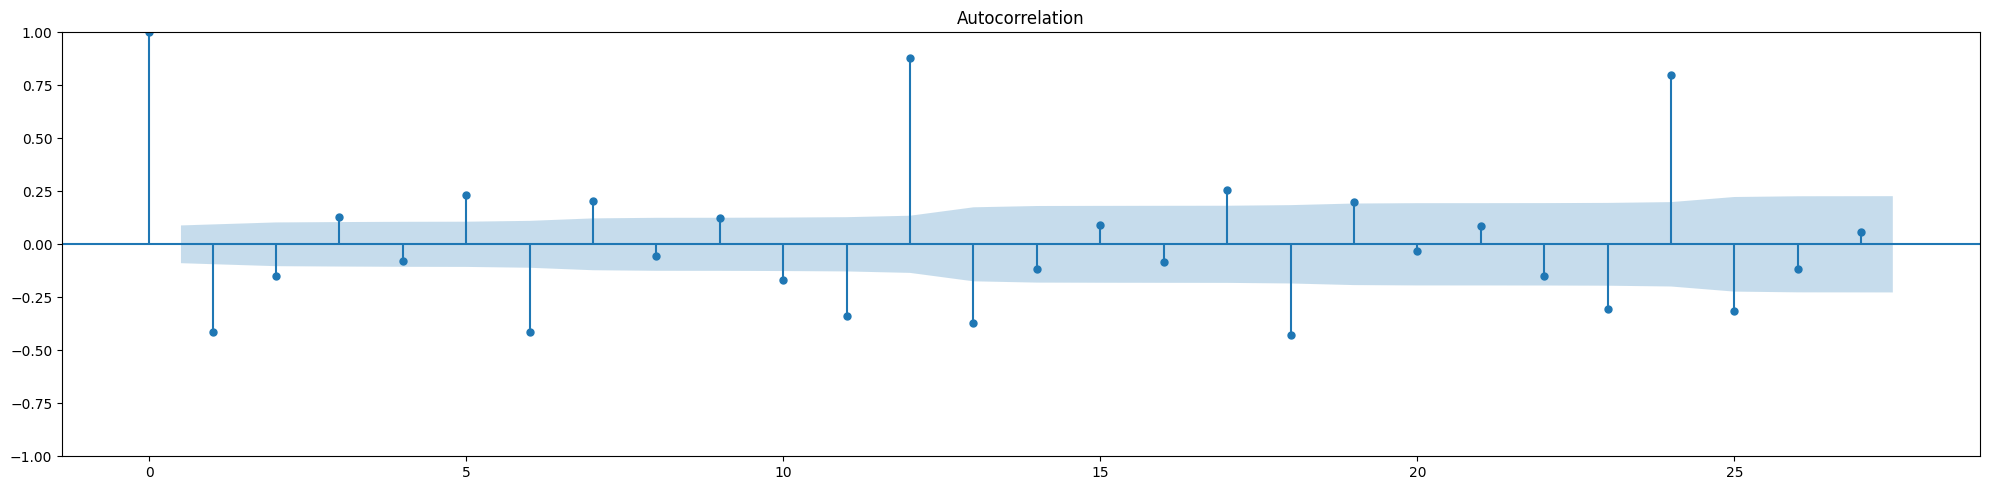

In [38]:
# the number of lags determine the range of values on the x-axis , we will use the default lag
fig = plot_acf(fdiff);
# changing it's width and height
fig.set_size_inches(20,5)
plt.tight_layout()
#plt.savefig('Turnoverautocorrelation', dpi=300)

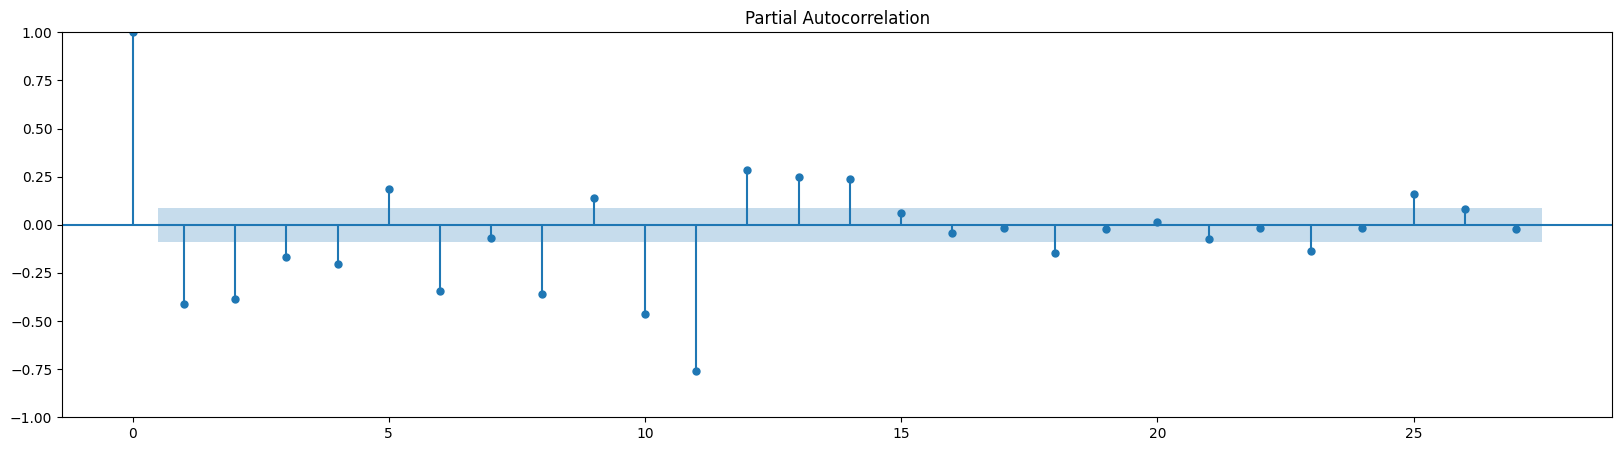

In [39]:
#let's plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf

# changing it's width and height
#let us just check default lags
fig = plot_pacf(fdiff)
fig.set_size_inches(20, 5)

In [40]:
#print(len(df['transformedTurnover']))
print(len(fdiff))

484


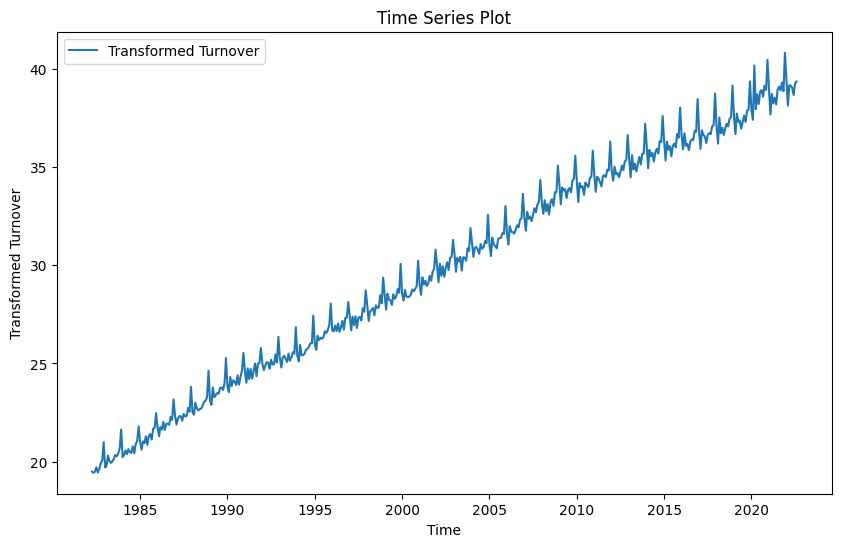

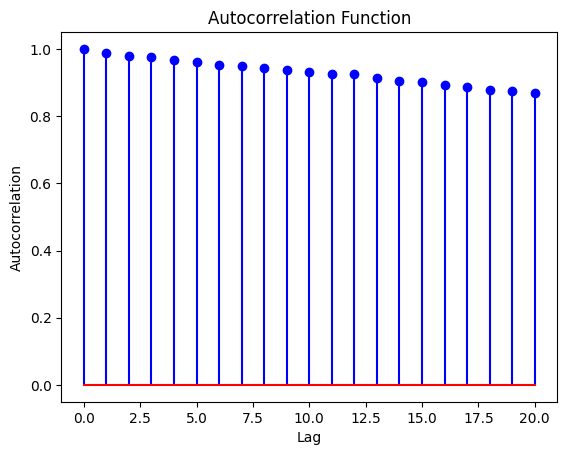

In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['transformedTurnover'], label='Transformed Turnover')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Transformed Turnover')
plt.legend()
plt.show()

# Check autocorrelation
acf_result = sm.tsa.acf(df['transformedTurnover'], fft=False, nlags=20)

# Plot autocorrelation function
plt.stem(acf_result, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


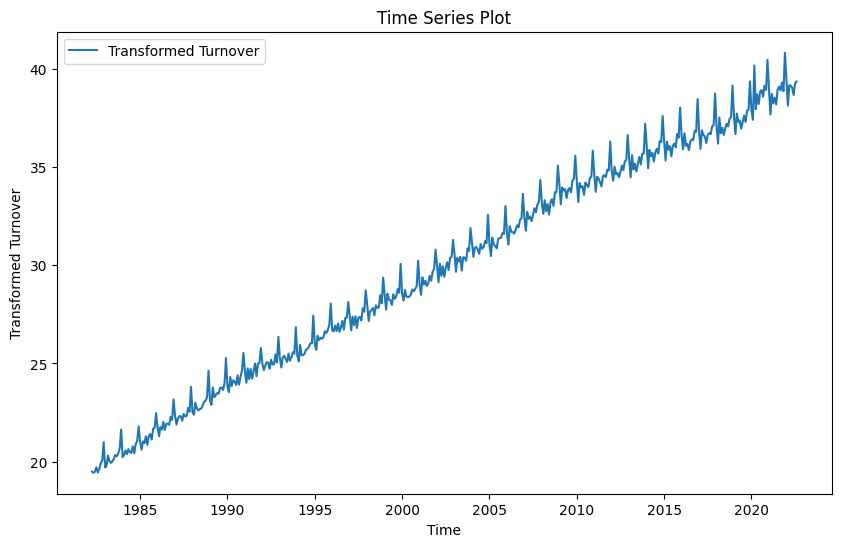

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot the time series to check if it looks like a random walk
plt.figure(figsize=(10, 6))
plt.plot(df['transformedTurnover'], label='Transformed Turnover')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Transformed Turnover')
plt.legend()
plt.show()



In [44]:
#let's do 80-32 train-test data
diff = pd.DataFrame({'fdiff': fdiff})
train = diff[:-12]
test = diff[-12:]

print(len(train))
print(len(test))

472
12


In [45]:
diff.head()

fdiff
0 -0.059657
1  0.046439
2  0.232636
3 -0.270889
4  0.184948

In [46]:
import pandas as pd
import numpy as np

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'random_walk':
        pred_random_walk = []

        for i in range(train_len, total_len, window):
            # Use cumulative sum of differences as the random walk
            random_walk = np.cumsum(np.random.normal(size=window))
            pred_random_walk.extend(random_walk)

        return pred_random_walk


In [47]:
# Train the models and use the rolling forecast function
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_random_walk = rolling_forecast(diff, TRAIN_LEN, HORIZON, WINDOW, 'random_walk')

# Add predictions to the test DataFrame
test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_random_walk'] = pred_random_walk

# Updated test dataframe
print(test.head())


        fdiff  pred_mean  pred_last_value  pred_random_walk
472 -0.196134   0.041519         0.158602          0.673605
473  0.400849   0.041016        -0.196134          0.492512
474 -0.441365   0.041775         0.400849         -0.053474
475  1.957968   0.040758        -0.441365          0.782514
476 -1.388074   0.044786         1.957968          0.662602


In [53]:
#calculate the error
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['fdiff'], test['pred_mean'])
mse_last = mean_squared_error(test['fdiff'], test['pred_last_value'])
mse_random_walk = mean_squared_error(test['fdiff'], test['pred_random_walk'])

print(mse_mean, mse_last, mse_random_walk)

0.7847685613318403 2.1574954982744883 0.7969679771168856


In [54]:
# Calculate the error for random walk predictions
mse_random_walk = mean_squared_error(test['fdiff'], test['pred_random_walk'])

# Print mean squared errors for all methods
print(f"Mean Squared Error (Mean): {mse_mean}")
print(f"Mean Squared Error (Last Value): {mse_last}")
print(f"Mean Squared Error (Random Walk): {mse_random_walk}")


Mean Squared Error (Mean): 0.7847685613318403
Mean Squared Error (Last Value): 2.1574954982744883
Mean Squared Error (Random Walk): 0.7969679771168856


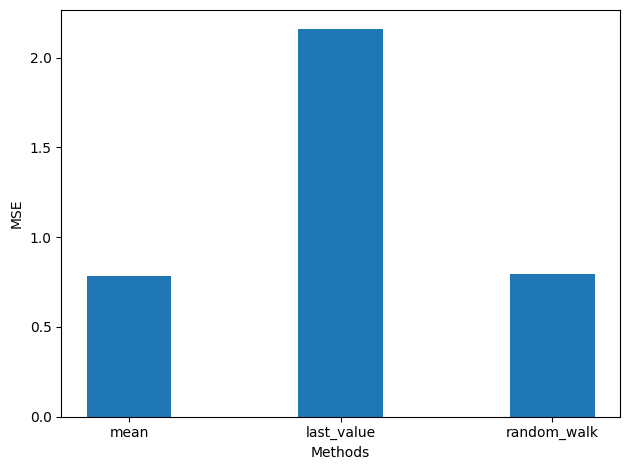

In [55]:
# Add the random walk mean squared error to the plot
x = ['mean', 'last_value', 'random_walk']
y = [mse_mean, mse_last, mse_random_walk]

fig, ax = plt.subplots()
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

plt.tight_layout()
plt.savefig('MSE', dpi=300)


In [56]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [57]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

# Fit the ARIMA model using auto_arima
model = auto_arima(fdiff, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                   seasonal=True,
                   d=None, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Print the summary of the best-fitting model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-138.578, Time=3.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=992.507, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=411.145, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=992.307, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=399.162, Time=1.31 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-33.477, Time=1.79 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-140.213, Time=3.61 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-77.398, Time=3.32 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-181.578, Time=4.30 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-162.613, Time=3.50 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-171.649, Time=5.37 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-91.616, Time=3.47 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=-208.860, Time=5.66 sec
 ARIMA(2,0,1)(1,0,2)[12] interc

SARIMA(3, 0, 1)(2, 0, 1)[12].

In [58]:
df.head()

Date  Turnover  transformedTurnover  year month
date                                                            
1982-04-01 1982-04-01    1162.6            19.497484  1982   Apr
1982-05-01 1982-05-01    1150.9            19.437828  1982   May
1982-06-01 1982-06-01    1160.0            19.484266  1982   Jun
1982-07-01 1982-07-01    1206.4            19.716902  1982   Jul
1982-08-01 1982-08-01    1152.5            19.446013  1982   Aug

In [60]:
# perform residual analysis
model = SARIMAX(df['transformedTurnover'], order=(3, 0, 1), seasonal_order=(2, 0, 1, 12), simple_differencing=True)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                transformedTurnover   No. Observations:                  485
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 108.226
Date:                            Sun, 11 Feb 2024   AIC                           -200.453
Time:                                    22:18:59   BIC                           -166.980
Sample:                                04-01-1982   HQIC                          -187.301
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2991      0.079      3.792      0.000       0.145       0.454
ar.L2          0.2807      0.060   

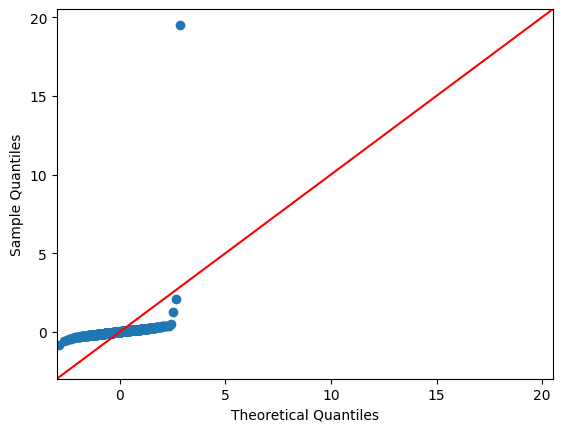

In [61]:
#use qqplot to check if residuals are in a straight line
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

plt.savefig('qqplot.png', dpi=300)

In [63]:
#let's test if they are uncorrelated using ljung-box test
from statsmodels.stats.diagnostic import acorr_ljungbox

#we will compute for ljung-box statistic and p-value for 12 lags
pvalue = acorr_ljungbox(residuals, np.arange(1, 13, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.002247   0.962193
2   0.002632   0.998685
3   0.056687   0.996471
4   0.059508   0.999566
5   0.075572   0.999919
6   0.168082   0.999907
7   0.334091   0.999856
8   2.151606   0.976008
9   2.216433   0.987564
10  2.522467   0.990544
11  2.523762   0.995644
12  2.545055   0.997992


In [64]:
#let's create a our training and test set to start the forecasting
# we want to forecast the next 12 years
traindf = df[:-12]
testdf = df[-12:]

print(len(traindf))
print(len(testdf))

473
12


In [95]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define a random seed for reproducibility
np.random.seed(42)

# Reuse our rolling forecast function
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    total_len = train_len + horizon

    pred_SARIMA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(3, 0, 1), seasonal_order=(2, 0, 1, 12))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMA.extend(oos_pred)

    return pred_SARIMA


In [110]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define a random seed for reproducibility
np.random.seed(42)

# Reuse our rolling forecast function
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> dict:
    total_len = train_len + horizon

    pred_last_value = []
    pred_random_walk = []
    pred_SARIMA = []

    for i in range(train_len, total_len, window):
        # 'last' method
        last_value = df[:i].iloc[-1]
        pred_last_value.extend(last_value for _ in range(window))

        # 'random_walk' method
        random_walk = np.random.normal(loc=last_value, scale=1, size=window)
        pred_random_walk.extend(random_walk)

        # 'SARIMA' method
        model = SARIMAX(df[:i], order=(3, 0, 1), seasonal_order=(2, 0, 1, 12))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMA.extend(oos_pred)

    return {
        'last_value': pred_last_value,
        'random_walk': pred_random_walk,
        'SARIMA': pred_SARIMA
    }




In [111]:
#df, traindf, testdf are DataFrames containing your time series data
TRAIN_LEN = len(traindf)
HORIZON = len(testdf)
WINDOW = 2

# Using different forecasting methods
pred_dict = rolling_forecast(df['transformedTurnover'], TRAIN_LEN, HORIZON, WINDOW)

# Calculate mean squared error for each method
mse_last_value = mean_squared_error(testdf['transformedTurnover'], pred_dict['last_value'])
mse_random_walk = mean_squared_error(testdf['transformedTurnover'], pred_dict['random_walk'])
mse_SARIMA = mean_squared_error(testdf['transformedTurnover'], pred_dict['SARIMA'])

# Print mean squared errors
print(f'MSE for Last Value method: {mse_last_value}')
print(f'MSE for Random Walk method: {mse_random_walk}')
print(f'MSE for SARIMA method: {mse_SARIMA}')

MSE for Last Value method: 1.2371264282868266
MSE for Random Walk method: 1.0908792294109595
MSE for SARIMA method: 0.05869050164999492


In [103]:
# df, traindf, testdf are DataFrames containing your time series data
TRAIN_LEN = len(traindf)
HORIZON = len(testdf)
WINDOW = 2

# Using SARIMA forecasting method
pred_SARIMA = rolling_forecast(df['transformedTurnover'], TRAIN_LEN, HORIZON, WINDOW)




In [97]:
testdf.head()

Date  Turnover  transformedTurnover  year month  pred_mean  \
date                                                                          
2021-09-01 2021-09-01   12743.8            38.898207  2021   Sep  29.618132   
2021-10-01 2021-10-01   13224.0            39.299056  2021   Oct  29.618132   
2021-11-01 2021-11-01   12696.0            38.857691  2021   Nov  29.658050   
2021-12-01 2021-12-01   15164.3            40.815659  2021   Dec  29.658050   
2022-01-01 2022-01-01   13380.8            39.427584  2022   Jan  29.700728   

           pred_last_value pred_ARMA  pred_SARIMA  pred_random_walk  
date                                                                 
2021-09-01      2021-08-01      None    38.725905      1.627776e+09  
2021-10-01      2021-08-01      None    39.355074      1.627776e+09  
2021-11-01      2021-10-01      None    39.349057      1.633046e+09  
2021-12-01      2021-10-01      None    40.809606      1.633046e+09  
2022-01-01      2021-12-01      None    39.183978      1.638317e+09

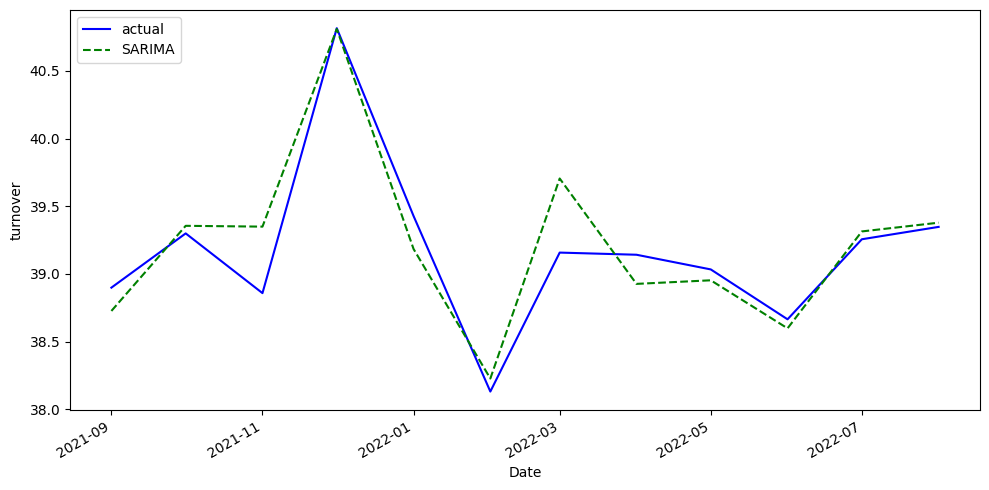

In [100]:
# Plotting the SARIMA results
fig, ax = plt.subplots()

ax.plot(pd.to_datetime(testdf.index), testdf['transformedTurnover'], 'b-', label='actual')
ax.plot(pd.to_datetime(testdf.index), pred_SARIMA, 'g--', label='SARIMA')

ax.legend(loc='upper left')

ax.set_xlabel('Date')
ax.set_ylabel('turnover')

fig.set_size_inches(10, 5)
fig.autofmt_xdate()
plt.tight_layout()

plt.show()

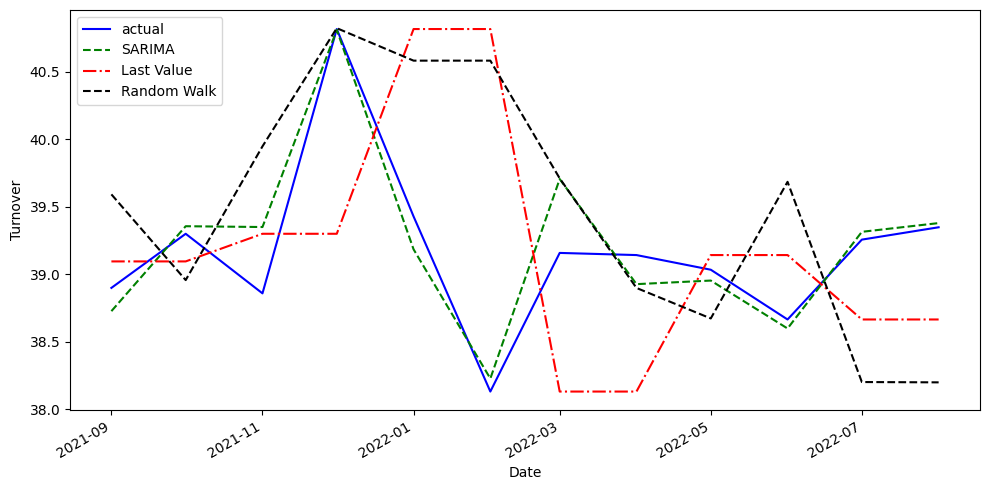

In [112]:
# Plotting the results for SARIMA, Last Value, and Random Walk
fig, ax = plt.subplots()

ax.plot(pd.to_datetime(testdf.index), testdf['transformedTurnover'], 'b-', label='actual')
ax.plot(pd.to_datetime(testdf.index), pred_SARIMA, 'g--', label='SARIMA')
ax.plot(pd.to_datetime(testdf.index), pred_dict['last_value'], 'r-.', label='Last Value')
ax.plot(pd.to_datetime(testdf.index), pred_dict['random_walk'], 'k--', label='Random Walk')

ax.legend(loc='upper left')

ax.set_xlabel('Date')
ax.set_ylabel('Turnover')

fig.set_size_inches(10, 5)
fig.autofmt_xdate()
plt.tight_layout()

plt.show()


In [108]:

from sklearn.metrics import mean_squared_error

mse_SARIMA = mean_squared_error(testdf['transformedTurnover'], testdf['pred_SARIMA'])

print('MSE SARIMA:', mse_SARIMA)

MSE SARIMA: 0.05869050164999492


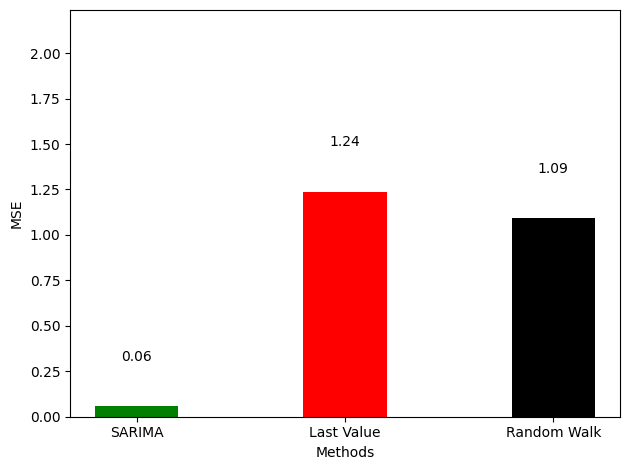

In [113]:
# Plotting the mean squared errors for SARIMA, Last Value, and Random Walk
fig, ax = plt.subplots()

methods = ['SARIMA', 'Last Value', 'Random Walk']
mse_values = [mse_SARIMA, mse_last_value, mse_random_walk]

ax.bar(methods, mse_values, color=['green', 'red', 'black'], width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, max(mse_values) + 1)

for index, value in enumerate(mse_values):
    plt.text(x=index, y=value + 0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('mse.png', dpi=300)


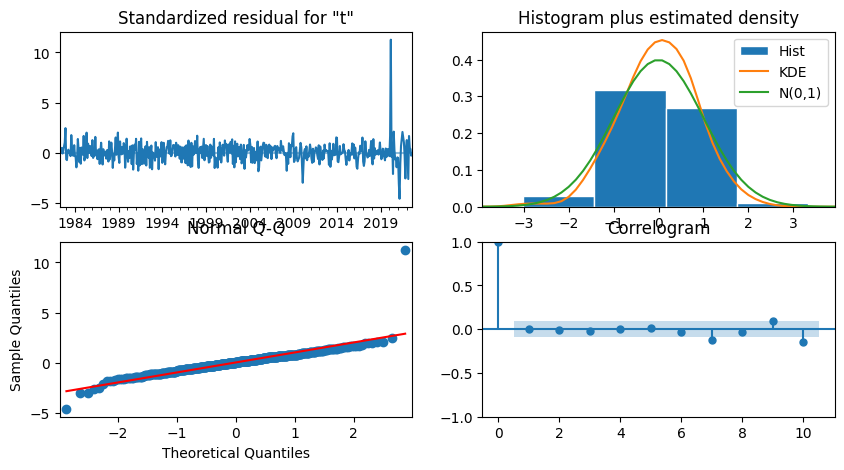

In [116]:
model_fit.plot_diagnostics(figsize=(10,5));

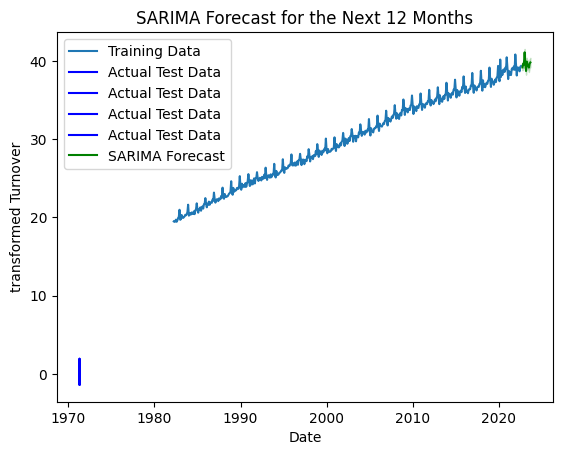

In [119]:
# Forecast the next 12 months after August 2022
forecast_index = pd.date_range(start='2022-09-01', periods=12, freq='M')
forecast_sarima = model_fit.get_forecast(steps=12)  # 'model_fit' is the result of your SARIMA model fitting

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_index, forecast_values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast for the Next 12 Months')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [129]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months starting from the last available data point (August 2022)
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()




In [121]:
# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame with forecast values and confidence intervals
forecast_table = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Display the table
print(forecast_table)


         Date   Forecast   Lower CI   Upper CI
0  2022-09-01  39.163619  38.803615  39.523624
1  2022-10-01  39.653907  39.289376  40.018437
2  2022-11-01  39.506043  39.122832  39.889254
3  2022-12-01  41.091531  40.658082  41.524979
4  2023-01-01  39.683455  39.234284  40.132626
5  2023-02-01  38.705356  38.234363  39.176350
6  2023-03-01  39.898423  39.400840  40.396007
7  2023-04-01  39.356029  38.839868  39.872189
8  2023-05-01  39.505633  38.969335  40.041931
9  2023-06-01  39.130324  38.573596  39.687053
10 2023-07-01  39.649497  39.074654  40.224340
11 2023-08-01  39.793474  39.200408  40.386540


**Box-Cox aND INVERS + aUTO ARIMA**

In [124]:
from scipy.stats import boxcox
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.special import inv_boxcox
import pandas as pd

# df is a DataFrame with a datetime index
df['transformedTurnover'], lam = boxcox(df['Turnover'])

# Use the differenced data for training
traindf = df.iloc[:-12]
testdf = df.iloc[-12:]

# SARIMA model parameters
order = (2, 0, 1)
seasonal_order = (3, 0, 1, 12)

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(traindf['transformedTurnover'], order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months
forecast_sarima_transformed = fit_sarima.get_forecast(steps=12).predicted_mean

# Create a date range for the forecast
forecast_index = pd.date_range(start=testdf.index[0], periods=len(forecast_sarima_transformed), freq='M')

# Inverse transform the forecasted values
forecast_sarima = inv_boxcox(forecast_sarima_transformed, lam)


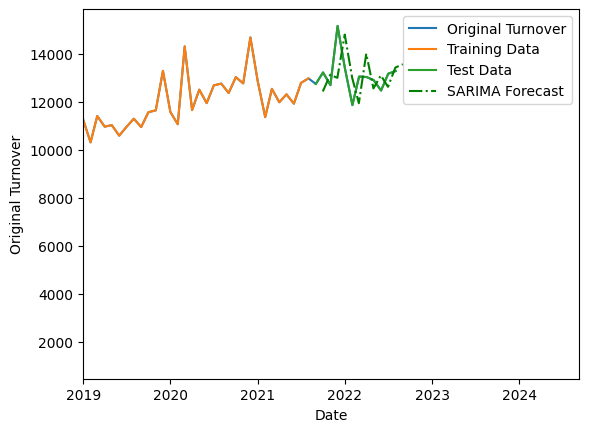

In [125]:
# Plotting the results
import matplotlib.pyplot as plt

plt.plot(df.index, df['Turnover'], label='Original Turnover')
plt.plot(traindf.index, inv_boxcox(traindf['transformedTurnover'], lam), label='Training Data')
plt.plot(testdf.index, inv_boxcox(testdf['transformedTurnover'], lam), label='Test Data')
plt.plot(forecast_index, inv_boxcox(forecast_sarima_transformed, lam), 'g-.', label='SARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Original Turnover')

# Set x-axis limits to show only dates greater than 2019
plt.xlim(pd.Timestamp('2019-01-01'), None)

plt.legend()
plt.show()



         Date      Forecast      Lower CI      Upper CI
0  2021-09-01  12430.427389  11948.895653  12926.336942
1  2021-10-01  13123.599861  12618.480551  13643.701546
2  2021-11-01  12999.208838  12459.162466  13556.585968
3  2021-12-01  14802.731583  14183.614526  15441.855102
4  2022-01-01  13003.110169  12416.920657  13609.768508
5  2022-02-01  11940.575054  11370.071112  12532.236663
6  2022-03-01  14007.558654  13341.306792  14698.403853
7  2022-04-01  12556.336732  11922.658881  13214.889423
8  2022-05-01  13100.076785  12425.810556  13801.358675
9  2022-06-01  12624.475724  11949.958677  13327.090064
10 2022-07-01  13429.508293  12703.802707  14185.802493
11 2022-08-01  13565.002390  12815.223669  14347.137913


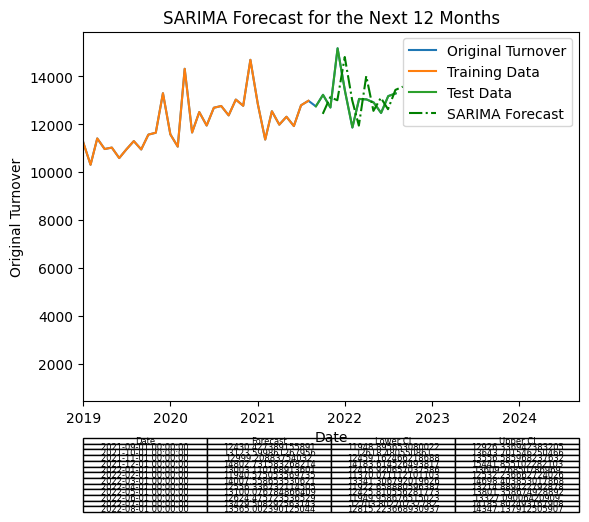

In [132]:
# Inverse transform the forecasted values
forecast_sarima = inv_boxcox(forecast_sarima_transformed, lam)

# Extract forecasted values and confidence intervals after inverse transformation
forecast_values_inverse = inv_boxcox(forecast_values, lam)
lower_ci_inverse = inv_boxcox(conf_int.iloc[:, 0], lam)
upper_ci_inverse = inv_boxcox(conf_int.iloc[:, 1], lam)

# Create a DataFrame with forecast values and confidence intervals after inverse transformation
forecast_table_inverse = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecast': forecast_values_inverse.values,
    'Lower CI': lower_ci_inverse.values,
    'Upper CI': upper_ci_inverse.values
})

# Display the table after inverse transformation
print(forecast_table_inverse)

# Plot the results after inverse transformation
plt.plot(df['Date'], df['Turnover'], label='Original Turnover')
plt.plot(traindf.index, inv_boxcox(traindf['transformedTurnover'], lam), label='Training Data')
plt.plot(testdf.index, inv_boxcox(testdf['transformedTurnover'], lam), label='Test Data')
plt.plot(forecast_index, forecast_sarima, 'g-.', label='SARIMA Forecast')

# Display the table after inverse transformation
plt.table(cellText=forecast_table_inverse.values,
          colLabels=forecast_table_inverse.columns,
          cellLoc='center',
          loc='bottom',
          bbox=[0, -0.3, 1, 0.2])

# Set x-axis limits to show only dates greater than 2019
plt.xlim(pd.Timestamp('2019-01-01'), None)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Original Turnover')
plt.title('SARIMA Forecast for the Next 12 Months')

# Add legend
plt.legend()

# Show the plot
plt.show()


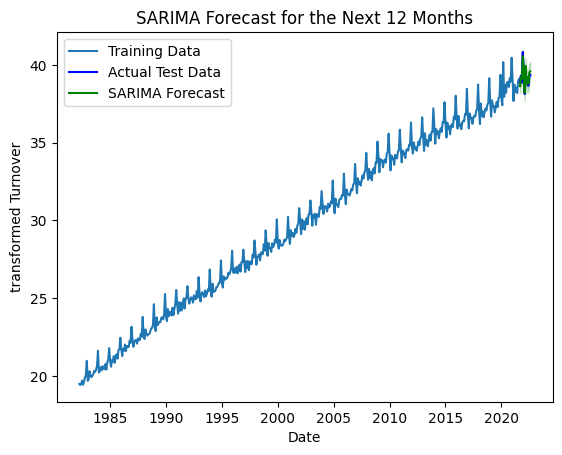

In [126]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# SARIMA model parameters
order = (2, 0, 1)
seasonal_order = (3, 0, 1, 12)

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months starting from the last available data point (August 2022)
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values.values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast for the Next 12 Months')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [127]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months starting from the last available data point (August 2022)
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame with forecast values and confidence intervals
forecast_table = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Display the table
print(forecast_table)


         Date   Forecast   Lower CI   Upper CI
0  2021-09-01  38.630482  38.209073  39.051891
1  2021-10-01  39.216158  38.791740  39.640576
2  2021-11-01  39.112791  38.655240  39.570342
3  2021-12-01  40.544531  40.068540  41.020523
4  2022-01-01  39.116044  38.618830  39.613259
5  2022-02-01  38.201680  37.685351  38.718010
6  2022-03-01  39.930349  39.395318  40.465379
7  2022-04-01  38.738651  38.185749  39.291553
8  2022-05-01  39.196667  38.626500  39.766835
9  2022-06-01  38.796852  38.210017  39.383686
10 2022-07-01  39.467281  38.864312  40.070249
11 2022-08-01  39.577142  38.958536  40.195748


In [ ]:
# train_len is the length of the training set
# horizon is the forecast horizon
# window is the rolling window size
# method is the forecasting method ('mean', 'last', 'SARIMA', 'random_walk')
predictions = rolling_forecast(df, train_len=100, horizon=10, window=5, method='random_walk')
print(predictions)

In [ ]:
# we can now define the range of possible values for p,q and P,Q
#let us try values 0,1,2,3 for p,q,and P,Q
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = (0,4,1)
Qs = (0,4,1)

#generate the unique combinations
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['transformedTurnover'] [:-12]
#set values of d, D and frequency m
d = 1
D = 1
m = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, m)
SARIMA_result_df

  0%|          | 0/144 [00:00<?, ?it/s]

(p,q,P,Q)         AIC
0    (3, 3, 4, 4) -345.140741
1    (2, 1, 4, 4) -332.984382
2    (3, 0, 4, 4) -332.813647
3    (2, 0, 4, 4) -332.081216
4    (0, 3, 4, 4) -331.006775
..            ...         ...
139  (1, 0, 0, 0)   22.890830
140  (0, 0, 1, 1)   35.180145
141  (0, 0, 0, 1)   55.838289
142  (0, 0, 1, 0)  146.636162
143  (0, 0, 0, 0)  175.745999

[144 rows x 2 columns]

In [ ]:
# we can now define the range of possible values for p,q and P,Q
#let us try values 0,1,2,3 for p,q,and P,Q
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = (0,4,1)
Qs = (0,4,1)

#generate the unique combinations
SARIMA_order_list_fdiff = list(product(ps, qs, Ps, Qs))

train = fdiff [:-12]
#set values of d, D and frequency m
d = 1
D = 1
m = 12

SARIMA_result_fdiff = optimize_SARIMA(train, SARIMA_order_list_fdiff, d, D, m)
SARIMA_result_fdiff

  0%|          | 0/144 [00:00<?, ?it/s]

(p,q,P,Q)         AIC
0    (2, 1, 4, 4) -315.524372
1    (3, 2, 4, 4) -313.718201
2    (3, 1, 4, 4) -312.863390
3    (2, 3, 4, 4) -311.661215
4    (1, 2, 4, 4) -311.283792
..            ...         ...
136  (0, 0, 0, 4)  471.551842
137  (0, 0, 1, 1)  554.210485
138  (0, 0, 0, 1)  579.082857
139  (0, 0, 1, 0)  667.112683
140  (0, 0, 0, 0)  691.193416

[141 rows x 2 columns]

In [ ]:
import numpy as np

# Set up the test dataset
testRW = df.iloc[-12:]

# Create a random walk baseline model
np.random.seed(42)  # for reproducibility
testRW['random_walk'] = np.cumsum(np.random.normal(size=12)) + df['transformedTurnover'].iloc[-1]

# Display the test dataset
print(testRW)


                 Date  Turnover  transformedTurnover  year month  random_walk
date                                                                         
2021-09-01 2021-09-01   12743.8            38.898207  2021   Sep    39.843937
2021-10-01 2021-10-01   13224.0            39.299056  2021   Oct    39.705673
2021-11-01 2021-11-01   12696.0            38.857691  2021   Nov    40.353361
2021-12-01 2021-12-01   15164.3            40.815659  2021   Dec    41.876391
2022-01-01 2022-01-01   13380.8            39.427584  2022   Jan    41.642238
2022-02-01 2022-02-01   11860.5            38.130339  2022   Feb    41.408101
2022-03-01 2022-03-01   13052.6            39.157249  2022   Mar    42.987314
2022-04-01 2022-04-01   13033.5            39.141360  2022   Apr    43.754748
2022-05-01 2022-05-01   12903.6            39.032837  2022   May    43.285274
2022-06-01 2022-06-01   12469.6            38.664223  2022   Jun    43.827834
2022-07-01 2022-07-01   13171.5            39.255767  2022   Jul

In [ ]:
import numpy as np

# Set up the test dataset
testRWfdiff = fdiff[-12:]

# Create a random walk baseline model
np.random.seed(42)  # for reproducibility
random_walk = np.cumsum(np.random.normal(size=12)) + fdiff[-1]

# Set up the test dataset with the random walk
testRWfdiff = np.concatenate((fdiff, random_walk))

# Display the test dataset
print(testRWfdiff)

[-5.96566127e-02  4.64385499e-02  2.32635733e-01 -2.70889401e-01
  1.84948373e-01  2.85993658e-01  1.58890905e-01  9.06991814e-01
 -1.28374267e+00  1.05274821e-01  5.12143641e-01 -2.87104000e-01
 -9.17599075e-02  8.41530293e-02  1.11012558e-01  2.04770996e-01
 -6.52264353e-02  1.48978469e-01  2.47572992e-01  9.59858868e-01
 -1.39477865e+00  9.62712942e-02  2.40954128e-01 -1.90282162e-01
  2.58921496e-01 -1.63454738e-01 -2.70341312e-02  3.32155976e-01
 -3.59279410e-01  4.71243594e-01  1.63927592e-01  7.43391338e-01
 -8.13737579e-01 -3.79468540e-01  4.22925284e-01 -8.50139062e-02
  3.41152554e-01 -4.31763779e-01  4.39109194e-01  1.09829481e-01
 -2.77077013e-01  5.54408681e-01  4.51061100e-02  7.43096642e-01
 -7.15604343e-01 -4.60167471e-01  4.68668504e-01 -1.28010510e-01
  3.93866586e-01 -4.14274340e-01  3.21256128e-01 -3.40813432e-03
 -5.77621312e-02  4.12196567e-01 -1.53005165e-01  1.04273259e+00
 -8.37863502e-01 -4.47300390e-01  3.02556142e-01  1.21932607e-01
 -3.98902825e-03 -2.25573

In [ ]:
# train the model using the values of p,q,P,Q
# m =12 since monthly
train = df['transformedTurnover'] [:-12]

# we found that model with (p=1, q=0, P=1, Q=4) has the lowest AIC
# remember that our model is SARIMA(pdq)(PDQ)m
# In our example d=1 (1st order difference) and D=1 (1st order seasonal difference)

SARIMA_model = SARIMAX(train, order=(3,0,1), seasonal_order=(2,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

#get the residuals
residuals = SARIMA_model_fit.resid

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                transformedTurnover   No. Observations:                  473
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 109.739
Date:                            Sun, 11 Feb 2024   AIC                           -203.478
Time:                                    08:53:11   BIC                           -170.205
Sample:                                04-01-1982   HQIC                          -190.391
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2257      0.061      3.694      0.000       0.106       0.345
ar.L2          0.3134      0.050   

In [ ]:
# train the model using the values of p,q,P,Q
# m =12 since monthly
trainfdiff = fdiff [:-12]

# we found that model with (p=1, q=0, P=1, Q=4) has the lowest AIC
# remember that our model is SARIMA(pdq)(PDQ)m
# In our example d=1 (1st order difference) and D=1 (1st order seasonal difference)

SARIMA_model_fdiff = SARIMAX(trainfdiff, order=(3,0,1), seasonal_order=(2,0,1,12), simple_differencing=False)
SARIMA_model_fit_fdiff = SARIMA_model_fdiff.fit(disp=False)

#get the residuals
residuals = SARIMA_model_fit_fdiff.resid

print(SARIMA_model_fit_fdiff.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  472
Model:             SARIMAX(3, 0, 1)x(2, 0, 1, 12)   Log Likelihood                 119.610
Date:                            Sun, 11 Feb 2024   AIC                           -223.219
Time:                                    12:19:52   BIC                           -189.963
Sample:                                         0   HQIC                          -210.138
                                            - 472                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1066      0.014      7.363      0.000       0.078       0.135
ar.L2          0.2730      0.063   

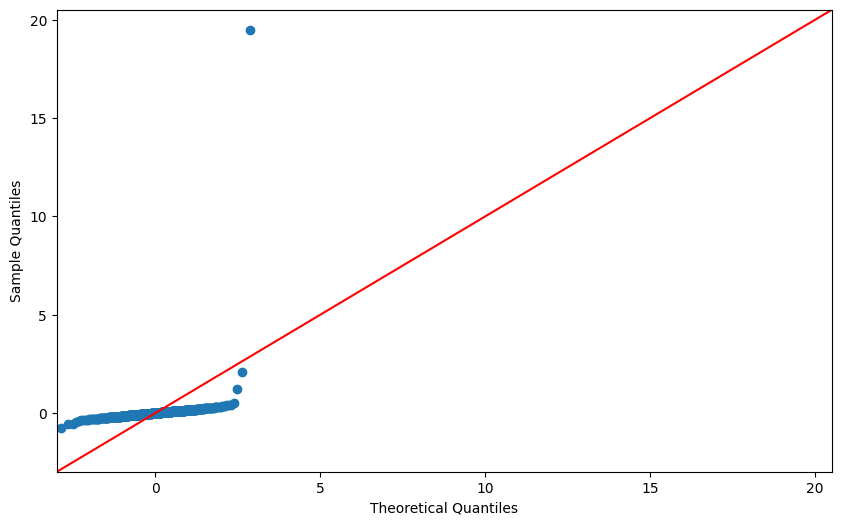

In [ ]:
#let us plot the qqplot
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

plt.savefig('SARIMA_qqplot.png', dpi=300)

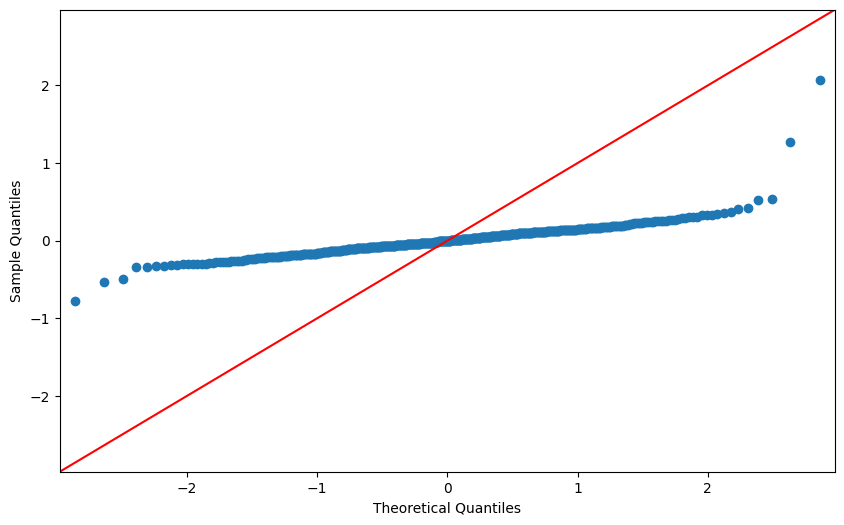

In [ ]:
#let us plot the qqplot
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

plt.savefig('SARIMA_qqplot_fdiff.png', dpi=300)

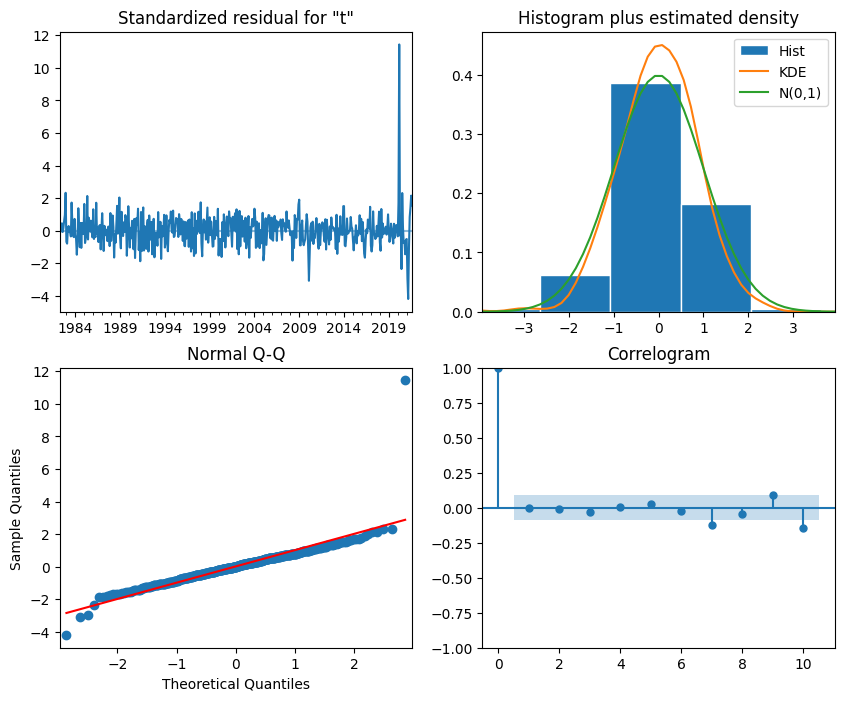

In [ ]:
#if you want to see the diagnostics plot
#this give you more details
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

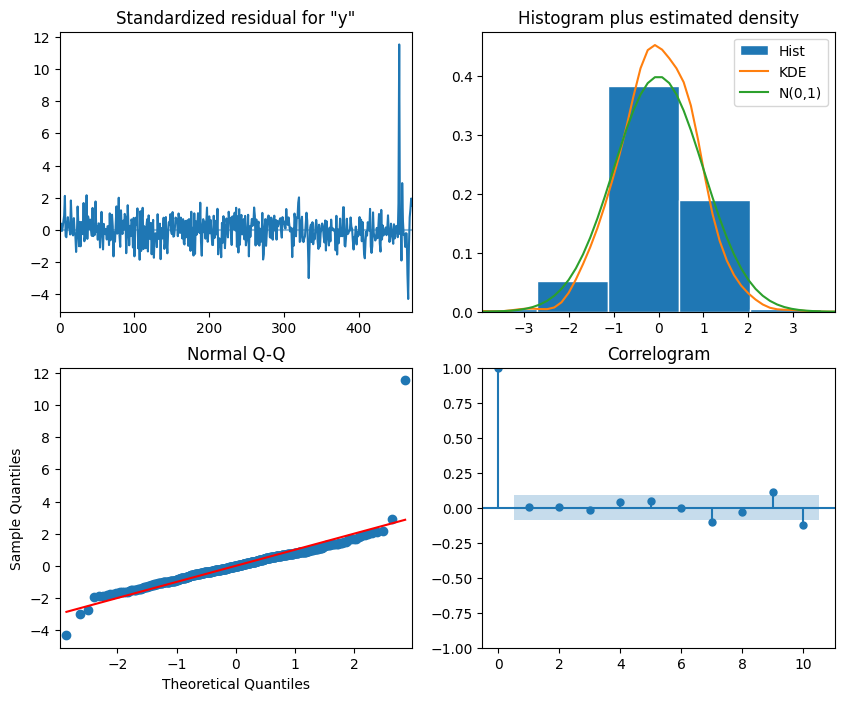

In [ ]:
#if you want to see the diagnostics plot
#this give you more details
SARIMA_model_fit_fdiff.plot_diagnostics(figsize=(10,8));

In [ ]:
#let's test if they are uncorrelated using ljung-box test
from statsmodels.stats.diagnostic import acorr_ljungbox

#we will compute for ljung-box statistic and p-value for 10 lags
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.002108   0.963381
2   0.002502   0.998750
3   0.050540   0.997024
4   0.052201   0.999665
5   0.069231   0.999935
6   0.162498   0.999916
7   0.331915   0.999859
8   2.036701   0.979866
9   2.121012   0.989406
10  2.456914   0.991489


In [ ]:
#let's test if they are uncorrelated using ljung-box test fdiff
from statsmodels.stats.diagnostic import acorr_ljungbox

#we will compute for ljung-box statistic and p-value for 10 lags
pvalue_fdiff = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue_fdiff)

      lb_stat  lb_pvalue
1    0.532823   0.465423
2    0.550626   0.759334
3    0.567661   0.903794
4    2.511219   0.642628
5    5.231640   0.388270
6    5.231665   0.514462
7   10.455507   0.164196
8   10.462436   0.234056
9   17.295266   0.044288
10  22.811762   0.011463


In [ ]:
SARIMA_pred = SARIMA_model_fit.get_prediction(473, 484).predicted_mean


testRW['SARIMA_pred'] = SARIMA_pred
testRW.head()

Date  Turnover  transformedTurnover  year month  random_walk  \
date                                                                            
2021-09-01 2021-09-01   12743.8            38.898207  2021   Sep    39.843937   
2021-10-01 2021-10-01   13224.0            39.299056  2021   Oct    39.705673   
2021-11-01 2021-11-01   12696.0            38.857691  2021   Nov    40.353361   
2021-12-01 2021-12-01   15164.3            40.815659  2021   Dec    41.876391   
2022-01-01 2022-01-01   13380.8            39.427584  2022   Jan    41.642238   

            SARIMA_pred  
date                     
2021-09-01    38.725905  
2021-10-01    39.355074  
2021-11-01    39.301706  
2021-12-01    40.737234  
2022-01-01    39.337560

In [ ]:
SARIMA_pred_fdiff = SARIMA_model_fit_fdiff.get_prediction(473, 484).predicted_mean


##testRWfdiff['SARIMA_pred'] = SARIMA_pred_fdiff
#testRWfdiff.head()

# Select the last 12 predictions
SARIMA_pred_fdiff_last12 = SARIMA_pred_fdiff[-12:]

# Create a DataFrame for the last 12 rows of testRWfdiff and add SARIMA predictions
testRWfdiff_last12 = pd.DataFrame({'fdiff': testRWfdiff[-12:], 'SARIMA_pred': SARIMA_pred_fdiff_last12})

# Display the DataFrame
print(testRWfdiff_last12)

       fdiff  SARIMA_pred
0   0.588170     0.618755
1   0.449906    -0.067255
2   1.097594     1.434626
3   2.620624    -1.403500
4   2.386471    -0.915525
5   2.152334     1.252202
6   3.731547    -0.716380
7   4.498981     0.233203
8   4.029507    -0.384846
9   4.572067     0.513020
10  4.108649     0.157902
11  3.642919    -0.248180


In [ ]:
testRW.tail()

Date  Turnover  transformedTurnover  year month  random_walk  \
date                                                                            
2022-04-01 2022-04-01   13033.5            39.141360  2022   Apr    43.754748   
2022-05-01 2022-05-01   12903.6            39.032837  2022   May    43.285274   
2022-06-01 2022-06-01   12469.6            38.664223  2022   Jun    43.827834   
2022-07-01 2022-07-01   13171.5            39.255767  2022   Jul    43.364416   
2022-08-01 2022-08-01   13282.6            39.347223  2022   Aug    42.898687   

            SARIMA_pred  
date                     
2022-04-01    38.986532  
2022-05-01    39.229978  
2022-06-01    38.845381  
2022-07-01    39.355425  
2022-08-01    39.516808

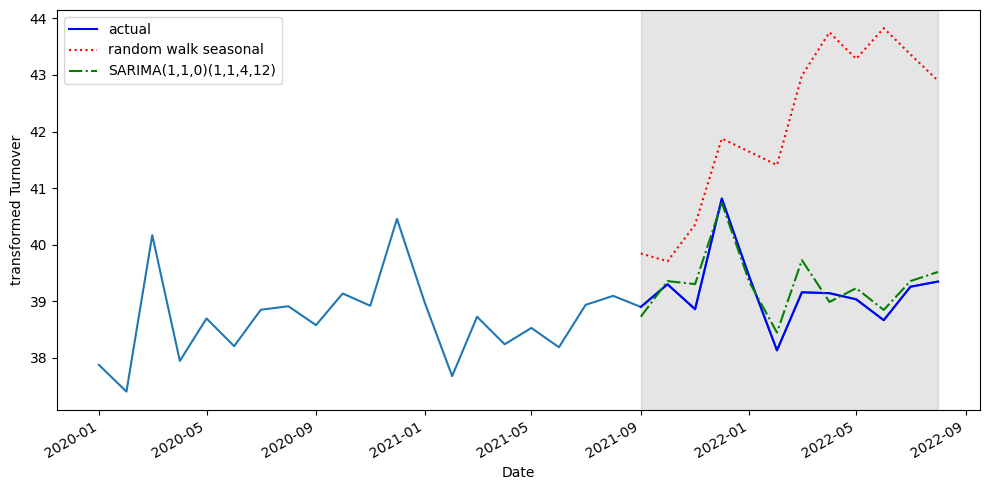

In [ ]:
import matplotlib.pyplot as plt

# Filter data for dates after 2020
df_after_2020 = df[df['Date'] >= '2020-01-01']
testRW_after_2020 = testRW[testRW['Date'] >= '2020-01-01']

# Plot the results
fig, ax = plt.subplots()

ax.plot(df_after_2020['Date'], df_after_2020['transformedTurnover'])
ax.plot(testRW_after_2020['transformedTurnover'], 'b-', label='actual')
ax.plot(testRW_after_2020['random_walk'], 'r:', label='random walk seasonal')
ax.plot(testRW_after_2020['SARIMA_pred'], 'g-.', label='SARIMA(1,1,0)(1,1,4,12)')

ax.set_xlabel('Date')
ax.set_ylabel('transformed Turnover')
ax.axvspan(testRW_after_2020['Date'].iloc[0], testRW_after_2020['Date'].iloc[-1], color='#808080', alpha=0.2)

ax.legend(loc=2)

fig.set_size_inches(10, 5)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


KeyError: 'random_walk'

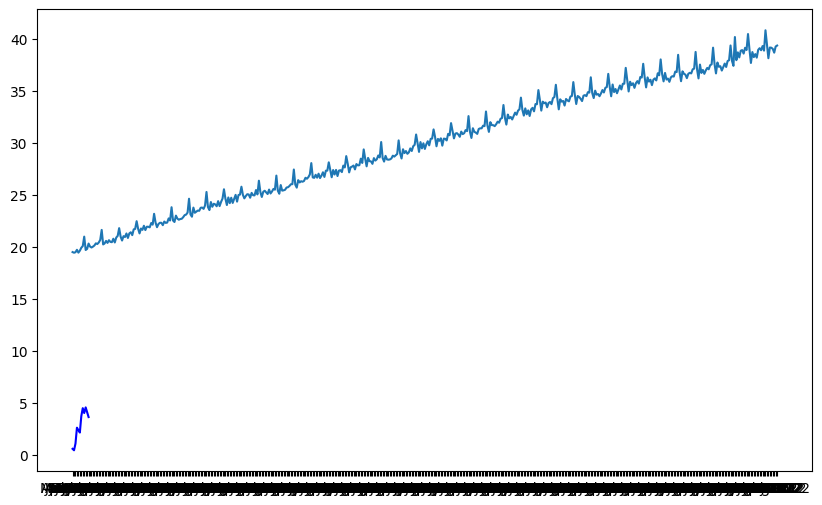

In [ ]:
import matplotlib.pyplot as plt

# Filter data for dates after 2020
df_after_2020 = df[df['Date'] >= '2020-01-01']
testRWfdiff_after_2020 = testRWfdiff_last12

# Plot the results
fig, ax = plt.subplots()

ax.plot(df_after_2020['Date'], df_after_2020['transformedTurnover'])
ax.plot(testRWfdiff_after_2020['fdiff'], 'b-', label='actual')
ax.plot(testRWfdiff_after_2020['random_walk'], 'r:', label='random walk seasonal')
ax.plot(testRWfdiff_after_2020['SARIMA_pred'], 'g-.', label='SARIMA(1,1,0)(1,1,4,12)')

ax.set_xlabel('Date')
ax.set_ylabel('transformed Turnover')
ax.axvspan(testRWfdiff_after_2020['Date'].iloc[0], testRWfdiff_after_2020['Date'].iloc[-1], color='#808080', alpha=0.2)

ax.legend(loc=2)

fig.set_size_inches(10, 5)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
#let us test using MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_RW_seasonal = mape(testRW['transformedTurnover'], testRW['random_walk'])
mape_SARIMA = mape(test['transformedTurnover'], test['SARIMA_pred'])

print(mape_RW_seasonal,  mape_SARIMA)

7.453056684161983 0.539961877306164


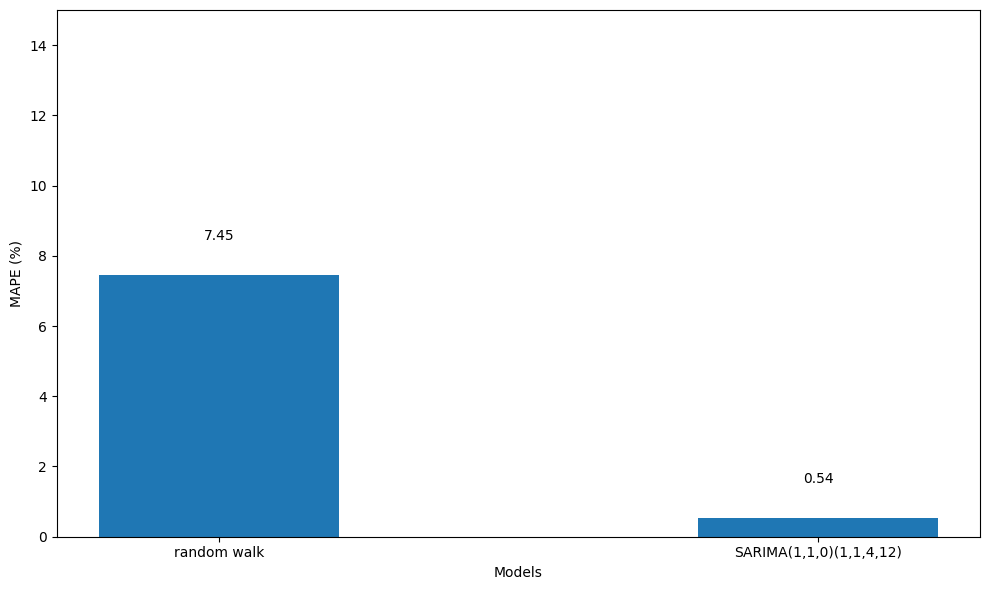

In [ ]:
#plot MAOE
fig, ax = plt.subplots()

x = ['random walk',  'SARIMA(1,1,0)(1,1,4,12)']
y = [mape_RW_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

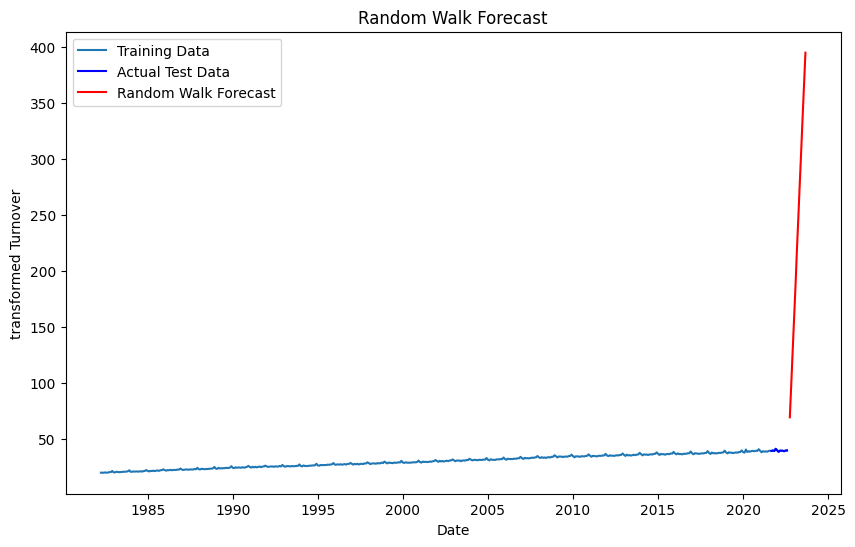

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# Fit the Random Walk model (ARIMA(0,0,0))
model_rw = ARIMA(train, order=(0, 0, 0))
fit_rw = model_rw.fit()

# Forecast the next 12 months
forecast_rw = fit_rw.forecast(steps=12)

# Reverse the differencing to get the forecast on the original scale
forecast_rw_cumsum = np.cumsum(forecast_rw)
final_forecast_rw = forecast_rw_cumsum + df['transformedTurnover'].iloc[-1]

# Generate dates for the forecast period
forecast_dates = pd.date_range(start=df['Date'].iloc[-1], periods=13, freq='M')[1:]

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_dates, final_forecast_rw, label='Random Walk Forecast', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('Random Walk Forecast')

# Add legend
plt.legend()

# Show the plot
plt.show()


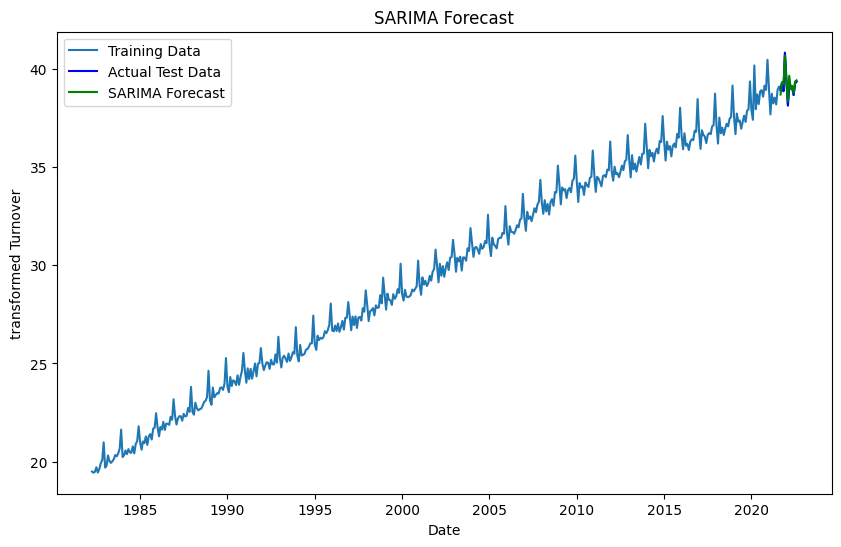

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# Use auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(train, seasonal=True, m=12, suppress_warnings=True, stepwise=True)

# Fit SARIMA model using the best parameters
order = sarima_model.get_params()['order']
seasonal_order = sarima_model.get_params()['seasonal_order']
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months
forecast_sarima = fit_sarima.forecast(steps=12)

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='green')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast')

# Add legend
plt.legend()

# Show the plot
plt.show()


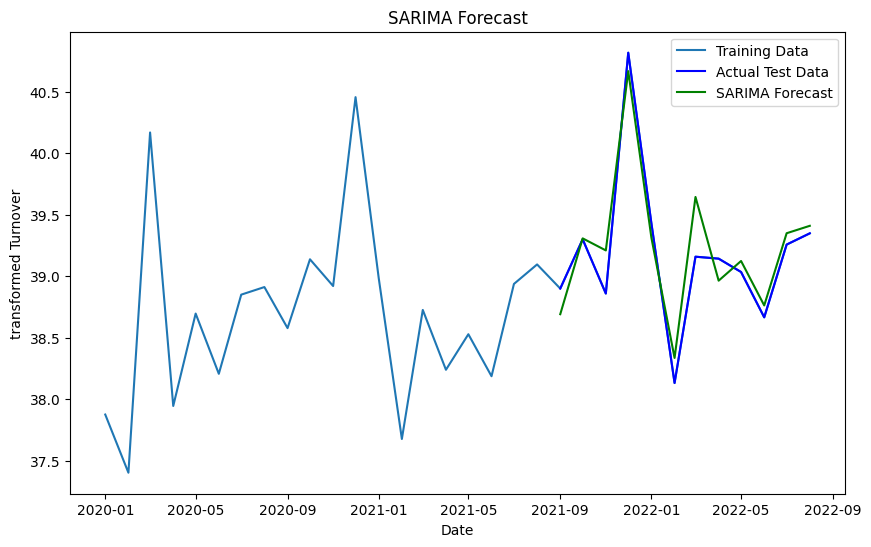

In [ ]:
# Plot the results
plt.plot(df['Date'].loc['2020':'2025'], df['transformedTurnover'].loc['2020':'2025'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='green')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast')

# Add legend
plt.legend()

# Show the plot
plt.show()

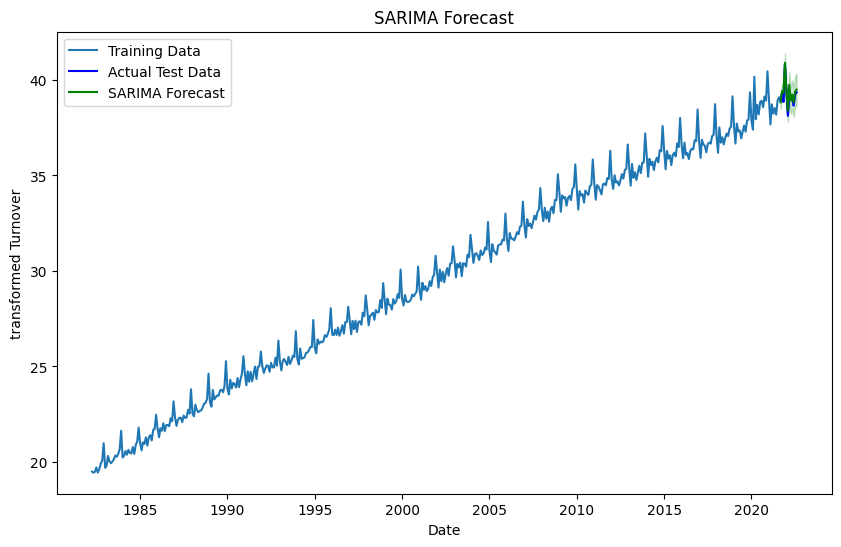

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# SARIMA model parameters
order = (1, 1, 0)
seasonal_order = (1, 1, 4, 12)

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast')

# Add legend
plt.legend()

# Show the plot
plt.show()


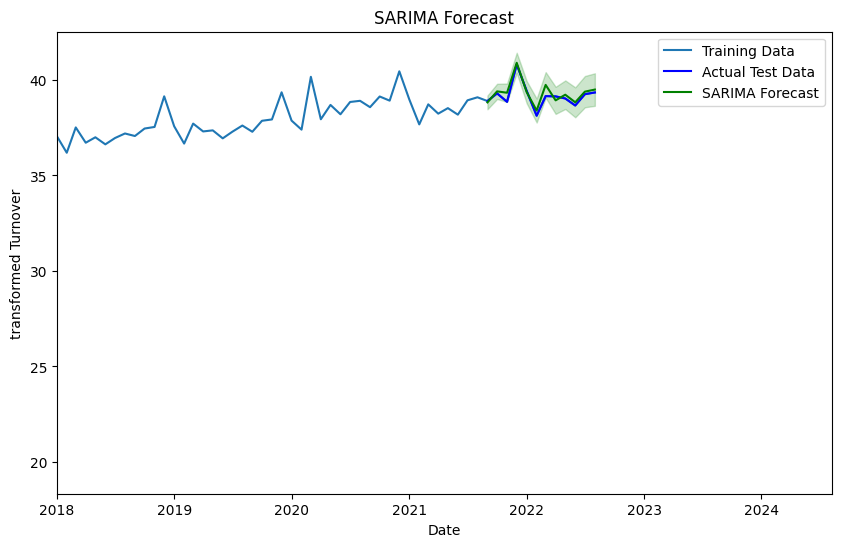

In [ ]:
# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast')

# Add legend
plt.legend()

# Set x-axis limits to show only dates greater than 2018
plt.xlim(pd.Timestamp('2018-01-01'), None)

# Show the plot
plt.show()

In [ ]:
!pip install plotly

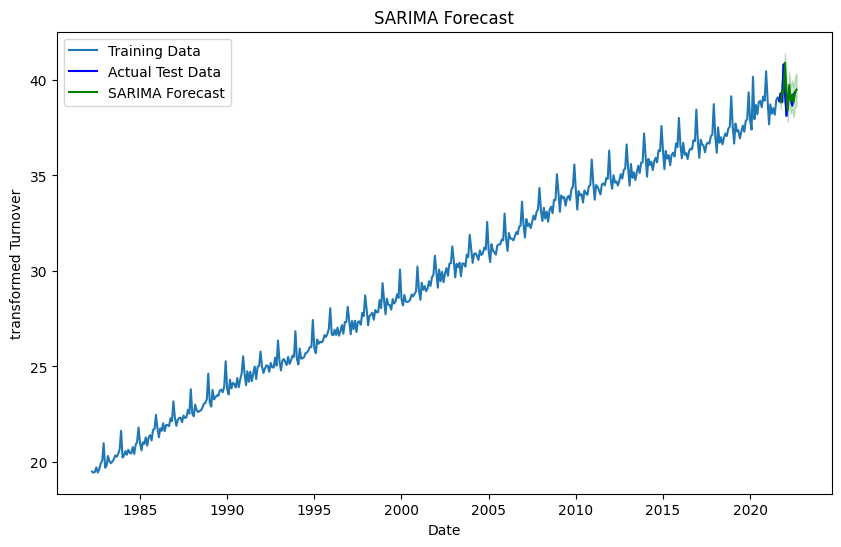

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# SARIMA model parameters
order = (1, 1, 0)
seasonal_order = (1, 1, 4, 12)

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame for forecasted values
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=test.index[0], periods=12, freq='M'),
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import plotly.express as px

# Create a DataFrame for plotting with Plotly
plot_data = pd.DataFrame({
    'Date': test.index,
    'Actual': test.values,
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Create a table-like plot using Plotly Express
fig = px.line(plot_data, x='Date', y=['Actual', 'Forecast', 'Lower CI', 'Upper CI'],
              labels={'value': 'transformed Turnover'},
              title='SARIMA Forecast')

# Show the plot
fig.show()

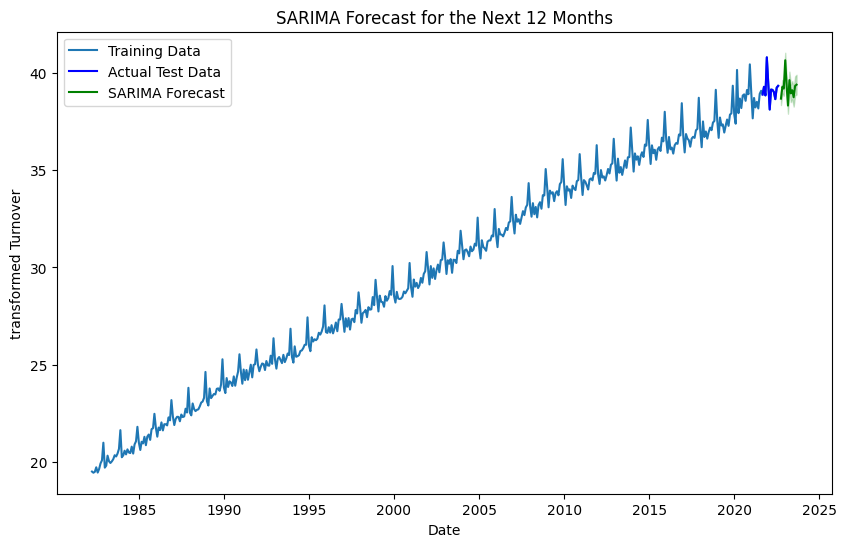

In [ ]:
# Forecast the next 12 months after August 2022
forecast_index = pd.date_range(start='2022-09-01', periods=12, freq='M')
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_index, forecast_values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast for the Next 12 Months')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import plotly.express as px

# Forecast the next 12 months after August 2022
forecast_index = pd.date_range(start='2022-09-01', periods=12, freq='M')
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame for plotting with Plotly
plot_data = pd.DataFrame({
    'Date': test.index.union(forecast_index),
    'Actual': np.concatenate([test.values, [np.nan] * 12]),  # Pad with NaNs for forecast
    'Forecast': np.concatenate([forecast_values.values, [np.nan] * 12]),
    'Lower CI': np.concatenate([conf_int.iloc[:, 0].values, [np.nan] * 12]),
    'Upper CI': np.concatenate([conf_int.iloc[:, 1].values, [np.nan] * 12])
})

# Create a table-like plot using Plotly Express
fig = px.line(plot_data, x='Date', y=['Actual', 'Forecast', 'Lower CI', 'Upper CI'],
              labels={'value': 'transformed Turnover'},
              title='SARIMA Forecast for the Next 12 Months')

# Show the plot
fig.show()


In [ ]:
# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame with forecast values and confidence intervals
forecast_table = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Display the table
print(forecast_table)


         Date   Forecast   Lower CI   Upper CI
0  2021-09-01  38.689728  38.359054  39.020402
1  2021-10-01  39.306200  38.958066  39.654334
2  2021-11-01  39.208357  38.838897  39.577816
3  2021-12-01  40.665844  40.278280  41.053407
4  2022-01-01  39.311170  38.908329  39.714012
5  2022-02-01  38.334159  37.912443  38.755875
6  2022-03-01  39.643028  39.205954  40.080103
7  2022-04-01  38.962355  38.511308  39.413402
8  2022-05-01  39.122404  38.654293  39.590515
9  2022-06-01  38.760906  38.279398  39.242413
10 2022-07-01  39.348013  38.853361  39.842665
11 2022-08-01  39.408329  38.898095  39.918563


Solution B: Box-cox

invers



In [ ]:
from scipy.stats import boxcox
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.special import inv_boxcox
import pandas as pd

# Assuming df is a DataFrame with a datetime index
df['transformedTurnover'], lam = boxcox(df['Turnover'])

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# Use auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(train, seasonal=True, m=12, suppress_warnings=True, stepwise=True)

# Fit SARIMA model using the best parameters
order = sarima_model.get_params()['order']
seasonal_order = sarima_model.get_params()['seasonal_order']
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months
forecast_sarima_transformed = fit_sarima.forecast(steps=12)

# Create a date range for the forecast
forecast_index = pd.date_range(start=test.index[0], periods=len(forecast_sarima_transformed), freq='M')

# Inverse transform the forecasted values
forecast_sarima = inv_boxcox(forecast_sarima_transformed, lam)


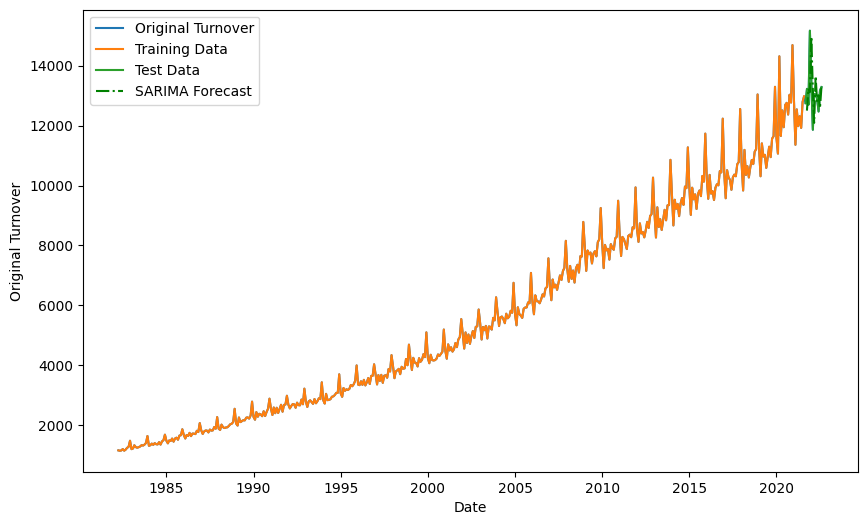

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.plot(df.index, df['Turnover'], label='Original Turnover')
plt.plot(train.index, inv_boxcox(train, lam), label='Training Data')
plt.plot(test.index, inv_boxcox(test, lam), label='Test Data')
plt.plot(forecast_index, forecast_sarima, 'g-.', label='SARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Original Turnover')
plt.legend()
plt.show()

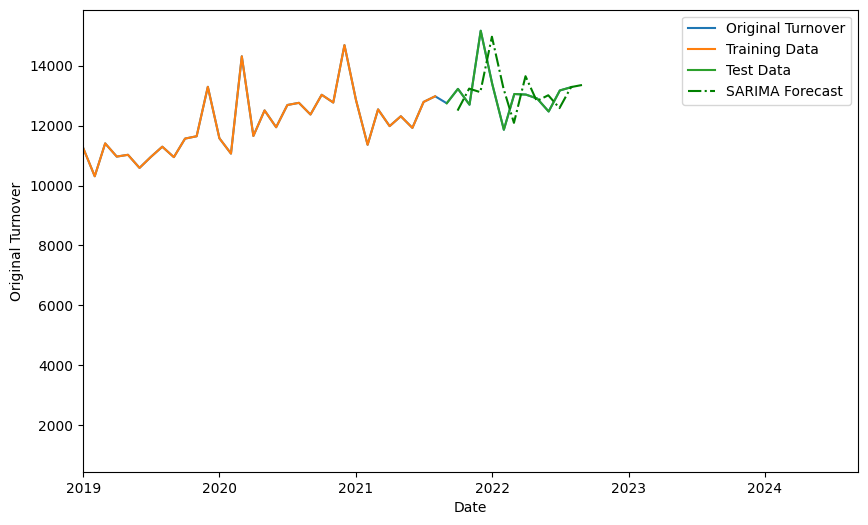

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.plot(df.index, df['Turnover'], label='Original Turnover')
plt.plot(train.index, inv_boxcox(train, lam), label='Training Data')
plt.plot(test.index, inv_boxcox(test, lam), label='Test Data')
plt.plot(forecast_index, forecast_sarima, 'g-.', label='SARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Original Turnover')

# Set x-axis limits to show only dates greater than 2019
plt.xlim(pd.Timestamp('2019-01-01'), None)

plt.legend()
plt.show()


Lets predict the next 12 month from 2022/9 inclusively

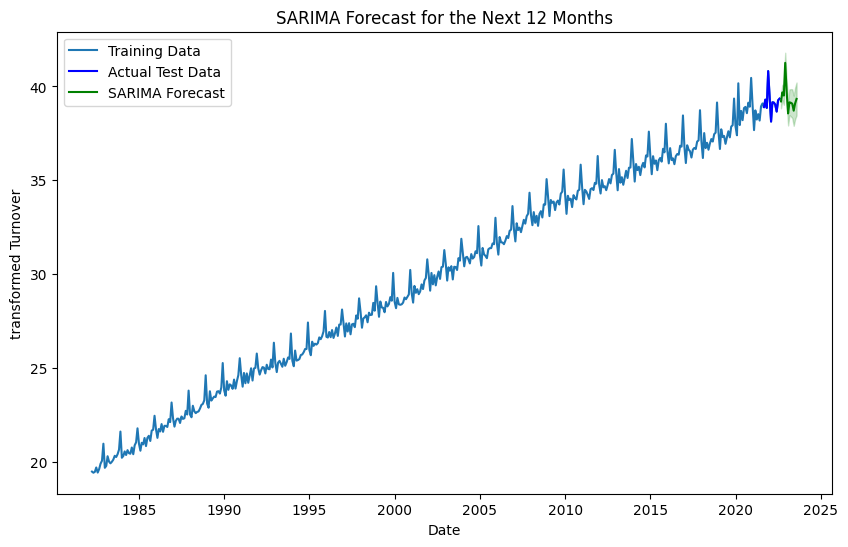

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Use the differenced data for training
train = df['transformedTurnover'].iloc[:-12]
test = df['transformedTurnover'].iloc[-12:]

# SARIMA model parameters
order = (1, 1, 0)
seasonal_order = (1, 1, 4, 12)

# Fit SARIMA model using the specified parameters
model_sarima = SARIMAX(df['transformedTurnover'], order=order, seasonal_order=seasonal_order)
fit_sarima = model_sarima.fit()

# Forecast the next 12 months starting from the last available data point (August 2022)
forecast_sarima = fit_sarima.get_forecast(steps=12)

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Plot the results
plt.plot(df['Date'], df['transformedTurnover'], label='Training Data')
plt.plot(test.index, test.values, label='Actual Test Data', color='blue')
plt.plot(forecast_values.index, forecast_values.values, label='SARIMA Forecast', color='green')

# Fill the area between upper and lower confidence intervals
plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('transformed Turnover')
plt.title('SARIMA Forecast for the Next 12 Months')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Extract forecasted values and confidence intervals
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create a DataFrame with forecast values and confidence intervals
forecast_table = pd.DataFrame({
    'Date': forecast_values.index,
    'Forecast': forecast_values.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

# Display the table
print(forecast_table)


         Date   Forecast   Lower CI   Upper CI
0  2022-09-01  39.204907  38.837474  39.572341
1  2022-10-01  39.685349  39.278280  40.092418
2  2022-11-01  39.514766  39.023080  40.006453
3  2022-12-01  41.254854  40.714894  41.794814
4  2023-01-01  39.704249  39.108935  40.299564
5  2023-02-01  38.562945  37.922453  39.203438
6  2023-03-01  39.154526  38.469195  39.839856
7  2023-04-01  39.131445  38.405348  39.857543
8  2023-05-01  39.082339  38.316996  39.847682
9  2023-06-01  38.707952  37.905605  39.510299
10 2023-07-01  39.096704  38.258823  39.934584
11 2023-08-01  39.336227  38.464342  40.208113


Seasonality adjustment
turning point occuring the year

Libraries

In [ ]:
# Import packages
import plotly.express as px
import pandas as pd

# Import packages
from scipy.stats import boxcox

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller